In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nltk -q

In [3]:
!pip install -U sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.0 MB/s eta 0:00:00


# Combine All Document

In [4]:
import os
import pandas as pd

base_dir = '/content/drive/MyDrive/BDC SEMIFINAL/01 Datasets/04 txt raw files'

data = []

def extract_text(file_path):
  with open(file_path, 'r') as file:
    file_contents = file.read()
    isi_pasal_index = file_contents.find('Isi Pasal:')
    if isi_pasal_index != -1:
      extracted_text = file_contents[isi_pasal_index + len('Isi Pasal:'):]
      return extracted_text.strip()
  return None

for root, dirs, files in os.walk(base_dir):
  for file in files:
    if file.endswith('.txt'):
      file_path = os.path.join(root, file)
      extracted_text = extract_text(file_path)
      if extracted_text:
        # Extracting the subfolder name as 'Tingkatan'
        tingkatan = os.path.basename(root)
        # Removing '.txt' from the file name
        file_name = os.path.splitext(file)[0]
        data.append((tingkatan, file_name, extracted_text))

df = pd.DataFrame(data, columns=['Tingkatan', 'FileName', 'ExtractedText'])

In [5]:
df

Tingkatan                                           FileName  \
0    Peraturan Pemerintah  PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...   
1    Peraturan Pemerintah              Peraturan_Pemerintah_No.63_Tahun_2019   
2    Peraturan Pemerintah               Peraturan_Pemerintah_No.1_Tahun_2008   
3    Peraturan Pemerintah               Peraturan_Pemerintah_No.8_Tahun_2007   
4    Peraturan Pemerintah              Peraturan_Pemerintah_No.24_Tahun_2019   
..                    ...                                                ...   
103              UU_Perpu                     Undang-Undang_No.33_Tahun_2004   
104              UU_Perpu                      Undang-Undang_No.9_Tahun_2018   
105              UU_Perpu                     Undang-Undang_No.40_Tahun_2014   
106              UU_Perpu                           Perpu Nomor 1 Tahun 2020   
107              UU_Perpu                     Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  
0    Menetapkan\n"Peraturan Pemerintah Pengganti Un...  
1    :\n\nPERATURAN PEMERINTAH TENTANG INVESTASI\nP...  
2    :\n\nMenetapkan:\n\nPERATURAN PEMERINTAH TENTA...  
3    :\nMenetapkan:\nPERATURAN PEMERINTAH TENTANG I...  
4    : ...\n
Menetapkan\n\nSK No 005037 A\n\na\n\nB...  
..                                                 ...  
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...  
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...  
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...  
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...  
107  :\n\nMenetapkan : Undang-undang tentang CKeten...  

[108 rows x 3 columns]

## Import Library

In [6]:
import pandas as pd
import nltk
nltk.data.path.append("/root/nltk_data/tokenizers")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
nltk.download('punkt', download_dir="/root/nltk_data", quiet=True, raise_on_error=True)
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [8]:
!pip install Sastrawi -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import networkx as nx
import textwrap

## Build the Function

In [10]:
def split_sentences(text):
  # Split the text into sentences based on '\n\n' pattern
  sentences = re.split(r'\n\n', text)

  # Clean up the sentences by removing leading/trailing whitespaces
  sentences = [sentence.lower().strip() for sentence in sentences]

  return sentences

def remove_punctuation(sentences):
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  cleaned_sentences = []
  for sentence in sentences:
    cleaned_sentence = sentence.translate(translator)
    cleaned_sentences.append(cleaned_sentence)
  return cleaned_sentences

def remove_stopwords(sentences_list):
  # Download Indonesian stopwords list from NLTK
  stop_words = set(stopwords.words('indonesian'))

  # Tokenize each sentence and remove stopwords
  cleaned_sentences = []
  for sentence in sentences_list:
    words = word_tokenize(sentence)
    filtered_sentence = [word for word in words if word.lower() not in stop_words]
    cleaned_sentences.append(' '.join(filtered_sentence))

  return cleaned_sentences

def remove_pasal_sentences(text_list):
  # Define the regular expression pattern to match 'pasal' followed by a space and digits
  pattern = r'pasal\s\d+'
  # Filter out sentences that match the regular expression
  filtered_list = [sentence for sentence in text_list if not re.search(pattern, sentence)]
  return filtered_list

def remove_empty_text(sentences_list):
  non_empty_sentences = [[sentence for sentence in sentences if sentence.strip() != ""] for sentences in sentences_list]
  non_empty_sentences = [sentences for sentences in non_empty_sentences if sentences]  # Remove empty lists
  return non_empty_sentences

def remove_numbering(sentences_list):
  # Define the regular expression pattern to match numbering patterns
  pattern = r'\b[A-Za-z1-9]\.'
  # Remove the numbering pattern from each sentence in the list
  filtered_list = [re.sub(pattern, '', sentence) for sentence in sentences_list]
  return filtered_list

def remove_numbering_in_parentheses(sentences_list):
  # Define the regular expression pattern to match the numbering in parentheses at the start of the sentence
  pattern = r'\(\d+\)'

  # Remove the numbering pattern from each sentence in the list
  filtered_list = [re.sub(pattern, '', sentence) for sentence in sentences_list]

  return filtered_list

def remove_danatau(sentences):
  # Remove 'danatau' from the text
  cleaned_sentences = [sentence.replace('danatau', '') for sentence in sentences]
  return cleaned_sentences

def replace_newlines_with_spaces(sentences_list):
  # Replace '\n' with a space in each sentence
  cleaned_list = [sentence.replace('\n', ' ') for sentence in sentences_list]
  return cleaned_list

def delete_link(sentence_list):
  filtered_sentences = [sentence for sentence in sentence_list if 'www' not in sentence and 'bphn' not in sentence]
  return filtered_sentences

def filter_sentences(sentences_list):
  # Remove sentences that only have 1 word or include 'bab'
  filtered_sentences = [sentence for sentence in sentences_list if len(sentence.split()) > 2 and 'bab' not in sentence]
  return filtered_sentences

def stem_text(sentences_list):
  # Create a StemmerFactory and get the default Indonesian stemmer
  stemmer = StemmerFactory().create_stemmer()
  # Stem each sentence in the list
  stemmed_sentences = [stemmer.stem(sentence) for sentence in sentences_list]
  return stemmed_sentences

## Preprocess

In [11]:
df['ExtractedText'][0]

'Menetapkan\n"Peraturan Pemerintah Pengganti Undang-undang tentang Penggunaan\ndan Pengawasan atas Penggunaan Dana-dana Investasi".\n\nPasal 1.\n\nDalam Peraturan Pemerintah Pengganti Undang-undang ini yang\n\ndimaksudkan dengan\n\na.dana investasi, ialah : dana-dana yang menurut ketetapan\nMenteri yang bersangkutan tersedia untuk diperbungakan\nkarena tidak/belum segera diperlukan untuk memenuhi maksud\npemupukannya, termasuk dana-dana cadangan pada perusahaan-\nperusahaan/badan-badan pada umumnya;\n\nb.perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan\nfungsi utamanya harus secara teratur memperbungakan dana-\ndana investasinya dalam obyek-obyek pembungaan berjangka\natau perusahaan/badan yang memupuk dana-dana cadangan untuk\nkeperluan perluasan atau untuk menutup kerangka yang mungkin\ndiderita atau perusahaan/ badan lain semacam itu yang\nditetapkan oleh Menteri yang bersangkutan.\n\nc.Menteri yang bersangkutan, ialah: Menteri Urusan Pendapatan,\nPembiayaan dan Penga

In [12]:
df['cleaned_text'] = df['ExtractedText'].apply(split_sentences)
df['cleaned_text'][0]

['menetapkan\n"peraturan pemerintah pengganti undang-undang tentang penggunaan\ndan pengawasan atas penggunaan dana-dana investasi".',
 'pasal 1.',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'a.dana investasi, ialah : dana-dana yang menurut ketetapan\nmenteri yang bersangkutan tersedia untuk diperbungakan\nkarena tidak/belum segera diperlukan untuk memenuhi maksud\npemupukannya, termasuk dana-dana cadangan pada perusahaan-\nperusahaan/badan-badan pada umumnya;',
 'b.perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan\nfungsi utamanya harus secara teratur memperbungakan dana-\ndana investasinya dalam obyek-obyek pembungaan berjangka\natau perusahaan/badan yang memupuk dana-dana cadangan untuk\nkeperluan perluasan atau untuk menutup kerangka yang mungkin\ndiderita atau perusahaan/ badan lain semacam itu yang\nditetapkan oleh menteri yang bersangkutan.',
 'c.menteri yang bersangkutan, ialah: menteri urusan pendapatan,\npembiayaan da

In [13]:
df['cleaned_text'] = df['cleaned_text'].apply(replace_newlines_with_spaces)
df['cleaned_text'][0]

['menetapkan "peraturan pemerintah pengganti undang-undang tentang penggunaan dan pengawasan atas penggunaan dana-dana investasi".',
 'pasal 1.',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'a.dana investasi, ialah : dana-dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak/belum segera diperlukan untuk memenuhi maksud pemupukannya, termasuk dana-dana cadangan pada perusahaan- perusahaan/badan-badan pada umumnya;',
 'b.perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana- dana investasinya dalam obyek-obyek pembungaan berjangka atau perusahaan/badan yang memupuk dana-dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan/ badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan.',
 'c.menteri yang bersangkutan, ialah: menteri urusan pendapatan, pembiayaan dan pengawasan 

In [14]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_pasal_sentences)
df['cleaned_text'][0]

['menetapkan "peraturan pemerintah pengganti undang-undang tentang penggunaan dan pengawasan atas penggunaan dana-dana investasi".',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'a.dana investasi, ialah : dana-dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak/belum segera diperlukan untuk memenuhi maksud pemupukannya, termasuk dana-dana cadangan pada perusahaan- perusahaan/badan-badan pada umumnya;',
 'b.perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana- dana investasinya dalam obyek-obyek pembungaan berjangka atau perusahaan/badan yang memupuk dana-dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan/ badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan.',
 'c.menteri yang bersangkutan, ialah: menteri urusan pendapatan, pembiayaan dan pengawasan sepanjang men

In [15]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_numbering)
df['cleaned_text'][0]

['menetapkan "peraturan pemerintah pengganti undang-undang tentang penggunaan dan pengawasan atas penggunaan dana-dana investasi".',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'dana investasi, ialah : dana-dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak/belum segera diperlukan untuk memenuhi maksud pemupukannya, termasuk dana-dana cadangan pada perusahaan- perusahaan/badan-badan pada umumnya;',
 'perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana- dana investasinya dalam obyek-obyek pembungaan berjangka atau perusahaan/badan yang memupuk dana-dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan/ badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan.',
 'menteri yang bersangkutan, ialah: menteri urusan pendapatan, pembiayaan dan pengawasan sepanjang mengenai 

In [16]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_numbering_in_parentheses)
df['cleaned_text'][0]

['menetapkan "peraturan pemerintah pengganti undang-undang tentang penggunaan dan pengawasan atas penggunaan dana-dana investasi".',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'dana investasi, ialah : dana-dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak/belum segera diperlukan untuk memenuhi maksud pemupukannya, termasuk dana-dana cadangan pada perusahaan- perusahaan/badan-badan pada umumnya;',
 'perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana- dana investasinya dalam obyek-obyek pembungaan berjangka atau perusahaan/badan yang memupuk dana-dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan/ badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan.',
 'menteri yang bersangkutan, ialah: menteri urusan pendapatan, pembiayaan dan pengawasan sepanjang mengenai 

In [17]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_punctuation)
df['cleaned_text'][0]

['menetapkan  peraturan pemerintah pengganti undang undang tentang penggunaan dan pengawasan atas penggunaan dana dana investasi  ',
 'dalam peraturan pemerintah pengganti undang undang ini yang',
 'dimaksudkan dengan',
 'dana investasi  ialah   dana dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak belum segera diperlukan untuk memenuhi maksud pemupukannya  termasuk dana dana cadangan pada perusahaan  perusahaan badan badan pada umumnya ',
 'perusahaan badan  ialah perusahaan badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana  dana investasinya dalam obyek obyek pembungaan berjangka atau perusahaan badan yang memupuk dana dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan  badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan ',
 'menteri yang bersangkutan  ialah  menteri urusan pendapatan  pembiayaan dan pengawasan sepanjang mengenai 

In [18]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_danatau)
df['cleaned_text'][0]

['menetapkan  peraturan pemerintah pengganti undang undang tentang penggunaan dan pengawasan atas penggunaan dana dana investasi  ',
 'dalam peraturan pemerintah pengganti undang undang ini yang',
 'dimaksudkan dengan',
 'dana investasi  ialah   dana dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak belum segera diperlukan untuk memenuhi maksud pemupukannya  termasuk dana dana cadangan pada perusahaan  perusahaan badan badan pada umumnya ',
 'perusahaan badan  ialah perusahaan badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana  dana investasinya dalam obyek obyek pembungaan berjangka atau perusahaan badan yang memupuk dana dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan  badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan ',
 'menteri yang bersangkutan  ialah  menteri urusan pendapatan  pembiayaan dan pengawasan sepanjang mengenai 

In [19]:
df['cleaned_text'] = df['cleaned_text'].apply(delete_link)
df['cleaned_text'][0]

['menetapkan  peraturan pemerintah pengganti undang undang tentang penggunaan dan pengawasan atas penggunaan dana dana investasi  ',
 'dalam peraturan pemerintah pengganti undang undang ini yang',
 'dimaksudkan dengan',
 'dana investasi  ialah   dana dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak belum segera diperlukan untuk memenuhi maksud pemupukannya  termasuk dana dana cadangan pada perusahaan  perusahaan badan badan pada umumnya ',
 'perusahaan badan  ialah perusahaan badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana  dana investasinya dalam obyek obyek pembungaan berjangka atau perusahaan badan yang memupuk dana dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan  badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan ',
 'menteri yang bersangkutan  ialah  menteri urusan pendapatan  pembiayaan dan pengawasan sepanjang mengenai 

In [20]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
df['cleaned_text'][0]

['menetapkan peraturan pemerintah pengganti undang undang penggunaan pengawasan penggunaan dana dana investasi',
 'peraturan pemerintah pengganti undang undang',
 '',
 'dana investasi dana dana ketetapan menteri bersangkutan tersedia diperbungakan memenuhi maksud pemupukannya dana dana cadangan perusahaan perusahaan badan badan',
 'perusahaan badan perusahaan badan menjalankan fungsi utamanya teratur memperbungakan dana dana investasinya obyek obyek pembungaan berjangka perusahaan badan memupuk dana dana cadangan keperluan perluasan menutup kerangka diderita perusahaan badan ditetapkan menteri bersangkutan',
 'menteri bersangkutan menteri urusan pendapatan pembiayaan pengawasan pengaturan dana investasi perusahaan perusahaan asuransi menteri urusan bank sentral pengaturan',
 'dana investasi perusahaan perusahaan badan',
 'badan',
 'menteri bersangkutan berwenang mengambil tindakan mengeluarkan peraturan peraturan pengawasan penggunaan dana dana investasi',
 'peraturan ditetapkan menter

In [21]:
df['cleaned_text'] = df['cleaned_text'].apply(filter_sentences)
df['cleaned_text'][0]

['menetapkan peraturan pemerintah pengganti undang undang penggunaan pengawasan penggunaan dana dana investasi',
 'peraturan pemerintah pengganti undang undang',
 'dana investasi dana dana ketetapan menteri bersangkutan tersedia diperbungakan memenuhi maksud pemupukannya dana dana cadangan perusahaan perusahaan badan badan',
 'perusahaan badan perusahaan badan menjalankan fungsi utamanya teratur memperbungakan dana dana investasinya obyek obyek pembungaan berjangka perusahaan badan memupuk dana dana cadangan keperluan perluasan menutup kerangka diderita perusahaan badan ditetapkan menteri bersangkutan',
 'menteri bersangkutan menteri urusan pendapatan pembiayaan pengawasan pengaturan dana investasi perusahaan perusahaan asuransi menteri urusan bank sentral pengaturan',
 'dana investasi perusahaan perusahaan badan',
 'menteri bersangkutan berwenang mengambil tindakan mengeluarkan peraturan peraturan pengawasan penggunaan dana dana investasi',
 'peraturan ditetapkan menteri bersangkutan 

In [22]:
df['cleaned_text'] = df['cleaned_text'].apply(stem_text)
df['cleaned_text'][0]

['tetap atur perintah ganti undang undang guna awas guna dana dana investasi',
 'atur perintah ganti undang undang',
 'dana investasi dana dana tetap menteri sangkut sedia bunga penuh maksud pupu dana dana cadang usaha usaha badan badan',
 'usaha badan usaha badan jalan fungsi utama atur bunga dana dana investasi obyek obyek bunga jangka usaha badan pupuk dana dana cadang perlu luas tutup kerangka derita usaha badan tetap menteri sangkut',
 'menteri sangkut menteri urus dapat biaya awas atur dana investasi usaha usaha asuransi menteri urus bank sentral atur',
 'dana investasi usaha usaha badan',
 'menteri sangkut wenang ambil tindak keluar atur atur awas guna dana dana investasi',
 'atur tetap menteri sangkut usaha badan usaha indonesia wajib dana investasi',
 'deposito bank indonesia',
 'kertas bendahara negara',
 'obyek obyek bunga tetap menteri',
 'menteri urus dapat biaya awas menteri urus bank sentral tetap atur keluar guna kertas bendahara negara simpang tentu tentu undang undang

In [23]:
def combine_sentences(sentences_list):
  # Combine the list of sentences into one text
  combined_text = ' '.join(sentences_list)

  return combined_text

In [24]:
df['final_text'] = df['cleaned_text'].apply(combine_sentences)
df['final_text'][88]

'tetap putus menteri negara investasi kepala badan koordinasi tanam modal pedoman tata mohon tanam modal diri rangka tanam modal negeri tanam modal asing tanam modal asing tiga tentu khusus bidang usaha giat usaha tambang minyak gas bumi rangka pmdn tambang minyak gas bumi rangka pma kantor wakil wilayah usaha asing usaha serta modal ubah lokasi proyek tiga ubah bidang usaha produksi empat ubah guna tenaga kerja asing ubah investasi sumber biaya enam ubah milik saham usaha pma tujuh ubah status usaha pma pmdn delap ubah status usaha pmdn non pma pmdn usaha pma sembilan panjang selesai proyek pmdn pma puluh gabung usaha merger sebelas ubah nama usaha belas ubah bentuk pola mitra mitra usaha khusus bidang usaha syarat mitra usaha impor bahan baku tolong tiga angka kenal importir batas apit empat izin kerja tenaga kerja warga negara asing datang'

In [25]:
def tfidf(text, max_feat = 1000):
  # Create the TfidfVectorizer with bigram and trigram
  vectorizer = TfidfVectorizer(analyzer = 'word', ngram_range = (2,3), max_features = max_feat)
  tfidf_matrix = vectorizer.fit_transform(text)
  feature_names = vectorizer.get_feature_names_out()
  return tfidf_matrix, feature_names

# Antar Tingkat

## UU_Perpu vs PP

In [26]:
selected_df = df.query('Tingkatan == "Peraturan Pemerintah" or Tingkatan == "UU_Perpu"')
selected_df.tail()

Tingkatan                        FileName  \
103  UU_Perpu  Undang-Undang_No.33_Tahun_2004   
104  UU_Perpu   Undang-Undang_No.9_Tahun_2018   
105  UU_Perpu  Undang-Undang_No.40_Tahun_2014   
106  UU_Perpu        Perpu Nomor 1 Tahun 2020   
107  UU_Perpu  Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  \
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...   
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...   
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...   
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...   
107  :\n\nMenetapkan : Undang-undang tentang CKeten...   

                                          cleaned_text  \
103  [tetap undang undang imbang uang perintah pusa...   
104  [tetap undang undang terima negara pajak, teri...   
105  [tetap undang undang asuransi, presiden republ...   
106  [atur perintah ganti undang undang bijak uang ...   
107  [tetap undang undang cketentuan tentu pokok ba...   

                                            final_text  
103  tetap undang undang imbang uang perintah pusat...  
104  tetap undang undang terima negara pajak terima...  
105  tetap undang undang asuransi presiden republik...  
106  atur perintah ganti undang undang bijak uang n...  
107  tetap undang undang cketentuan tentu pokok ban...

In [27]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'])
tfidf_matrix_dense = tfidf_matrix.toarray()

In [28]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(51, 1000)


In [29]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 miliar' '00 puluh' '00 ratus' '00 triliun' '000 00' '000 00 miliar'
 '000 00 puluh' '000 00 ratus' '000 00 triliun' '000 000' '000 000 00'
 '000 000 000' '10 puluh' '10 puluh kerja' '10 puluh persen' '12 belas'
 '15 belas' '15 belas persen' '20 puluh' '20 puluh persen' '30 puluh'
 '31 desember' '50 puluh' '50 puluh persen' '500 000' 'ada barang'
 'ada barang jasa' 'administratif ayat' 'agen asuransi' 'agun aset'
 'ajar formal' 'ajar formal nonformal' 'aksud ayat' 'akuntan publik'
 'akuntansi uang' 'alih aset' 'alokasi anggar' 'alokasi anggar perintah'
 'alokasi dana' 'ampun pajak' 'ana dim' 'ana dim aksud' 'ana dm'
 'ana dm aksud' 'anggar 2015' 'anggar 2021' 'anggar anggar'
 'anggar belanja' 'anggar dapat' 'anggar dapat belanja' 'anggar dasar'
 'anggar didik' 'anggar menteri' 'anggar menteri negara' 'anggar perintah'
 'anggar tahun' 'anggota bursa' 'anggota bursa efek' 'anggota dewan'
 'anggota dewan awas' 'anggota dewan komisioner' 'anggota direksi'
 'antara dagang

### Document-Term Matrix

In [30]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 miliar  00 puluh  \
FileName                                                                  
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...   0.000000  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019                0.000000  0.000000   
Peraturan_Pemerintah_No.1_Tahun_2008                 0.000000  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                 0.000000  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019                0.000000  0.000000   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...   0.000000  0.000000   
2021pp049                                            0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1996                0.000000  0.000000   
Peraturan_Pemerintah_No._49_Tahun_2011               0.000000  0.000000   
Peraturan_Pemerintah_No.75_Tahun_1992                0.000000  0.000000   
Peraturan_Pemerintah_No.99_Tahun_2013                0.000000  0.000000   
Peraturan_Pemerintah_No.5_Tahun_2018                 0.000000  0.000000   
Peraturan_Pemerintah_No.77_Tahun_1992                0.000000  0.000000   
Peraturan_Pemerintah_No._45_Tahun_1995               0.025667  0.006154   
Peraturan_Pemerintah_No.25_Tahun_2020                0.000000  0.000000   
Peraturan_Pemerintah_No.48_Tahun_2008                0.000000  0.000000   
Peraturan_Pemerintah_No.18_Tahun_1983                0.000000  0.000000   
Peraturan_Pemerintah_No.30_Tahun_1982                0.000000  0.000000   
Peraturan_Pemerintah_No.53_Tahun_2018                0.000000  0.000000   
PP_55_2015                                           0.000000  0.000000   
Peraturan_Pemerintah_No.49_Tahun_2017                0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1984                0.000000  0.000000   
Peraturan_Pemerintah_No.107_Tahun_2015               0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_2013                0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_1992                0.000000  0.000000   
2022pp031                                            0.000000  0.000000   
PP Nomor 93 Tahun 2021                               0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_2016                0.000000  0.000000   
PP_27_1985                                           0.000000  0.000000   
Peraturan_Pemerintah_No.54_Tahun_1993                0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_1993                0.000000  0.000000   
Peraturan_Pemerintah_No.105_Tahun_2000               0.000000  0.000000   
Peraturan_Pemerintah_No.40_Tahun_2000                0.000000  0.000000   
Undang-Undang_No.8_Tahun_1995                        0.016623  0.000000   
Undang-Undang_No.11_Tahun_2016                       0.007225  0.013856   
Undang-Undang_No.1_Tahun_2004                        0.021409  0.024638   
Undang-Undang_No.4_Tahun_2016                        0.000000  0.000000   
Undang-Undang_No.21_Tahun_2008                       0.000000  0.009336   
Salinan UU Nomor 9 Tahun 2020                        0.007742  0.055687   
Undang-Undang_No._24_Tahun_2011                      0.000000  0.000000   
UU411999                                             0.006573  0.000000   
UU Nomor 4 Tahun 2009                                0.000000  0.003616   
Undang-Undang_No.27_Tahun_2014                       0.000000  0.053206   
UU_34_1964                                           0.000000  0.000000   
Undang-Undang_No.22_Tahun_2006                       0.000000  0.000000   
Undang-Undang_No.24_Tahun_2004                       0.013866  0.000000   
Undang-Undang_No.33_Tahun_2004                       0.000000  0.000000   
Undang-Undang_No.9_Tahun_2018                        0.000000  0.003596   
Undang-Undang_No.40_Tahun_2014                       0.000000  0.000000   
Perpu Nomor 1 Tahun 2020                             0.000000  0.000000   
Undang-Undang_No.13_Tahun_1962                       0.000000  0.000000   

                                                    00 ratus  00 triliun  \


### Calculate the similarity

In [31]:
# Import cosine_similarity measure
from sklearn.metrics.pairwise import cosine_similarity

# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName' in df where 'Tingkatan' is 'Peraturan Pemerintah'
PP_file_names = df[df['Tingkatan'] == 'Peraturan Pemerintah']['FileName'].values

# Filter the 'FileName' in df where 'Tingkatan' is 'UU_Perpu'
UU_file_names = df[df['Tingkatan'] == 'UU_Perpu']['FileName'].values

In [32]:
filtered_df = cosine_similarity_df[UU_file_names]
filtered_df = filtered_df.loc[PP_file_names]
filtered_df

FileName                                            Undang-Undang_No.8_Tahun_1995  \
FileName                                                                            
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                       0.030520   
Peraturan_Pemerintah_No.63_Tahun_2019                                    0.098875   
Peraturan_Pemerintah_No.1_Tahun_2008                                     0.015098   
Peraturan_Pemerintah_No.8_Tahun_2007                                     0.018194   
Peraturan_Pemerintah_No.24_Tahun_2019                                    0.042746   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                       0.021861   
2021pp049                                                                0.129084   
Peraturan_Pemerintah_No.28_Tahun_1996                                    0.040478   
Peraturan_Pemerintah_No._49_Tahun_2011                                   0.045683   
Peraturan_Pemerintah_No.75_Tahun_1992                                    0.066231   
Peraturan_Pemerintah_No.99_Tahun_2013                                    0.073541   
Peraturan_Pemerintah_No.5_Tahun_2018                                     0.040046   
Peraturan_Pemerintah_No.77_Tahun_1992                                    0.019149   
Peraturan_Pemerintah_No._45_Tahun_1995                                   0.649626   
Peraturan_Pemerintah_No.25_Tahun_2020                                    0.094950   
Peraturan_Pemerintah_No.48_Tahun_2008                                    0.009743   
Peraturan_Pemerintah_No.18_Tahun_1983                                    0.055805   
Peraturan_Pemerintah_No.30_Tahun_1982                                    0.061791   
Peraturan_Pemerintah_No.53_Tahun_2018                                    0.063523   
PP_55_2015                                                               0.122924   
Peraturan_Pemerintah_No.49_Tahun_2017                                    0.031844   
Peraturan_Pemerintah_No.28_Tahun_1984                                    0.046426   
Peraturan_Pemerintah_No.107_Tahun_2015                                   0.080458   
Peraturan_Pemerintah_No.33_Tahun_2013                                    0.034568   
Peraturan_Pemerintah_No.73_Tahun_1992                                    0.030768   
2022pp031                                                                0.345941   
PP Nomor 93 Tahun 2021                                                   0.077269   
Peraturan_Pemerintah_No.73_Tahun_2016                                    0.032905   
PP_27_1985                                                               0.075198   
Peraturan_Pemerintah_No.54_Tahun_1993                                    0.130187   
Peraturan_Pemerintah_No.33_Tahun_1993                                    0.053988   
Peraturan_Pemerintah_No.105_Tahun_2000                                   0.020315   
Peraturan_Pemerintah_No.40_Tahun_2000                                    0.032388   

FileName                                            Undang-Undang_No.11_Tahun_2016  \
FileName                                                                             
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                        0.019724   
Peraturan_Pemerintah_No.63_Tahun_2019                                     0.051627   
Peraturan_Pemerintah_No.1_Tahun_2008                                      0.011981   
Peraturan_Pemerintah_No.8_Tahun_2007                                      0.011530   
Peraturan_Pemerintah_No.24_Tahun_2019                                     0.028617   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                        0.010219   
2021pp049                                                                 0.257777   
Peraturan_Pemerintah_No.28_Tahun_1996                                     0.022254   
Peraturan_Pemerintah_No._49_Tahun_2011                                    0.029182   
Peraturan_Pemerintah_No.75_Tahun_1992                                     0.04

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

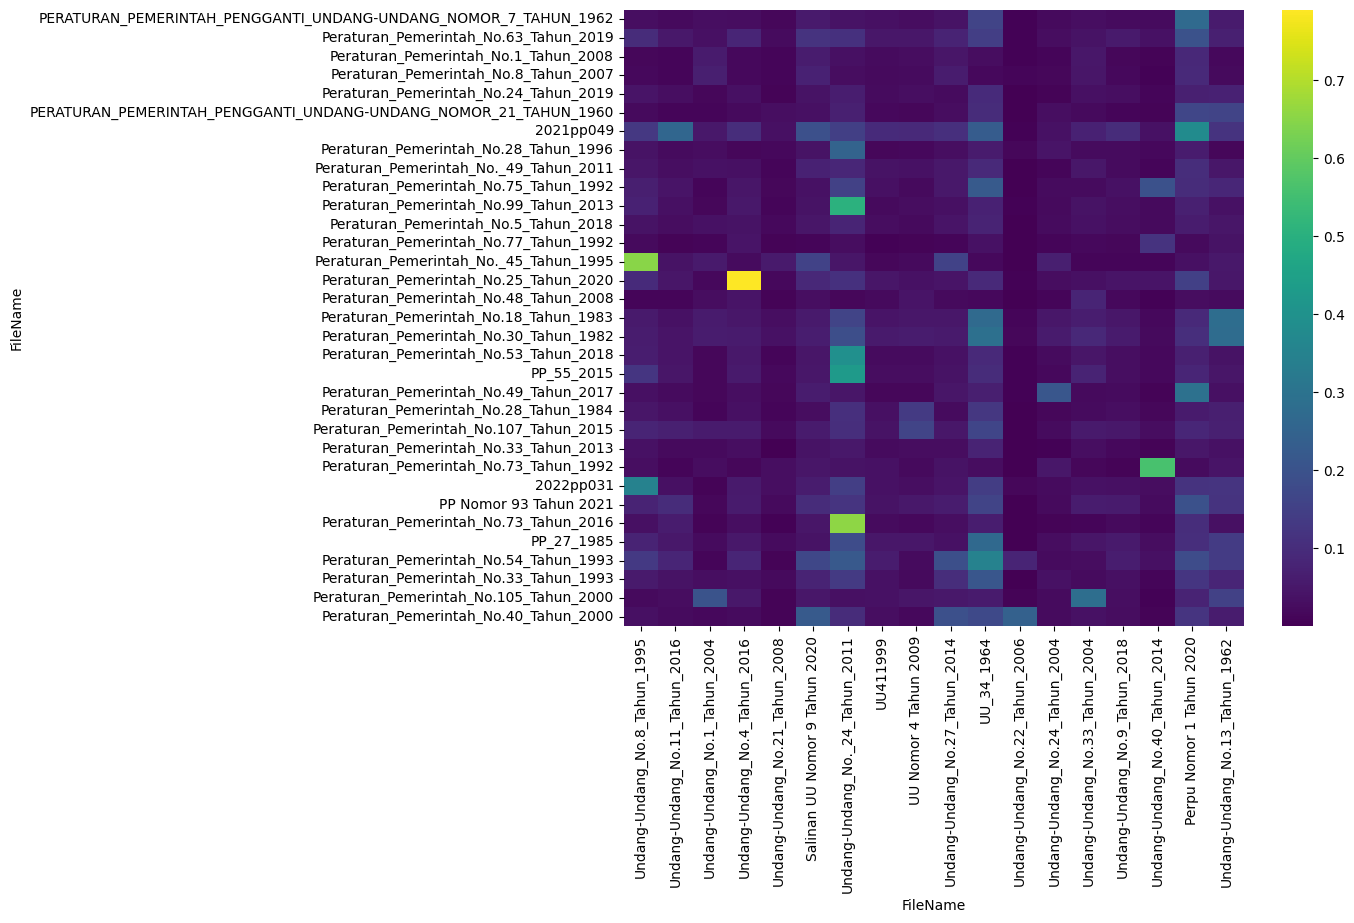

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [35]:
def convert_to_label(score):
    if score < 0.2:
        return 'Tidak Selaras'
    elif score < 0.4:
        return 'Netral'
    else:
        return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                                           Undang-Undang_No.8_Tahun_1995  \
FileName                                                                           
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                 Tidak Selaras   
Peraturan_Pemerintah_No.63_Tahun_2019                              Tidak Selaras   
Peraturan_Pemerintah_No.1_Tahun_2008                               Tidak Selaras   
Peraturan_Pemerintah_No.8_Tahun_2007                               Tidak Selaras   
Peraturan_Pemerintah_No.24_Tahun_2019                              Tidak Selaras   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                 Tidak Selaras   
2021pp049                                                          Tidak Selaras   
Peraturan_Pemerintah_No.28_Tahun_1996                              Tidak Selaras   
Peraturan_Pemerintah_No._49_Tahun_2011                             Tidak Selaras   
Peraturan_Pemerintah_No.75_Tahun_1992                              Tidak Selaras   
Peraturan_Pemerintah_No.99_Tahun_2013                              Tidak Selaras   
Peraturan_Pemerintah_No.5_Tahun_2018                               Tidak Selaras   
Peraturan_Pemerintah_No.77_Tahun_1992                              Tidak Selaras   
Peraturan_Pemerintah_No._45_Tahun_1995                                   Selaras   
Peraturan_Pemerintah_No.25_Tahun_2020                              Tidak Selaras   
Peraturan_Pemerintah_No.48_Tahun_2008                              Tidak Selaras   
Peraturan_Pemerintah_No.18_Tahun_1983                              Tidak Selaras   
Peraturan_Pemerintah_No.30_Tahun_1982                              Tidak Selaras   
Peraturan_Pemerintah_No.53_Tahun_2018                              Tidak Selaras   
PP_55_2015                                                         Tidak Selaras   
Peraturan_Pemerintah_No.49_Tahun_2017                              Tidak Selaras   
Peraturan_Pemerintah_No.28_Tahun_1984                              Tidak Selaras   
Peraturan_Pemerintah_No.107_Tahun_2015                             Tidak Selaras   
Peraturan_Pemerintah_No.33_Tahun_2013                              Tidak Selaras   
Peraturan_Pemerintah_No.73_Tahun_1992                              Tidak Selaras   
2022pp031                                                                 Netral   
PP Nomor 93 Tahun 2021                                             Tidak Selaras   
Peraturan_Pemerintah_No.73_Tahun_2016                              Tidak Selaras   
PP_27_1985                                                         Tidak Selaras   
Peraturan_Pemerintah_No.54_Tahun_1993                              Tidak Selaras   
Peraturan_Pemerintah_No.33_Tahun_1993                              Tidak Selaras   
Peraturan_Pemerintah_No.105_Tahun_2000                             Tidak Selaras   
Peraturan_Pemerintah_No.40_Tahun_2000                              Tidak Selaras   

FileName                                           Undang-Undang_No.11_Tahun_2016  \
FileName                                                                            
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                  Tidak Selaras   
Peraturan_Pemerintah_No.63_Tahun_2019                               Tidak Selaras   
Peraturan_Pemerintah_No.1_Tahun_2008                                Tidak Selaras   
Peraturan_Pemerintah_No.8_Tahun_2007                                Tidak Selaras   
Peraturan_Pemerintah_No.24_Tahun_2019                               Tidak Selaras   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                  Tidak Selaras   
2021pp049                                                                  Netral   
Peraturan_Pemerintah_No.28_Tahun_1996                               Tidak Selaras   
Peraturan_Pemerintah_No._49_Tahun_2011                              Tidak Selaras   
Peraturan_Pemerintah_No.75_Tahun_1992                               Tidak Selaras   
Peraturan_Pemerintah_No.99_Tahun_2013  

### Total

In [36]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil dari UU_Perpu dan Peraturan Pemerintah
pd.DataFrame(counts['Total'])

Total
Netral          23.0
Selaras          6.0
Tidak Selaras  565.0

### Peraturan UU_Perpu dan Peraturan Pemerintah yang Selaras

In [37]:
import numpy as np

row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                     Perundangan2
0   Peraturan_Pemerintah_No.99_Tahun_2013  Undang-Undang_No._24_Tahun_2011
1  Peraturan_Pemerintah_No._45_Tahun_1995    Undang-Undang_No.8_Tahun_1995
2   Peraturan_Pemerintah_No.25_Tahun_2020    Undang-Undang_No.4_Tahun_2016
3                              PP_55_2015  Undang-Undang_No._24_Tahun_2011
4   Peraturan_Pemerintah_No.73_Tahun_1992   Undang-Undang_No.40_Tahun_2014
5   Peraturan_Pemerintah_No.73_Tahun_2016  Undang-Undang_No._24_Tahun_2011

In [38]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [39]:
df_selaras

Perundangan1                     Perundangan2  \
0   Peraturan_Pemerintah_No.99_Tahun_2013  Undang-Undang_No._24_Tahun_2011   
1  Peraturan_Pemerintah_No._45_Tahun_1995    Undang-Undang_No.8_Tahun_1995   
2   Peraturan_Pemerintah_No.25_Tahun_2020    Undang-Undang_No.4_Tahun_2016   
3                              PP_55_2015  Undang-Undang_No._24_Tahun_2011   
4   Peraturan_Pemerintah_No.73_Tahun_1992   Undang-Undang_No.40_Tahun_2014   
5   Peraturan_Pemerintah_No.73_Tahun_2016  Undang-Undang_No._24_Tahun_2011   

                                              Topic1  \
0                         tetap atur perintah kelola   
1  tetap atur perintah selenggara giat bidang pas...   
2       atur perintah selenggara tabung rumah rakyat   
3                        presiden republik indonesia   
4        atur perintah republik indonesia selenggara   
5  atur perintah pajak hasil program jamin sosial...   

                                        Topic2  
0  undang undang badan selenggara jamin sosial  
1              tetap undang undang pasar modal  
2            undang undang tabung rumah rakyat  
3  undang undang badan selenggara jamin sosial  
4                 tetap undang undang asuransi  
5  undang undang badan selenggara jamin sosial

In [40]:
all_selaras = pd.DataFrame()

In [41]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1                     Perundangan2  \
0   Peraturan_Pemerintah_No.99_Tahun_2013  Undang-Undang_No._24_Tahun_2011   
1  Peraturan_Pemerintah_No._45_Tahun_1995    Undang-Undang_No.8_Tahun_1995   
2   Peraturan_Pemerintah_No.25_Tahun_2020    Undang-Undang_No.4_Tahun_2016   
3                              PP_55_2015  Undang-Undang_No._24_Tahun_2011   
4   Peraturan_Pemerintah_No.73_Tahun_1992   Undang-Undang_No.40_Tahun_2014   
5   Peraturan_Pemerintah_No.73_Tahun_2016  Undang-Undang_No._24_Tahun_2011   

                                              Topic1  \
0                         tetap atur perintah kelola   
1  tetap atur perintah selenggara giat bidang pas...   
2       atur perintah selenggara tabung rumah rakyat   
3                        presiden republik indonesia   
4        atur perintah republik indonesia selenggara   
5  atur perintah pajak hasil program jamin sosial...   

                                        Topic2  
0  undang undang badan selenggara jamin sosial  
1              tetap undang undang pasar modal  
2            undang undang tabung rumah rakyat  
3  undang undang badan selenggara jamin sosial  
4                 tetap undang undang asuransi  
5  undang undang badan selenggara jamin sosial

## Peraturan Pemerintah vs Peraturan Presiden

In [42]:
selected_df = df.query('Tingkatan == "Peraturan Pemerintah" or Tingkatan == "Peraturan Presiden"')
selected_df.tail()

Tingkatan                             FileName  \
60  Peraturan Presiden  Keputusan_Presiden_No.28_Tahun_2010   
61  Peraturan Presiden                       Inpres_11_2011   
62  Peraturan Presiden               Inpres No 6 Tahun 2014   
63  Peraturan Presiden            Inpres Nomor 2 Tahun 2021   
64  Peraturan Presiden            INPRES Nomor 6 Tahun 2016   

                                        ExtractedText  \
60  :\n\nMenetapkan:\n\nKEPUTUSAN PRESIDEN TENTANG...   
61  PRESIDEN REPUBLIK INDONESIA\nNOMOR 11 TAHUN 20...   
62  PRESIDEN REPUBLIK INDONESIA\n\nNOMOR 6 TAHUN 2...   
63  PRESIDEN REPUBLIK INDONESIA\n\nNOMOR 2 TAHUN 2...   
64  PRESIDEN REPUBLIK INDONESIA\nNOMOR 6 TAHUN 201...   

                                         cleaned_text  \
60  [putus presiden ubah putus presiden nomor 3 20...   
61  [presiden republik indonesia nomor 11 2011, la...   
62  [presiden republik indonesia, nomor 6 2014, ti...   
63  [presiden republik indonesia, nomor 2 2021, op...   
64  [presiden republik indonesia nomor 6 2016, cep...   

                                           final_text  
60  putus presiden ubah putus presiden nomor 3 200...  
61  presiden republik indonesia nomor 11 2011 laks...  
62  presiden republik indonesia nomor 6 2014 tingk...  
63  presiden republik indonesia nomor 2 2021 optim...  
64  presiden republik indonesia nomor 6 2016 cepat...

In [43]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'])
tfidf_matrix_dense = tfidf_matrix.toarray()

In [44]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(65, 1000)


In [45]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 ratus' '000 00' '000 00 ratus' '000 000' '000 000 00' '000 000 000'
 '10 puluh' '10 puluh kerja' '10 puluh persen' '12 belas' '15 belas'
 '15 belas persen' '20 puluh' '20 puluh persen' '31 desember' '50 puluh'
 '50 puluh persen' '500 000' '500 000 000' 'ada barang' 'agun aset'
 'ahli bidang' 'ahli bidang ekonomi' 'ahli bidang hubung'
 'ahli bidang hukum' 'ajar formal' 'ajar formal nonformal' 'aksi mitigasi'
 'aktif program' 'aktif program jamin' 'akuntansi uang' 'alam jasa'
 'alat sehat' 'alih aset' 'alih partisipasi' 'alih partisipasi interes'
 'alokasi anggar' 'alokasi anggar perintah' 'ampun pajak'
 'analisis evaluasi' 'analisis evaluasi lapor' 'anggar dapat'
 'anggar dapat belanja' 'anggar dasar' 'anggar perintah'
 'anggar perintah daerah' 'anggar tahun' 'anggota bursa'
 'anggota bursa efek' 'anggota direksi' 'anggota djsn' 'angkat henti'
 'antara dagang' 'antara dagang efek' 'aparatur negara' 'aset bersih'
 'aset bpjs' 'aset bpjs ketenagakerjaan' 'aset dana' 'a

### Document-Term Matrix

In [46]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 ratus    000 00  \
FileName                                                                 
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...       0.0  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019                    0.0  0.012186   
Peraturan_Pemerintah_No.1_Tahun_2008                     0.0  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                     0.0  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019                    0.0  0.000000   
...                                                      ...       ...   
Keputusan_Presiden_No.28_Tahun_2010                      0.0  0.000000   
Inpres_11_2011                                           0.0  0.000000   
Inpres No 6 Tahun 2014                                   0.0  0.000000   
Inpres Nomor 2 Tahun 2021                                0.0  0.000000   
INPRES Nomor 6 Tahun 2016                                0.0  0.000000   

                                                    000 00 ratus   000 000  \
FileName                                                                     
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...           0.0  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019                        0.0  0.031993   
Peraturan_Pemerintah_No.1_Tahun_2008                         0.0  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                         0.0  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019                        0.0  0.000000   
...                                                          ...       ...   
Keputusan_Presiden_No.28_Tahun_2010                          0.0  0.000000   
Inpres_11_2011                                               0.0  0.000000   
Inpres No 6 Tahun 2014                                       0.0  0.000000   
Inpres Nomor 2 Tahun 2021                                    0.0  0.000000   
INPRES Nomor 6 Tahun 2016                                    0.0  0.000000   

                                                    000 000 00  000 000 000  \
FileName                                                                      
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...    0.000000     0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019                 0.012186     0.022658   
Peraturan_Pemerintah_No.1_Tahun_2008                  0.000000     0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                  0.000000     0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019                 0.000000     0.000000   
...                                                        ...          ...   
Keputusan_Presiden_No.28_Tahun_2010                   0.000000     0.000000   
Inpres_11_2011                                        0.000000     0.000000   
Inpres No 6 Tahun 2014                                0.000000     0.000000   
Inpres Nomor 2 Tahun 2021                             0.000000     0.000000   
INPRES Nomor 6 Tahun 2016                             0.000000     0.000000   

                                                    10 puluh  10 puluh kerja  \
FileName                                                                       
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...       0.0             0.0   
Peraturan_Pemerintah_No.63_Tahun_2019                    0.0             0.0   
Peraturan_Pemerintah_No.1_Tahun_2008                     0.0             0.0   
Peraturan_Pemerintah_No.8_Tahun_2007                     0.0             0.0   
Peraturan_Pemerintah_No.24_Tahun_2019                    0.0             0.0   
...                                                      ...             ...   
Keputusan_Presiden_No.28_Tahun_2010                      0.0             0.0   
Inpres_11_2011                                           0.0             0.0   
Inpres No 6 Tahun 2014                                   0.0             0.0   
Inpres Nomor 2 Tahun 2021                                0.0             0.0   
INPRES Nomor 6 Tahun 2016                                0.0             0.0   

     

### Calculate the similarity

In [47]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName' in df where 'Tingkatan' is 'Peraturan Pemerintah'
PP_file_names = df[df['Tingkatan'] == 'Peraturan Pemerintah']['FileName'].values

# Filter the 'FileName' in df where 'Tingkatan' is 'Peraturan Presiden'
PPres_file_names = df[df['Tingkatan'] == 'Peraturan Presiden']['FileName'].values

In [48]:
filtered_df = cosine_similarity_df[PP_file_names]
filtered_df = filtered_df.loc[PPres_file_names]
filtered_df

FileName                              PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                
Peraturan_Presiden_No.23_Tahun_2017                                            0.013234                 
PERPRES_49_2011                                                                0.024616                 
Peraturan_Presiden_No._27_Tahun_2009                                           0.007685                 
Perpres Nomor 31 Tahun 2021                                                    0.006055                 
Peraturan_Presiden_No.71_Tahun_2019                                            0.004530                 
Perpres Nomor 98 Tahun 2021                                                    0.003894                 
PERPRES_41_2015                                                                0.018562                 
Salinan Perpres Nomor 71 Tahun 2019                                            0.004527                 
Peraturan_Presiden_No.44_Tahun_2008                                            0.016921                 
Peraturan_Presiden_No.9_Tahun_2011                                             0.011510                 
Peraturan_Presiden_No.46_Tahun_2019                                            0.009448                 
Peraturan_Presiden_No.55_Tahun_2020                                            0.003187                 
Peraturan_Presiden_No.10_Tahun_1964                                            0.028889                 
Perpres Nomor 63 Tahun 2021                                                    0.010275                 
Keputusan_Presiden_No.101_Tahun_1998                                           0.009110                 
Keputusan_Presiden_No.108_Tahun_2001                                           0.004706                 
kp1831998                                                                      0.046752                 
Keppres2951965                                                                 0.104833                 
Keppres0541993                                                                 0.058311                 
Keputusan_Presiden_No.121_Tahun_1999                                           0.056851                 
Keputusan_Presiden_No.176_Tahun_2000                                           0.009198                 
Keputusan_Presiden_No.37_Tahun_1970                                            0.002632                 
Keputusan_Presiden_No.32_Tahun_2016                                            0.004499                 
Keppres Nomor 20 Tahun 2020                                                    0.001203                 
Keputusan_Presiden_No.12_Tahun_2006                                            0.010715                 
Keppres Nomor 11 Tahun 2021                                                    0.002607                 
Keputusan_Presiden_No.117_Tahun_1999                                           0.005159                 
Keputusan_Presiden_No.28_Tahun_2010                                            0.009144                 
Inpres_11_2011                                                                 0.005619                 
Inpres No 6 Tahun 2014                                                         0.004060                 
Inpres Nomor 2 Tahun 2021                                                      0.007567                 
INPRES Nomor 6 Tahun 2016                                                      0.002463                 

FileName                              Peraturan_Pemerintah_No.63_Tahun_2019  \
FileName                                                                      
Peraturan_Presiden_No.23_Tahun_2017                                0.031552   
PERPRES_49_2011                                                    0.105598   
Peraturan_Presiden_No._27_Tahun_2009                               0.028561   
Perpres Nomor 31 Tahun 2021       

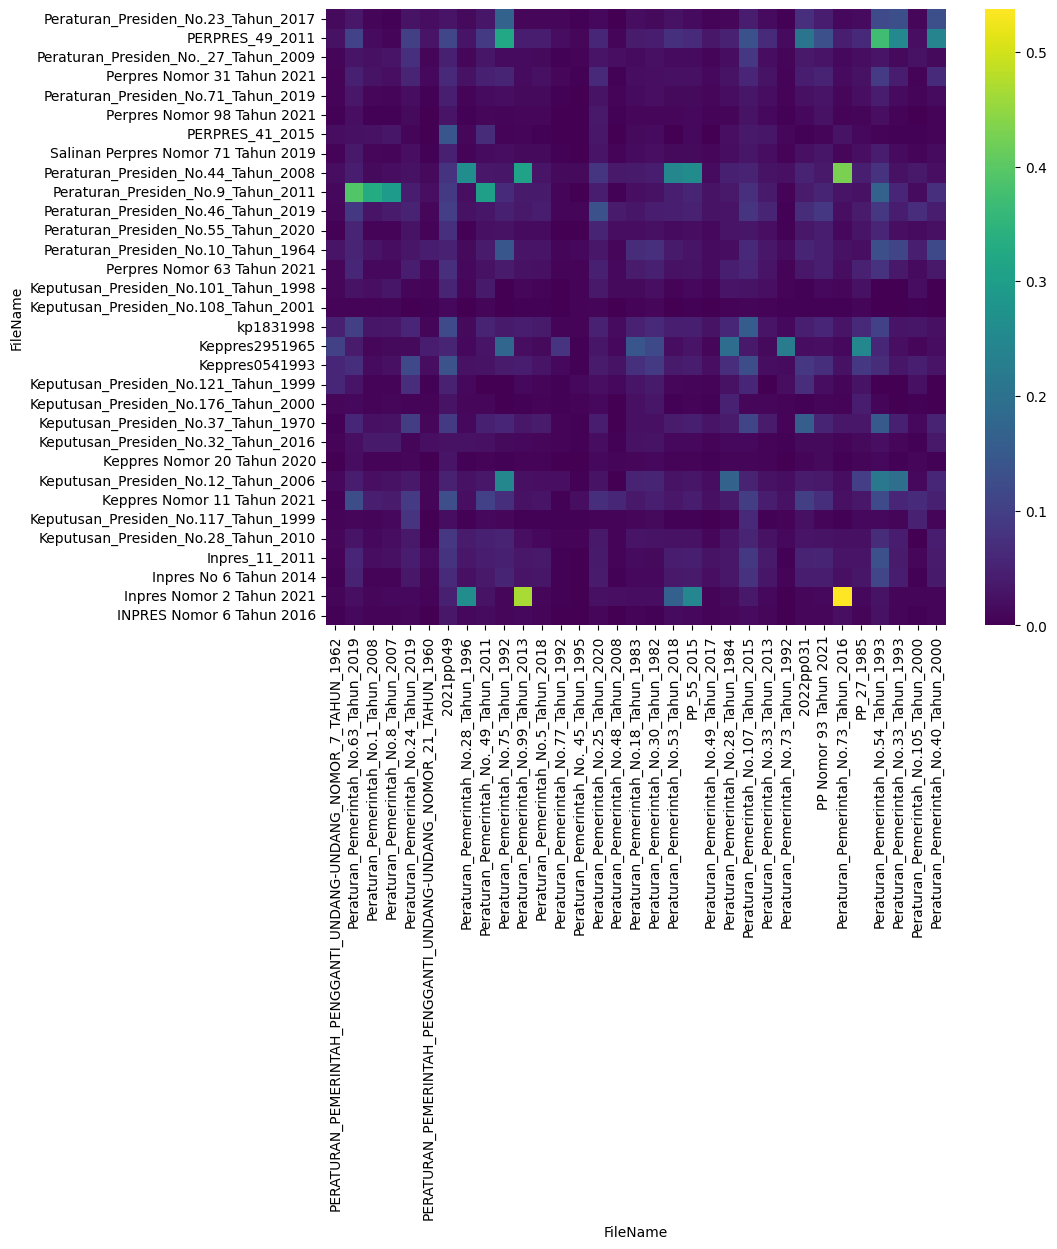

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [50]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                             PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                               
Peraturan_Presiden_No.23_Tahun_2017                                       Tidak Selaras                
PERPRES_49_2011                                                           Tidak Selaras                
Peraturan_Presiden_No._27_Tahun_2009                                      Tidak Selaras                
Perpres Nomor 31 Tahun 2021                                               Tidak Selaras                
Peraturan_Presiden_No.71_Tahun_2019                                       Tidak Selaras                
Perpres Nomor 98 Tahun 2021                                               Tidak Selaras                
PERPRES_41_2015                                                           Tidak Selaras                
Salinan Perpres Nomor 71 Tahun 2019                                       Tidak Selaras                
Peraturan_Presiden_No.44_Tahun_2008                                       Tidak Selaras                
Peraturan_Presiden_No.9_Tahun_2011                                        Tidak Selaras                
Peraturan_Presiden_No.46_Tahun_2019                                       Tidak Selaras                
Peraturan_Presiden_No.55_Tahun_2020                                       Tidak Selaras                
Peraturan_Presiden_No.10_Tahun_1964                                       Tidak Selaras                
Perpres Nomor 63 Tahun 2021                                               Tidak Selaras                
Keputusan_Presiden_No.101_Tahun_1998                                      Tidak Selaras                
Keputusan_Presiden_No.108_Tahun_2001                                      Tidak Selaras                
kp1831998                                                                 Tidak Selaras                
Keppres2951965                                                                   Netral                
Keppres0541993                                                            Tidak Selaras                
Keputusan_Presiden_No.121_Tahun_1999                                      Tidak Selaras                
Keputusan_Presiden_No.176_Tahun_2000                                      Tidak Selaras                
Keputusan_Presiden_No.37_Tahun_1970                                       Tidak Selaras                
Keputusan_Presiden_No.32_Tahun_2016                                       Tidak Selaras                
Keppres Nomor 20 Tahun 2020                                               Tidak Selaras                
Keputusan_Presiden_No.12_Tahun_2006                                       Tidak Selaras                
Keppres Nomor 11 Tahun 2021                                               Tidak Selaras                
Keputusan_Presiden_No.117_Tahun_1999                                      Tidak Selaras                
Keputusan_Presiden_No.28_Tahun_2010                                       Tidak Selaras                
Inpres_11_2011                                                            Tidak Selaras                
Inpres No 6 Tahun 2014                                                    Tidak Selaras                
Inpres Nomor 2 Tahun 2021                                                 Tidak Selaras                
INPRES Nomor 6 Tahun 2016                                                 Tidak Selaras                

FileName                             Peraturan_Pemerintah_No.63_Tahun_2019  \
FileName                                                                     
Peraturan_Presiden_No.23_Tahun_2017                          Tidak Selaras   
PERPRES_49_2011                                                     Netral   
Peraturan_Presiden_No._27_Tahun_2009                         Tidak Selaras   
Perpres Nomor 31 Tahun 2021                                  Tidak Selara

### Total

In [51]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          57.0
Selaras          3.0
Tidak Selaras  996.0

### Peraturan Peraturan Presiden dan Peraturan Pemerintah yang Selaras

In [52]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                           Perundangan2
0  Peraturan_Presiden_No.44_Tahun_2008  Peraturan_Pemerintah_No.73_Tahun_2016
1            Inpres Nomor 2 Tahun 2021  Peraturan_Pemerintah_No.99_Tahun_2013
2            Inpres Nomor 2 Tahun 2021  Peraturan_Pemerintah_No.73_Tahun_2016

In [53]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [54]:
df_selaras

Perundangan1                           Perundangan2  \
0  Peraturan_Presiden_No.44_Tahun_2008  Peraturan_Pemerintah_No.73_Tahun_2016   
1            Inpres Nomor 2 Tahun 2021  Peraturan_Pemerintah_No.99_Tahun_2013   
2            Inpres Nomor 2 Tahun 2021  Peraturan_Pemerintah_No.73_Tahun_2016   

                                              Topic1  \
0  tetap atur presiden susun organisasi tata kerj...   
1                        presiden republik indonesia   
2                        presiden republik indonesia   

                                              Topic2  
0  atur perintah pajak hasil program jamin sosial...  
1                         tetap atur perintah kelola  
2  atur perintah pajak hasil program jamin sosial...

In [55]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0   Peraturan_Pemerintah_No.99_Tahun_2013   
1  Peraturan_Pemerintah_No._45_Tahun_1995   
2   Peraturan_Pemerintah_No.25_Tahun_2020   
3                              PP_55_2015   
4   Peraturan_Pemerintah_No.73_Tahun_1992   
5   Peraturan_Pemerintah_No.73_Tahun_2016   
6     Peraturan_Presiden_No.44_Tahun_2008   
7               Inpres Nomor 2 Tahun 2021   
8               Inpres Nomor 2 Tahun 2021   

                            Perundangan2  \
0        Undang-Undang_No._24_Tahun_2011   
1          Undang-Undang_No.8_Tahun_1995   
2          Undang-Undang_No.4_Tahun_2016   
3        Undang-Undang_No._24_Tahun_2011   
4         Undang-Undang_No.40_Tahun_2014   
5        Undang-Undang_No._24_Tahun_2011   
6  Peraturan_Pemerintah_No.73_Tahun_2016   
7  Peraturan_Pemerintah_No.99_Tahun_2013   
8  Peraturan_Pemerintah_No.73_Tahun_2016   

                                              Topic1  \
0                         tetap atur perintah kelola   
1  tetap atur perintah selenggara giat bidang pas...   
2       atur perintah selenggara tabung rumah rakyat   
3                        presiden republik indonesia   
4        atur perintah republik indonesia selenggara   
5  atur perintah pajak hasil program jamin sosial...   
6  tetap atur presiden susun organisasi tata kerj...   
7                        presiden republik indonesia   
8                        presiden republik indonesia   

                                              Topic2  
0        undang undang badan selenggara jamin sosial  
1                    tetap undang undang pasar modal  
2                  undang undang tabung rumah rakyat  
3        undang undang badan selenggara jamin sosial  
4                       tetap undang undang asuransi  
5        undang undang badan selenggara jamin sosial  
6  atur perintah pajak hasil program jamin sosial...  
7                         tetap atur perintah kelola  
8  atur perintah pajak hasil program jamin sosial...

## UU_Perpu vs Peraturan Presiden

In [56]:
selected_df = df.query('Tingkatan == "UU_Perpu" or Tingkatan == "Peraturan Presiden"')
selected_df.tail()

Tingkatan                        FileName  \
103  UU_Perpu  Undang-Undang_No.33_Tahun_2004   
104  UU_Perpu   Undang-Undang_No.9_Tahun_2018   
105  UU_Perpu  Undang-Undang_No.40_Tahun_2014   
106  UU_Perpu        Perpu Nomor 1 Tahun 2020   
107  UU_Perpu  Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  \
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...   
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...   
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...   
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...   
107  :\n\nMenetapkan : Undang-undang tentang CKeten...   

                                          cleaned_text  \
103  [tetap undang undang imbang uang perintah pusa...   
104  [tetap undang undang terima negara pajak, teri...   
105  [tetap undang undang asuransi, presiden republ...   
106  [atur perintah ganti undang undang bijak uang ...   
107  [tetap undang undang cketentuan tentu pokok ba...   

                                            final_text  
103  tetap undang undang imbang uang perintah pusat...  
104  tetap undang undang terima negara pajak terima...  
105  tetap undang undang asuransi presiden republik...  
106  atur perintah ganti undang undang bijak uang n...  
107  tetap undang undang cketentuan tentu pokok ban...

In [57]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'])
tfidf_matrix_dense = tfidf_matrix.toarray()

In [58]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(50, 1000)


In [59]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 puluh' '00 puluh triliun' '00 ratus' '00 triliun' '000 00'
 '000 00 puluh' '000 00 ratus' '000 00 triliun' '000 000' '000 000 00'
 '000 000 000' '10 puluh' '20 puluh' '31 desember' '72 va' '72 va ny'
 'ada barang' 'agen asuransi' 'ahli bidang' 'ahli bidang ekonomi'
 'ahli bidang hubung' 'air minum' 'aksud ayat' 'aktif program'
 'aktif program jamin' 'alat sehat' 'alokasi anggar' 'alokasi dana'
 'ambil langkah' 'ambil langkah langkah' 'ampun pajak' 'ana dim'
 'ana dim aksud' 'ana dm' 'ana dm aksud' 'analisis evaluasi'
 'analisis evaluasi lapor' 'anggar 2015' 'anggar 2021' 'anggar anggar'
 'anggar belanja' 'anggar dapat' 'anggar dapat belanja' 'anggar didik'
 'anggar menteri' 'anggar menteri negara' 'anggota dewan'
 'anggota dewan awas' 'anggota dewan komisioner' 'anggota direksi'
 'angkat henti' 'aparatur negara' 'apbn anggar' 'apbn ubah'
 'apbn ubah anggar' 'asuransi jiwa' 'asuransi syariah'
 'asuransi syariah usaha' 'asuransi usaha' 'asuransi usaha asuransi'
 'asur

### Document-Term Matrix

In [60]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 puluh  00 puluh triliun  00 ratus  \
FileName                                                                     
Peraturan_Presiden_No.23_Tahun_2017   0.000000          0.000000  0.000000   
PERPRES_49_2011                       0.000000          0.000000  0.000000   
Peraturan_Presiden_No._27_Tahun_2009  0.000000          0.000000  0.000000   
Perpres Nomor 31 Tahun 2021           0.000000          0.000000  0.000000   
Peraturan_Presiden_No.71_Tahun_2019   0.000000          0.000000  0.000000   
Perpres Nomor 98 Tahun 2021           0.000000          0.000000  0.000000   
PERPRES_41_2015                       0.000000          0.000000  0.000000   
Salinan Perpres Nomor 71 Tahun 2019   0.000000          0.000000  0.000000   
Peraturan_Presiden_No.44_Tahun_2008   0.000000          0.000000  0.000000   
Peraturan_Presiden_No.9_Tahun_2011    0.000000          0.000000  0.000000   
Peraturan_Presiden_No.46_Tahun_2019   0.000000          0.000000  0.000000   
Peraturan_Presiden_No.55_Tahun_2020   0.000000          0.000000  0.000000   
Peraturan_Presiden_No.10_Tahun_1964   0.000000          0.000000  0.000000   
Perpres Nomor 63 Tahun 2021           0.000000          0.000000  0.000000   
Keputusan_Presiden_No.101_Tahun_1998  0.000000          0.000000  0.000000   
Keputusan_Presiden_No.108_Tahun_2001  0.000000          0.000000  0.000000   
kp1831998                             0.000000          0.000000  0.000000   
Keppres2951965                        0.000000          0.000000  0.000000   
Keppres0541993                        0.000000          0.000000  0.000000   
Keputusan_Presiden_No.121_Tahun_1999  0.000000          0.000000  0.000000   
Keputusan_Presiden_No.176_Tahun_2000  0.000000          0.000000  0.000000   
Keputusan_Presiden_No.37_Tahun_1970   0.000000          0.000000  0.000000   
Keputusan_Presiden_No.32_Tahun_2016   0.000000          0.000000  0.000000   
Keppres Nomor 20 Tahun 2020           0.000000          0.000000  0.000000   
Keputusan_Presiden_No.12_Tahun_2006   0.000000          0.000000  0.000000   
Keppres Nomor 11 Tahun 2021           0.000000          0.000000  0.000000   
Keputusan_Presiden_No.117_Tahun_1999  0.000000          0.000000  0.000000   
Keputusan_Presiden_No.28_Tahun_2010   0.000000          0.000000  0.000000   
Inpres_11_2011                        0.000000          0.000000  0.000000   
Inpres No 6 Tahun 2014                0.000000          0.000000  0.000000   
Inpres Nomor 2 Tahun 2021             0.000000          0.000000  0.000000   
INPRES Nomor 6 Tahun 2016             0.000000          0.000000  0.000000   
Undang-Undang_No.8_Tahun_1995         0.000000          0.000000  0.000000   
Undang-Undang_No.11_Tahun_2016        0.013446          0.000000  0.000000   
Undang-Undang_No.1_Tahun_2004         0.024551          0.000000  0.024551   
Undang-Undang_No.4_Tahun_2016         0.000000          0.000000  0.000000   
Undang-Undang_No.21_Tahun_2008        0.008910          0.000000  0.017819   
Salinan UU Nomor 9 Tahun 2020         0.054324          0.043802  0.072432   
Undang-Undang_No._24_Tahun_2011       0.000000          0.000000  0.024264   
UU411999                              0.000000          0.000000  0.000000   
UU Nomor 4 Tahun 2009                 0.003690          0.000000  0.003690   
Undang-Undang_No.27_Tahun_2014        0.052316          0.054682  0.069754   
UU_34_1964                            0.000000          0.000000  0.000000   
Undang-Undang_No.22_Tahun_2006        0.000000          0.000000  0.000000   
Undang-Undang_No.24_Tahun_2004        0.000000          0.000000  0.006754   
Undang-Undang_No.33_Tahun_2004        0.000000          0.000000  0.000000   
Undang-Undang_No.9_Tahun_2018         0.003688          0.000000  0.000000   
Undang-Undang_No.40_Tahun_2014        0.000000          0.000000  0.000000   
Perpu Nomor 1 Tahun 2020              0.000000          0.000000  0.000000   
Undang-Undang_No.13_Tahun_1962        0.000000          0.00

### Calculate the similarity

In [61]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName' in df where 'Tingkatan' is 'UU_Perpu'
UU_file_names = df[df['Tingkatan'] == 'UU_Perpu']['FileName'].values

# Filter the 'FileName' in df where 'Tingkatan' is 'Peraturan Presiden'
PPres_file_names = df[df['Tingkatan'] == 'Peraturan Presiden']['FileName'].values

In [62]:
filtered_df = cosine_similarity_df[UU_file_names]
filtered_df = filtered_df.loc[PPres_file_names]
filtered_df

FileName                              Undang-Undang_No.8_Tahun_1995  \
FileName                                                              
Peraturan_Presiden_No.23_Tahun_2017                        0.034111   
PERPRES_49_2011                                            0.096434   
Peraturan_Presiden_No._27_Tahun_2009                       0.023188   
Perpres Nomor 31 Tahun 2021                                0.037638   
Peraturan_Presiden_No.71_Tahun_2019                        0.023728   
Perpres Nomor 98 Tahun 2021                                0.012551   
PERPRES_41_2015                                            0.003288   
Salinan Perpres Nomor 71 Tahun 2019                        0.023712   
Peraturan_Presiden_No.44_Tahun_2008                        0.058943   
Peraturan_Presiden_No.9_Tahun_2011                         0.103732   
Peraturan_Presiden_No.46_Tahun_2019                        0.048934   
Peraturan_Presiden_No.55_Tahun_2020                        0.032056   
Peraturan_Presiden_No.10_Tahun_1964                        0.063278   
Perpres Nomor 63 Tahun 2021                                0.038485   
Keputusan_Presiden_No.101_Tahun_1998                       0.004434   
Keputusan_Presiden_No.108_Tahun_2001                       0.002391   
kp1831998                                                  0.085302   
Keppres2951965                                             0.036328   
Keppres0541993                                             0.065733   
Keputusan_Presiden_No.121_Tahun_1999                       0.019646   
Keputusan_Presiden_No.176_Tahun_2000                       0.009446   
Keputusan_Presiden_No.37_Tahun_1970                        0.064955   
Keputusan_Presiden_No.32_Tahun_2016                        0.020153   
Keppres Nomor 20 Tahun 2020                                0.008728   
Keputusan_Presiden_No.12_Tahun_2006                        0.057167   
Keppres Nomor 11 Tahun 2021                                0.070388   
Keputusan_Presiden_No.117_Tahun_1999                       0.008943   
Keputusan_Presiden_No.28_Tahun_2010                        0.029217   
Inpres_11_2011                                             0.083047   
Inpres No 6 Tahun 2014                                     0.062118   
Inpres Nomor 2 Tahun 2021                                  0.014353   
INPRES Nomor 6 Tahun 2016                                  0.014427   

FileName                              Undang-Undang_No.11_Tahun_2016  \
FileName                                                               
Peraturan_Presiden_No.23_Tahun_2017                         0.015143   
PERPRES_49_2011                                             0.062745   
Peraturan_Presiden_No._27_Tahun_2009                        0.022651   
Perpres Nomor 31 Tahun 2021                                 0.024085   
Peraturan_Presiden_No.71_Tahun_2019                         0.016703   
Perpres Nomor 98 Tahun 2021                                 0.010785   
PERPRES_41_2015                                             0.007337   
Salinan Perpres Nomor 71 Tahun 2019                         0.016691   
Peraturan_Presiden_No.44_Tahun_2008                         0.041813   
Peraturan_Presiden_No.9_Tahun_2011                          0.054808   
Peraturan_Presiden_No.46_Tahun_2019                         0.042494   
Peraturan_Presiden_No.55_Tahun_2020                         0.020405   
Peraturan_Presiden_No.10_Tahun_1964                         0.069604   
Perpres Nomor 63 Tahun 2021                                 0.031788   
Keputusan_Presiden_No.101_Tahun_1998                        0.010184   
Keputusan_Presiden_No.108_Tahun_2001                        0.000696   
kp1831998                                                   0.064012   
Keppres2951965                                              0.021074   
Keppres0541993                                              0.068870   
Keputusan_Presiden_No.121_Tahun_1999                        0.022556   
K

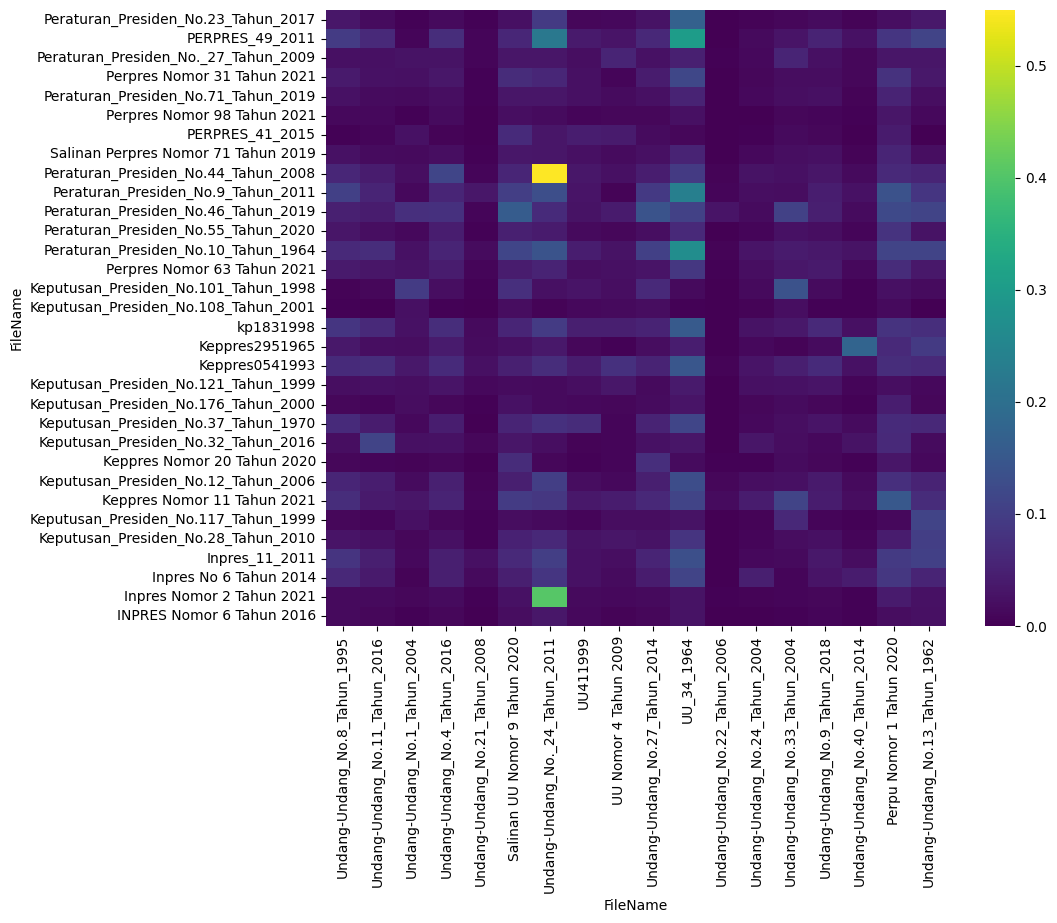

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [64]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                             Undang-Undang_No.8_Tahun_1995  \
FileName                                                             
Peraturan_Presiden_No.23_Tahun_2017                  Tidak Selaras   
PERPRES_49_2011                                      Tidak Selaras   
Peraturan_Presiden_No._27_Tahun_2009                 Tidak Selaras   
Perpres Nomor 31 Tahun 2021                          Tidak Selaras   
Peraturan_Presiden_No.71_Tahun_2019                  Tidak Selaras   
Perpres Nomor 98 Tahun 2021                          Tidak Selaras   
PERPRES_41_2015                                      Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019                  Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008                  Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011                          Netral   
Peraturan_Presiden_No.46_Tahun_2019                  Tidak Selaras   
Peraturan_Presiden_No.55_Tahun_2020                  Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964                  Tidak Selaras   
Perpres Nomor 63 Tahun 2021                          Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998                 Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001                 Tidak Selaras   
kp1831998                                            Tidak Selaras   
Keppres2951965                                       Tidak Selaras   
Keppres0541993                                       Tidak Selaras   
Keputusan_Presiden_No.121_Tahun_1999                 Tidak Selaras   
Keputusan_Presiden_No.176_Tahun_2000                 Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970                  Tidak Selaras   
Keputusan_Presiden_No.32_Tahun_2016                  Tidak Selaras   
Keppres Nomor 20 Tahun 2020                          Tidak Selaras   
Keputusan_Presiden_No.12_Tahun_2006                  Tidak Selaras   
Keppres Nomor 11 Tahun 2021                          Tidak Selaras   
Keputusan_Presiden_No.117_Tahun_1999                 Tidak Selaras   
Keputusan_Presiden_No.28_Tahun_2010                  Tidak Selaras   
Inpres_11_2011                                       Tidak Selaras   
Inpres No 6 Tahun 2014                               Tidak Selaras   
Inpres Nomor 2 Tahun 2021                            Tidak Selaras   
INPRES Nomor 6 Tahun 2016                            Tidak Selaras   

FileName                             Undang-Undang_No.11_Tahun_2016  \
FileName                                                              
Peraturan_Presiden_No.23_Tahun_2017                   Tidak Selaras   
PERPRES_49_2011                                       Tidak Selaras   
Peraturan_Presiden_No._27_Tahun_2009                  Tidak Selaras   
Perpres Nomor 31 Tahun 2021                           Tidak Selaras   
Peraturan_Presiden_No.71_Tahun_2019                   Tidak Selaras   
Perpres Nomor 98 Tahun 2021                           Tidak Selaras   
PERPRES_41_2015                                       Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019                   Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008                   Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011                    Tidak Selaras   
Peraturan_Presiden_No.46_Tahun_2019                   Tidak Selaras   
Peraturan_Presiden_No.55_Tahun_2020                   Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964                   Tidak Selaras   
Perpres Nomor 63 Tahun 2021                           Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998                  Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001                  Tidak Selaras   
kp1831998                                             Tidak Selaras   
Keppres2951965                                        Tidak Selaras   
Keppres0541993                                        Tidak Selaras   
Keputusan_Presiden_No.121_Tahun_1999                  Tidak Selaras   
Keputusan_Presiden_No.176_Tahun_2000                  Tid

### Total

In [65]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          38.0
Selaras          2.0
Tidak Selaras  536.0

### Peraturan Peraturan Presiden dan UU_Perpu yang Selaras

In [66]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                     Perundangan2
0  Peraturan_Presiden_No.44_Tahun_2008  Undang-Undang_No._24_Tahun_2011
1            Inpres Nomor 2 Tahun 2021  Undang-Undang_No._24_Tahun_2011

In [67]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [68]:
df_selaras

Perundangan1                     Perundangan2  \
0  Peraturan_Presiden_No.44_Tahun_2008  Undang-Undang_No._24_Tahun_2011   
1            Inpres Nomor 2 Tahun 2021  Undang-Undang_No._24_Tahun_2011   

                                              Topic1  \
0  tetap atur presiden susun organisasi tata kerj...   
1                        presiden republik indonesia   

                                        Topic2  
0  undang undang badan selenggara jamin sosial  
1  undang undang badan selenggara jamin sosial

In [69]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3                               PP_55_2015   
4    Peraturan_Pemerintah_No.73_Tahun_1992   
5    Peraturan_Pemerintah_No.73_Tahun_2016   
6      Peraturan_Presiden_No.44_Tahun_2008   
7                Inpres Nomor 2 Tahun 2021   
8                Inpres Nomor 2 Tahun 2021   
9      Peraturan_Presiden_No.44_Tahun_2008   
10               Inpres Nomor 2 Tahun 2021   

                             Perundangan2  \
0         Undang-Undang_No._24_Tahun_2011   
1           Undang-Undang_No.8_Tahun_1995   
2           Undang-Undang_No.4_Tahun_2016   
3         Undang-Undang_No._24_Tahun_2011   
4          Undang-Undang_No.40_Tahun_2014   
5         Undang-Undang_No._24_Tahun_2011   
6   Peraturan_Pemerintah_No.73_Tahun_2016   
7   Peraturan_Pemerintah_No.99_Tahun_2013   
8   Peraturan_Pemerintah_No.73_Tahun_2016   
9         Undang-Undang_No._24_Tahun_2011   
10        Undang-Undang_No._24_Tahun_2011   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3                         presiden republik indonesia   
4         atur perintah republik indonesia selenggara   
5   atur perintah pajak hasil program jamin sosial...   
6   tetap atur presiden susun organisasi tata kerj...   
7                         presiden republik indonesia   
8                         presiden republik indonesia   
9   tetap atur presiden susun organisasi tata kerj...   
10                        presiden republik indonesia   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4                        tetap undang undang asuransi  
5         undang undang badan selenggara jamin sosial  
6   atur perintah pajak hasil program jamin sosial...  
7                          tetap atur perintah kelola  
8   atur perintah pajak hasil program jamin sosial...  
9         undang undang badan selenggara jamin sosial  
10        undang undang badan selenggara jamin sosial

## UU_Perpu vs Peraturan Menteri

In [70]:
selected_df = df.query('Tingkatan == "Peraturan Menteri" or Tingkatan == "UU_Perpu"')
selected_df.tail()

Tingkatan                        FileName  \
103  UU_Perpu  Undang-Undang_No.33_Tahun_2004   
104  UU_Perpu   Undang-Undang_No.9_Tahun_2018   
105  UU_Perpu  Undang-Undang_No.40_Tahun_2014   
106  UU_Perpu        Perpu Nomor 1 Tahun 2020   
107  UU_Perpu  Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  \
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...   
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...   
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...   
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...   
107  :\n\nMenetapkan : Undang-undang tentang CKeten...   

                                          cleaned_text  \
103  [tetap undang undang imbang uang perintah pusa...   
104  [tetap undang undang terima negara pajak, teri...   
105  [tetap undang undang asuransi, presiden republ...   
106  [atur perintah ganti undang undang bijak uang ...   
107  [tetap undang undang cketentuan tentu pokok ba...   

                                            final_text  
103  tetap undang undang imbang uang perintah pusat...  
104  tetap undang undang terima negara pajak terima...  
105  tetap undang undang asuransi presiden republik...  
106  atur perintah ganti undang undang bijak uang n...  
107  tetap undang undang cketentuan tentu pokok ban...

In [71]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 500)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [72]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(43, 500)


In [73]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 puluh' '00 ratus' '00 triliun' '000 00' '000 00 puluh' '000 00 ratus'
 '000 00 triliun' '000 000' '000 000 00' '000 000 000' '10 puluh'
 '20 puluh' '2015 no' '2015 no 1785' '34 aval' '34 aval lalitt'
 'aksud ayat' 'akuntan publik' 'akuntansi lapor' 'akuntansi lapor uang'
 'alokasi anggar' 'ampun pajak' 'anggar 2015' 'anggar 2021'
 'anggar anggar' 'anggar belanja' 'anggar dapat' 'anggar dapat belanja'
 'anggar didik' 'anggar menteri' 'anggar satu' 'anggar satu kerja'
 'anggota dewan' 'anggota dewan awas' 'anggota dewan komisioner'
 'anggota direksi' 'apbn anggar' 'arsip dinamis' 'asisten deputi'
 'asuransi syariah' 'asuransi syariah usaha' 'asuransi usaha'
 'asuransi usaha asuransi' 'asuransi wajib' 'atur atur'
 'atur atur menteri' 'atur atur otoritas' 'atur atur perintah' 'atur bank'
 'atur bank indonesia' 'atur daerah' 'atur daerah apbd' 'atur laksana'
 'atur menteri' 'atur menteri uang' 'atur otoritas' 'atur otoritas jasa'
 'atur perintah' 'atur presiden' 'atur un

### Document-Term Matrix

In [74]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 puluh  00 ratus  \
FileName                                                                 
PERMEN_KEU_231PMK062017_2017                        0.000000  0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.000000  0.010518   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000  0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000  0.000000   
KEPMEN_DAGRI_29_2002                                0.000000  0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000  0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000  0.000000   
KEPMNG_LH_9_2001                                    0.000000  0.000000   
PERMEN_DAGRI_52_2012                                0.000000  0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000  0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000  0.000000   
PERMEN_KEU_209PMK052015_2015                        0.000000  0.000000   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000  0.000000   
PERMEN_KOMARVES_6_2020                              0.000000  0.000000   
pmmarves001_2022                                    0.000000  0.000000   
PERMEN_KEU_119PMK082016_2016                        0.000000  0.020635   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000  0.000000   
1_PMK.05_2021                                       0.000000  0.000000   
PERMEN_KEU_50PMK0102019_2019                        0.096340  0.088867   
pmmarves002_2021                                    0.000000  0.000000   
PERMEN_PERIN_64MINDPER72016_2016                    0.000000  0.000000   
KEPMGK_INVBKPM_12SK1999_1999                        0.000000  0.000000   
KEPMGK_INVBKPM_33SK1998_1998                        0.000000  0.000000   
KEPMGK_INVBKPM_38SK1999_1999                        0.000000  0.000000   
PERMEN_KEU_53PMK052020_2020                         0.000000  0.000000   
Undang-Undang_No.8_Tahun_1995                       0.000000  0.000000   
Undang-Undang_No.11_Tahun_2016                      0.014573  0.000000   
Undang-Undang_No.1_Tahun_2004                       0.025168  0.023216   
Undang-Undang_No.4_Tahun_2016                       0.000000  0.000000   
Undang-Undang_No.21_Tahun_2008                      0.008864  0.016353   
Salinan UU Nomor 9 Tahun 2020                       0.054849  0.067460   
Undang-Undang_No._24_Tahun_2011                     0.000000  0.020314   
UU411999                                            0.000000  0.000000   
UU Nomor 4 Tahun 2009                               0.003612  0.003332   
Undang-Undang_No.27_Tahun_2014                      0.054416  0.066926   
UU_34_1964                                          0.000000  0.000000   
Undang-Undang_No.22_Tahun_2006                      0.000000  0.000000   
Undang-Undang_No.24_Tahun_2004                      0.000000  0.006301   
Undang-Undang_No.33_Tahun_2004                      0.000000  0.000000   
Undang-Undang_No.9_Tahun_2018                       0.003606  0.000000   
Undang-Undang_No.40_Tahun_2014                      0.000000  0.000000   
Perpu Nomor 1 Tahun 2020                            0.000000  0.000000   
Undang-Undang_No.13_Tahun_1962                      0.000000  0.000000   

                                                    00 triliun    000 00  \
FileName                                                                   
PERMEN_KEU_231PMK062017_2017                          0.000000  0.000000   
KEPMEN_KEU_511KMK062002_2002                          0.000000  0.008347   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                 0.000000  0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                   0.000000  0.000000   
KEPMEN_DAGRI_29_2002                                  0.000000  0.000000   
KEPMEN_KEU_509KMK062002_2002                          0.000000  0.000000   
PERMEN_KEU_103PMK052019_2019                          0.000000  0.000000   
KEPMNG_LH_9_2001                     

### Calculate the similarity

In [75]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName'
PM_file_names = df[df['Tingkatan'] == 'Peraturan Menteri']['FileName'].values

# Filter the 'FileName'
UU_file_names = df[df['Tingkatan'] == 'UU_Perpu']['FileName'].values

In [76]:
filtered_df = cosine_similarity_df[UU_file_names]
filtered_df = filtered_df.loc[PM_file_names]
filtered_df

FileName                                            Undang-Undang_No.8_Tahun_1995  \
FileName                                                                            
PERMEN_KEU_231PMK062017_2017                                             0.006612   
KEPMEN_KEU_511KMK062002_2002                                             0.056712   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                    0.000141   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                      0.016080   
KEPMEN_DAGRI_29_2002                                                     0.017449   
KEPMEN_KEU_509KMK062002_2002                                             0.020332   
PERMEN_KEU_103PMK052019_2019                                             0.020692   
KEPMNG_LH_9_2001                                                         0.003151   
PERMEN_DAGRI_52_2012                                                     0.012392   
PERMEN_KEU_91PMK012017_2017                                              0.037173   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                       0.013972   
PERMEN_KEU_209PMK052015_2015                                             0.006789   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                       0.074201   
PERMEN_KOMARVES_6_2020                                                   0.032256   
pmmarves001_2022                                                         0.019470   
PERMEN_KEU_119PMK082016_2016                                             0.144995   
Keputusan Menteri_KP_45_Tahun_2015                                       0.024657   
1_PMK.05_2021                                                            0.006480   
PERMEN_KEU_50PMK0102019_2019                                             0.067978   
pmmarves002_2021                                                         0.016748   
PERMEN_PERIN_64MINDPER72016_2016                                         0.023568   
KEPMGK_INVBKPM_12SK1999_1999                                             0.000000   
KEPMGK_INVBKPM_33SK1998_1998                                             0.000000   
KEPMGK_INVBKPM_38SK1999_1999                                             0.017863   
PERMEN_KEU_53PMK052020_2020                                              0.000000   

FileName                                            Undang-Undang_No.11_Tahun_2016  \
FileName                                                                             
PERMEN_KEU_231PMK062017_2017                                              0.008159   
KEPMEN_KEU_511KMK062002_2002                                              0.024007   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                     0.001021   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                       0.008657   
KEPMEN_DAGRI_29_2002                                                      0.020269   
KEPMEN_KEU_509KMK062002_2002                                              0.024699   
PERMEN_KEU_103PMK052019_2019                                              0.024177   
KEPMNG_LH_9_2001                                                          0.005909   
PERMEN_DAGRI_52_2012                                                      0.013651   
PERMEN_KEU_91PMK012017_2017                                               0.046547   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                        0.018096   
PERMEN_KEU_209PMK052015_2015                                              0.013010   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                        0.060793   
PERMEN_KOMARVES_6_2020                                                    0.027011   
pmmarves001_2022                                                          0.029564   
PERMEN_KEU_119PMK082016_2016                                              0.632938   
Keputusan Menteri_KP_45_Tahun_2015                                        0.041805   
1_PMK.05_2021                                                         

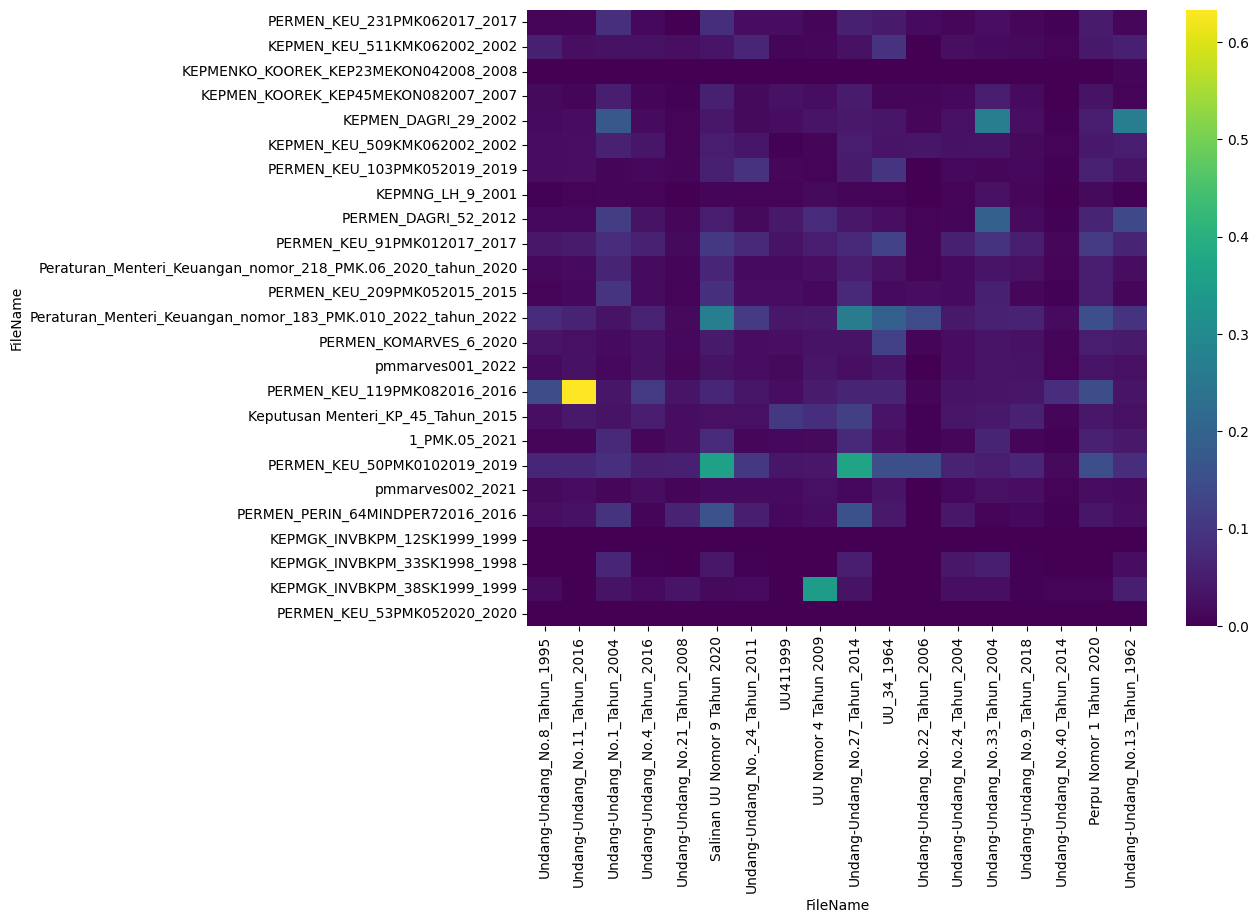

In [77]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [78]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                                           Undang-Undang_No.8_Tahun_1995  \
FileName                                                                           
PERMEN_KEU_231PMK062017_2017                                       Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                                       Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                              Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                Tidak Selaras   
KEPMEN_DAGRI_29_2002                                               Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                       Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                       Tidak Selaras   
KEPMNG_LH_9_2001                                                   Tidak Selaras   
PERMEN_DAGRI_52_2012                                               Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                        Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                 Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                       Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                 Tidak Selaras   
PERMEN_KOMARVES_6_2020                                             Tidak Selaras   
pmmarves001_2022                                                   Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                              Netral   
Keputusan Menteri_KP_45_Tahun_2015                                 Tidak Selaras   
1_PMK.05_2021                                                      Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                       Tidak Selaras   
pmmarves002_2021                                                   Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2016                                   Tidak Selaras   
KEPMGK_INVBKPM_12SK1999_1999                                       Tidak Selaras   
KEPMGK_INVBKPM_33SK1998_1998                                       Tidak Selaras   
KEPMGK_INVBKPM_38SK1999_1999                                       Tidak Selaras   
PERMEN_KEU_53PMK052020_2020                                        Tidak Selaras   

FileName                                           Undang-Undang_No.11_Tahun_2016  \
FileName                                                                            
PERMEN_KEU_231PMK062017_2017                                        Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                                        Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                               Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                 Tidak Selaras   
KEPMEN_DAGRI_29_2002                                                Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                        Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                        Tidak Selaras   
KEPMNG_LH_9_2001                                                    Tidak Selaras   
PERMEN_DAGRI_52_2012                                                Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                         Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                  Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                        Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                  Tidak Selaras   
PERMEN_KOMARVES_6_2020                                              Tidak Selaras   
pmmarves001_2022                                                    Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                              Selaras   
Keputusan Menteri_KP_45_Tahun_2015                                  Tidak Selaras   
1_PMK.05_2021                                                       Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019   

### Total

In [79]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          30.0
Selaras          1.0
Tidak Selaras  419.0

### Peraturan UU_Perpu dan Peraturan Menteri yang Selaras

In [80]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                    Perundangan2
0  PERMEN_KEU_119PMK082016_2016  Undang-Undang_No.11_Tahun_2016

In [81]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [82]:
df_selaras

Perundangan1                    Perundangan2  \
0  PERMEN_KEU_119PMK082016_2016  Undang-Undang_No.11_Tahun_2016   

                   Topic1                     Topic2  
0  atur menteri uang tata  undang undang ampun pajak

In [83]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3                               PP_55_2015   
4    Peraturan_Pemerintah_No.73_Tahun_1992   
5    Peraturan_Pemerintah_No.73_Tahun_2016   
6      Peraturan_Presiden_No.44_Tahun_2008   
7                Inpres Nomor 2 Tahun 2021   
8                Inpres Nomor 2 Tahun 2021   
9      Peraturan_Presiden_No.44_Tahun_2008   
10               Inpres Nomor 2 Tahun 2021   
11            PERMEN_KEU_119PMK082016_2016   

                             Perundangan2  \
0         Undang-Undang_No._24_Tahun_2011   
1           Undang-Undang_No.8_Tahun_1995   
2           Undang-Undang_No.4_Tahun_2016   
3         Undang-Undang_No._24_Tahun_2011   
4          Undang-Undang_No.40_Tahun_2014   
5         Undang-Undang_No._24_Tahun_2011   
6   Peraturan_Pemerintah_No.73_Tahun_2016   
7   Peraturan_Pemerintah_No.99_Tahun_2013   
8   Peraturan_Pemerintah_No.73_Tahun_2016   
9         Undang-Undang_No._24_Tahun_2011   
10        Undang-Undang_No._24_Tahun_2011   
11         Undang-Undang_No.11_Tahun_2016   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3                         presiden republik indonesia   
4         atur perintah republik indonesia selenggara   
5   atur perintah pajak hasil program jamin sosial...   
6   tetap atur presiden susun organisasi tata kerj...   
7                         presiden republik indonesia   
8                         presiden republik indonesia   
9   tetap atur presiden susun organisasi tata kerj...   
10                        presiden republik indonesia   
11                             atur menteri uang tata   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4                        tetap undang undang asuransi  
5         undang undang badan selenggara jamin sosial  
6   atur perintah pajak hasil program jamin sosial...  
7                          tetap atur perintah kelola  
8   atur perintah pajak hasil program jamin sosial...  
9         undang undang badan selenggara jamin sosial  
10        undang undang badan selenggara jamin sosial  
11                          undang undang ampun pajak

## Peraturan Pemerintah vs Peraturan Menteri

In [84]:
selected_df = df.query('Tingkatan == "Peraturan Menteri" or Tingkatan == "Peraturan Pemerintah"')
selected_df.tail()

Tingkatan                          FileName  \
85  Peraturan Menteri  PERMEN_PERIN_64MINDPER72016_2016   
86  Peraturan Menteri      KEPMGK_INVBKPM_12SK1999_1999   
87  Peraturan Menteri      KEPMGK_INVBKPM_33SK1998_1998   
88  Peraturan Menteri      KEPMGK_INVBKPM_38SK1999_1999   
89  Peraturan Menteri       PERMEN_KEU_53PMK052020_2020   

                                        ExtractedText  \
85  :\n\nPERATURAN MENTERI PERINDUSTRIAN TENTANG B...   
86  :\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INVES...   
87  :\n\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INV...   
88  MENETAPKAN:\nKEPUTUSAN MENTERI NEGARA INVESTAS...   
89  :\n\nMenetapkan       :        PERATURAN MENTE...   

                                         cleaned_text  \
85  [atur menteri industri besar tenaga kerja nila...   
86                                                 []   
87  [tetap putus menteri negara investasi kepala b...   
88  [tetap putus menteri negara investasi kepala b...   
89                                                 []   

                                           final_text  
85  atur menteri industri besar tenaga kerja nilai...  
86                                                     
87  tetap putus menteri negara investasi kepala ba...  
88  tetap putus menteri negara investasi kepala ba...  
89

In [85]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 500)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [86]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(58, 500)


In [87]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 ratus' '000 00' '000 00 ratus' '000 000' '000 000 00' '000 000 000'
 '10 puluh' '10 puluh persen' '15 belas' '20 puluh' '20 puluh persen'
 '2015 no' '2015 no 1785' '34 aval' '34 aval lalitt' '50 puluh'
 '50 puluh persen' 'agun aset' 'akuntan publik' 'akuntansi lapor'
 'akuntansi lapor uang' 'akuntansi uang' 'alokasi anggar'
 'alokasi anggar perintah' 'anggar dapat' 'anggar dapat belanja'
 'anggar perintah' 'anggar satu' 'anggar satu kerja' 'anggar tahun'
 'anggota direksi' 'antara dagang' 'antara dagang efek' 'arsip dinamis'
 'aset bersih' 'aset bpjs' 'aset bpjs ketenagakerjaan' 'aset dana'
 'aset dana jamin' 'asisten deputi' 'asuransi jiwa' 'asuransi usaha'
 'atur atur' 'atur atur menteri' 'atur daerah' 'atur laksana'
 'atur menteri' 'atur menteri uang' 'atur perintah' 'atur perintah atur'
 'atur perintah laku' 'atur perintah nomor' 'atur perintah tempat'
 'atur undang' 'atur undang undang' 'aval lalitt' 'aval lalitt maelii'
 'awas internal' 'ayat atur' 'ayat atur 

### Document-Term Matrix

In [88]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 ratus    000 00  \
FileName                                                                 
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019               0.000000  0.011165   
Peraturan_Pemerintah_No.1_Tahun_2008                0.000000  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                0.000000  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019               0.000000  0.000000   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000  0.000000   
2021pp049                                           0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1996               0.000000  0.000000   
Peraturan_Pemerintah_No._49_Tahun_2011              0.000000  0.000000   
Peraturan_Pemerintah_No.75_Tahun_1992               0.000000  0.000000   
Peraturan_Pemerintah_No.99_Tahun_2013               0.000000  0.000000   
Peraturan_Pemerintah_No.5_Tahun_2018                0.000000  0.000000   
Peraturan_Pemerintah_No.77_Tahun_1992               0.000000  0.000000   
Peraturan_Pemerintah_No._45_Tahun_1995              0.153723  0.284924   
Peraturan_Pemerintah_No.25_Tahun_2020               0.000000  0.000000   
Peraturan_Pemerintah_No.48_Tahun_2008               0.000000  0.000000   
Peraturan_Pemerintah_No.18_Tahun_1983               0.000000  0.000000   
Peraturan_Pemerintah_No.30_Tahun_1982               0.000000  0.000000   
Peraturan_Pemerintah_No.53_Tahun_2018               0.000000  0.000000   
PP_55_2015                                          0.000000  0.000000   
Peraturan_Pemerintah_No.49_Tahun_2017               0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1984               0.000000  0.000000   
Peraturan_Pemerintah_No.107_Tahun_2015              0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_2013               0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_1992               0.000000  0.000000   
2022pp031                                           0.000000  0.000000   
PP Nomor 93 Tahun 2021                              0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_2016               0.000000  0.000000   
PP_27_1985                                          0.000000  0.000000   
Peraturan_Pemerintah_No.54_Tahun_1993               0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_1993               0.000000  0.000000   
Peraturan_Pemerintah_No.105_Tahun_2000              0.000000  0.000000   
Peraturan_Pemerintah_No.40_Tahun_2000               0.000000  0.000000   
PERMEN_KEU_231PMK062017_2017                        0.000000  0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.014607  0.013190   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000  0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000  0.000000   
KEPMEN_DAGRI_29_2002                                0.000000  0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000  0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000  0.000000   
KEPMNG_LH_9_2001                                    0.000000  0.000000   
PERMEN_DAGRI_52_2012                                0.000000  0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000  0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000  0.000000   
PERMEN_KEU_209PMK052015_2015                        0.000000  0.000000   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000  0.000000   
PERMEN_KOMARVES_6_2020                              0.000000  0.000000   
pmmarves001_2022                                    0.000000  0.000000   
PERMEN_KEU_119PMK082016_2016                        0.032136  0.058037   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000  0.000000   
1_PMK.05_2021                                       0.000000  0.000000   
PERMEN_KEU_50PMK0102019_2019                        0.117635  0.318667   
pmmarves002_2021                                    0.00

### Calculate the similarity

In [89]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName'
PM_file_names = df[df['Tingkatan'] == 'Peraturan Menteri']['FileName'].values

# Filter the 'FileName'
PP_file_names = df[df['Tingkatan'] == 'Peraturan Pemerintah']['FileName'].values

In [90]:
filtered_df = cosine_similarity_df[PP_file_names]
filtered_df = filtered_df.loc[PM_file_names]
filtered_df

FileName                                            PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                              
PERMEN_KEU_231PMK062017_2017                                                                 0.033632                 
KEPMEN_KEU_511KMK062002_2002                                                                 0.032707                 
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                                        0.000987                 
KEPMEN_KOOREK_KEP45MEKON082007_2007                                                          0.015039                 
KEPMEN_DAGRI_29_2002                                                                         0.034904                 
KEPMEN_KEU_509KMK062002_2002                                                                 0.006299                 
PERMEN_KEU_103PMK052019_2019                                                                 0.023774                 
KEPMNG_LH_9_2001                                                                             0.003443                 
PERMEN_DAGRI_52_2012                                                                         0.025284                 
PERMEN_KEU_91PMK012017_2017                                                                  0.025472                 
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                                           0.052794                 
PERMEN_KEU_209PMK052015_2015                                                                 0.022845                 
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                                           0.058508                 
PERMEN_KOMARVES_6_2020                                                                       0.067087                 
pmmarves001_2022                                                                             0.016791                 
PERMEN_KEU_119PMK082016_2016                                                                 0.061003                 
Keputusan Menteri_KP_45_Tahun_2015                                                           0.047523                 
1_PMK.05_2021                                                                                0.003196                 
PERMEN_KEU_50PMK0102019_2019                                                                 0.050469                 
pmmarves002_2021                                                                             0.016546                 
PERMEN_PERIN_64MINDPER72016_2016                                                             0.003326                 
KEPMGK_INVBKPM_12SK1999_1999                                                                 0.000000                 
KEPMGK_INVBKPM_33SK1998_1998                                                                 0.000000                 
KEPMGK_INVBKPM_38SK1999_1999                                                                 0.000000                 
PERMEN_KEU_53PMK052020_2020                                                                  0.000000                 

FileName                                            Peraturan_Pemerintah_No.63_Tahun_2019  \
FileName                                                                                    
PERMEN_KEU_231PMK062017_2017                                                     0.358498   
KEPMEN_KEU_511KMK062002_2002                                                     0.063873   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                            0.000181   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                              0.014860   
KEPMEN_DAGRI_29_2002                                                             0.021456   
KEPMEN_KEU_509KMK062002_2002                                                     0.029449   
PERMEN_KEU_103PMK052019_2019              

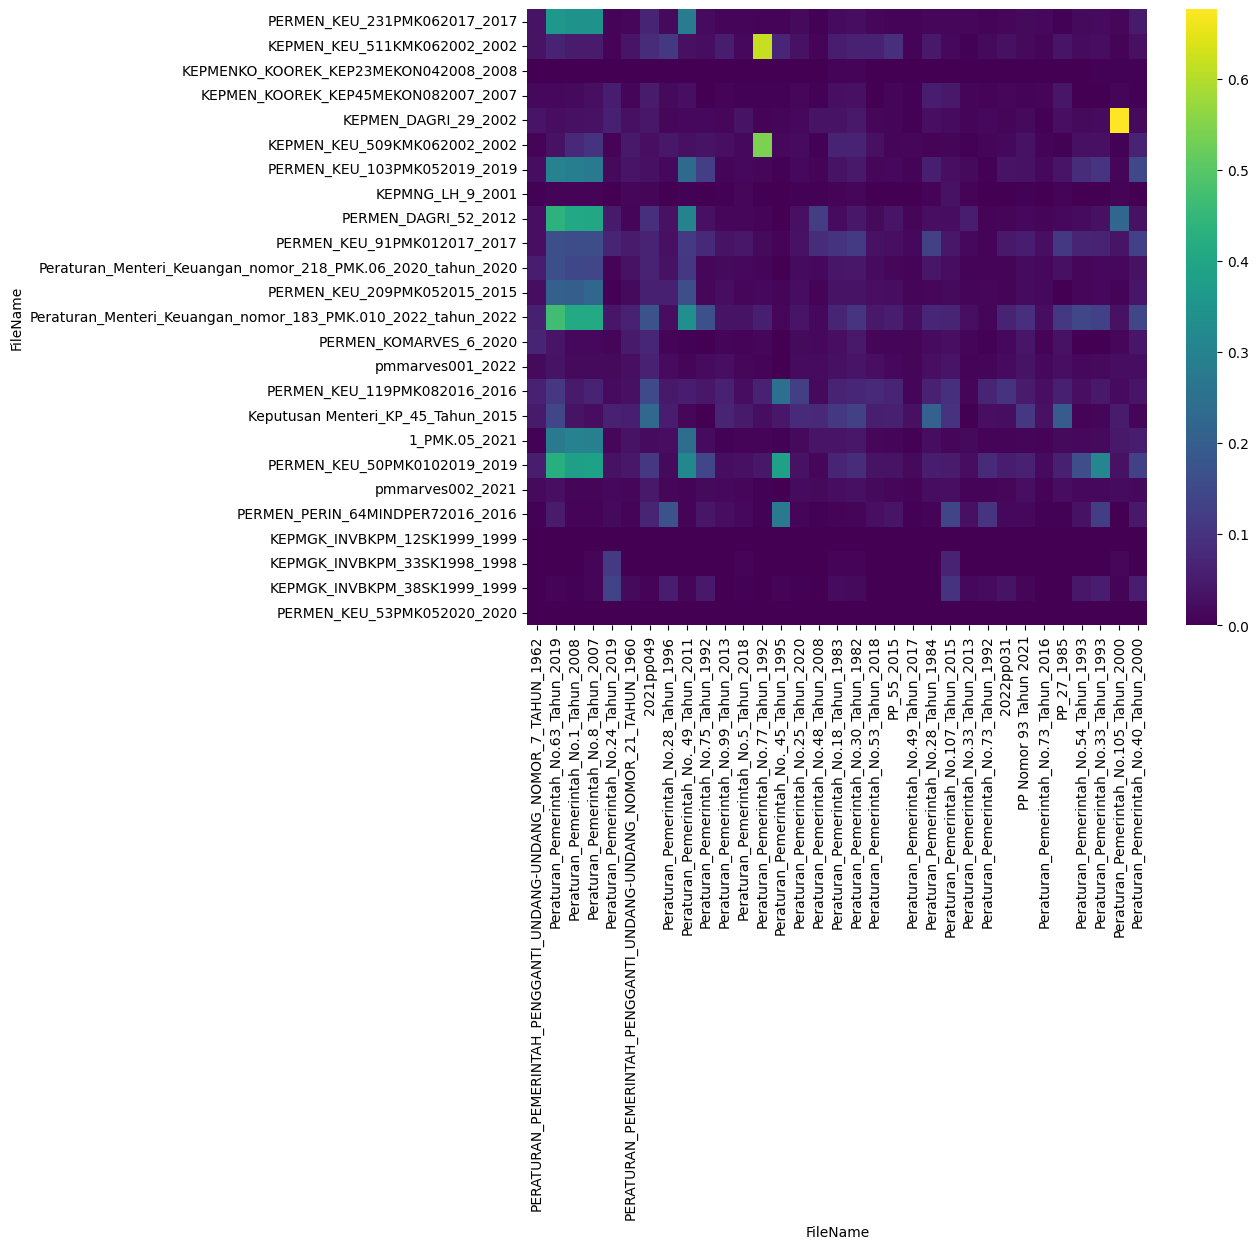

In [91]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [92]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                                           PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                             
PERMEN_KEU_231PMK062017_2017                                                            Tidak Selaras                
KEPMEN_KEU_511KMK062002_2002                                                            Tidak Selaras                
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                                   Tidak Selaras                
KEPMEN_KOOREK_KEP45MEKON082007_2007                                                     Tidak Selaras                
KEPMEN_DAGRI_29_2002                                                                    Tidak Selaras                
KEPMEN_KEU_509KMK062002_2002                                                            Tidak Selaras                
PERMEN_KEU_103PMK052019_2019                                                            Tidak Selaras                
KEPMNG_LH_9_2001                                                                        Tidak Selaras                
PERMEN_DAGRI_52_2012                                                                    Tidak Selaras                
PERMEN_KEU_91PMK012017_2017                                                             Tidak Selaras                
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                                      Tidak Selaras                
PERMEN_KEU_209PMK052015_2015                                                            Tidak Selaras                
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                                      Tidak Selaras                
PERMEN_KOMARVES_6_2020                                                                  Tidak Selaras                
pmmarves001_2022                                                                        Tidak Selaras                
PERMEN_KEU_119PMK082016_2016                                                            Tidak Selaras                
Keputusan Menteri_KP_45_Tahun_2015                                                      Tidak Selaras                
1_PMK.05_2021                                                                           Tidak Selaras                
PERMEN_KEU_50PMK0102019_2019                                                            Tidak Selaras                
pmmarves002_2021                                                                        Tidak Selaras                
PERMEN_PERIN_64MINDPER72016_2016                                                        Tidak Selaras                
KEPMGK_INVBKPM_12SK1999_1999                                                            Tidak Selaras                
KEPMGK_INVBKPM_33SK1998_1998                                                            Tidak Selaras                
KEPMGK_INVBKPM_38SK1999_1999                                                            Tidak Selaras                
PERMEN_KEU_53PMK052020_2020                                                             Tidak Selaras                

FileName                                           Peraturan_Pemerintah_No.63_Tahun_2019  \
FileName                                                                                   
PERMEN_KEU_231PMK062017_2017                                                      Netral   
KEPMEN_KEU_511KMK062002_2002                                               Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                      Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                        Tidak Selaras   
KEPMEN_DAGRI_29_2002                                                       Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                               Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                                 

### Total

In [93]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          70.0
Selaras         10.0
Tidak Selaras  745.0

### Peraturan Peraturan Presiden dan Peraturan Pemerintah yang Selaras

In [94]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1  \
0                       KEPMEN_KEU_511KMK062002_2002   
1                               KEPMEN_DAGRI_29_2002   
2                       KEPMEN_KEU_509KMK062002_2002   
3                               PERMEN_DAGRI_52_2012   
4                               PERMEN_DAGRI_52_2012   
5                               PERMEN_DAGRI_52_2012   
6  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
7  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
8  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
9                       PERMEN_KEU_50PMK0102019_2019   

                             Perundangan2  
0   Peraturan_Pemerintah_No.77_Tahun_1992  
1  Peraturan_Pemerintah_No.105_Tahun_2000  
2   Peraturan_Pemerintah_No.77_Tahun_1992  
3   Peraturan_Pemerintah_No.63_Tahun_2019  
4    Peraturan_Pemerintah_No.1_Tahun_2008  
5    Peraturan_Pemerintah_No.8_Tahun_2007  
6   Peraturan_Pemerintah_No.63_Tahun_2019  
7    Peraturan_Pemerintah_No.1_Tahun_2008  
8    Peraturan_Pemerintah_No.8_Tahun_2007  
9   Peraturan_Pemerintah_No.63_Tahun_2019

In [95]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [96]:
df_selaras

Perundangan1  \
0                       KEPMEN_KEU_511KMK062002_2002   
1                               KEPMEN_DAGRI_29_2002   
2                       KEPMEN_KEU_509KMK062002_2002   
3                               PERMEN_DAGRI_52_2012   
4                               PERMEN_DAGRI_52_2012   
5                               PERMEN_DAGRI_52_2012   
6  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
7  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
8  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
9                       PERMEN_KEU_50PMK0102019_2019   

                             Perundangan2  \
0   Peraturan_Pemerintah_No.77_Tahun_1992   
1  Peraturan_Pemerintah_No.105_Tahun_2000   
2   Peraturan_Pemerintah_No.77_Tahun_1992   
3   Peraturan_Pemerintah_No.63_Tahun_2019   
4    Peraturan_Pemerintah_No.1_Tahun_2008   
5    Peraturan_Pemerintah_No.8_Tahun_2007   
6   Peraturan_Pemerintah_No.63_Tahun_2019   
7    Peraturan_Pemerintah_No.1_Tahun_2008   
8    Peraturan_Pemerintah_No.8_Tahun_2007   
9   Peraturan_Pemerintah_No.63_Tahun_2019   

                                              Topic1  \
0  putus menteri uang investasi dana pensiun ment...   
1  putus menteri negeri pedoman urus pertanggungj...   
2  putus menteri uang lapor uang dana pensiun men...   
3                          tetap atur menteri negeri   
4                          tetap atur menteri negeri   
5                          tetap atur menteri negeri   
6  tetap atur menteri uang tambah investasi perin...   
7  tetap atur menteri uang tambah investasi perin...   
8  tetap atur menteri uang tambah investasi perin...   
9                                  atur menteri uang   

                                              Topic2  
0  tetap atur perintah republik indonesia dana pe...  
1  tetap atur perintah kelola pertanggungjawaban ...  
2  tetap atur perintah republik indonesia dana pe...  
3                   atur perintah investasi perintah  
4                   atur perintah investasi perintah  
5             tetap atur perintah investasi perintah  
6                   atur perintah investasi perintah  
7                   atur perintah investasi perintah  
8             tetap atur perintah investasi perintah  
9                   atur perintah investasi perintah

In [97]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0               Peraturan_Pemerintah_No.99_Tahun_2013   
1              Peraturan_Pemerintah_No._45_Tahun_1995   
2               Peraturan_Pemerintah_No.25_Tahun_2020   
3                                          PP_55_2015   
4               Peraturan_Pemerintah_No.73_Tahun_1992   
5               Peraturan_Pemerintah_No.73_Tahun_2016   
6                 Peraturan_Presiden_No.44_Tahun_2008   
7                           Inpres Nomor 2 Tahun 2021   
8                           Inpres Nomor 2 Tahun 2021   
9                 Peraturan_Presiden_No.44_Tahun_2008   
10                          Inpres Nomor 2 Tahun 2021   
11                       PERMEN_KEU_119PMK082016_2016   
12                       KEPMEN_KEU_511KMK062002_2002   
13                               KEPMEN_DAGRI_29_2002   
14                       KEPMEN_KEU_509KMK062002_2002   
15                               PERMEN_DAGRI_52_2012   
16                               PERMEN_DAGRI_52_2012   
17                               PERMEN_DAGRI_52_2012   
18  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
19  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
20  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
21                       PERMEN_KEU_50PMK0102019_2019   

                              Perundangan2  \
0          Undang-Undang_No._24_Tahun_2011   
1            Undang-Undang_No.8_Tahun_1995   
2            Undang-Undang_No.4_Tahun_2016   
3          Undang-Undang_No._24_Tahun_2011   
4           Undang-Undang_No.40_Tahun_2014   
5          Undang-Undang_No._24_Tahun_2011   
6    Peraturan_Pemerintah_No.73_Tahun_2016   
7    Peraturan_Pemerintah_No.99_Tahun_2013   
8    Peraturan_Pemerintah_No.73_Tahun_2016   
9          Undang-Undang_No._24_Tahun_2011   
10         Undang-Undang_No._24_Tahun_2011   
11          Undang-Undang_No.11_Tahun_2016   
12   Peraturan_Pemerintah_No.77_Tahun_1992   
13  Peraturan_Pemerintah_No.105_Tahun_2000   
14   Peraturan_Pemerintah_No.77_Tahun_1992   
15   Peraturan_Pemerintah_No.63_Tahun_2019   
16    Peraturan_Pemerintah_No.1_Tahun_2008   
17    Peraturan_Pemerintah_No.8_Tahun_2007   
18   Peraturan_Pemerintah_No.63_Tahun_2019   
19    Peraturan_Pemerintah_No.1_Tahun_2008   
20    Peraturan_Pemerintah_No.8_Tahun_2007   
21   Peraturan_Pemerintah_No.63_Tahun_2019   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3                         presiden republik indonesia   
4         atur perintah republik indonesia selenggara   
5   atur perintah pajak hasil program jamin sosial...   
6   tetap atur presiden susun organisasi tata kerj...   
7                         presiden republik indonesia   
8                         presiden republik indonesia   
9   tetap atur presiden susun organisasi tata kerj...   
10                        presiden republik indonesia   
11                             atur menteri uang tata   
12  putus menteri uang investasi dana pensiun ment...   
13  putus menteri negeri pedoman urus pertanggungj...   
14  putus menteri uang lapor uang dana pensiun men...   
15                          tetap atur menteri negeri   
16                          tetap atur menteri negeri   
17                          tetap atur menteri negeri   
18  tetap atur menteri uang tambah investasi perin...   
19  tetap atur menteri uang tambah investasi perin...   
20  tetap atur menteri uang tambah investasi perin...   
21                                  atur menteri uang   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4                        tetap undang undang asuransi  
5         undang undan

## Peraturan Presiden vs Peraturan Menteri

In [98]:
selected_df = df.query('Tingkatan == "Peraturan Menteri" or Tingkatan == "Peraturan Presiden"')
selected_df.tail()

Tingkatan                          FileName  \
85  Peraturan Menteri  PERMEN_PERIN_64MINDPER72016_2016   
86  Peraturan Menteri      KEPMGK_INVBKPM_12SK1999_1999   
87  Peraturan Menteri      KEPMGK_INVBKPM_33SK1998_1998   
88  Peraturan Menteri      KEPMGK_INVBKPM_38SK1999_1999   
89  Peraturan Menteri       PERMEN_KEU_53PMK052020_2020   

                                        ExtractedText  \
85  :\n\nPERATURAN MENTERI PERINDUSTRIAN TENTANG B...   
86  :\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INVES...   
87  :\n\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INV...   
88  MENETAPKAN:\nKEPUTUSAN MENTERI NEGARA INVESTAS...   
89  :\n\nMenetapkan       :        PERATURAN MENTE...   

                                         cleaned_text  \
85  [atur menteri industri besar tenaga kerja nila...   
86                                                 []   
87  [tetap putus menteri negara investasi kepala b...   
88  [tetap putus menteri negara investasi kepala b...   
89                                                 []   

                                           final_text  
85  atur menteri industri besar tenaga kerja nilai...  
86                                                     
87  tetap putus menteri negara investasi kepala ba...  
88  tetap putus menteri negara investasi kepala ba...  
89

In [99]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 500)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [100]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(57, 500)


In [101]:
print("Feature Names:")
print(feature_names)

Feature Names:
['2015 no' '2015 no 1785' '34 aval' '34 aval lalitt' 'ahli bidang'
 'aktif program' 'aktif program jamin' 'akuntan publik' 'akuntansi lapor'
 'akuntansi lapor uang' 'alat sehat' 'ampun pajak' 'analisis evaluasi'
 'anggar dapat' 'anggar dapat belanja' 'anggar satu' 'anggar satu kerja'
 'aparatur negara' 'arsip dinamis' 'asisten deputi' 'atur atur'
 'atur daerah' 'atur menteri' 'atur menteri uang' 'atur presiden'
 'atur presiden laku' 'atur presiden nomor' 'atur undang'
 'atur undang undang' 'aval lalitt' 'aval lalitt maelii' 'ayat atur'
 'ayat ayat' 'ayat cantum' 'ayat cantum lampir' 'ayat huruf' 'ayat tetap'
 'ba bun' 'badan koordinasi' 'badan koordinasi tanam' 'badan layan'
 'badan usaha' 'badan usaha milik' 'bahan koordinasi'
 'bahan koordinasi telaah' 'bahan rancang' 'bahan rancang rumus'
 'bangun manusia' 'bangun manusia budaya' 'bangun nasional'
 'baseline emisi' 'baseline emisi grk' 'beban anggar' 'belanja daerah'
 'belanja negara' 'bendahara negara' 'beri dukung'


### Document-Term Matrix

In [102]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

2015 no  2015 no 1785  \
FileName                                                                     
Peraturan_Presiden_No.23_Tahun_2017                 0.000000      0.000000   
PERPRES_49_2011                                     0.000000      0.000000   
Peraturan_Presiden_No._27_Tahun_2009                0.000000      0.000000   
Perpres Nomor 31 Tahun 2021                         0.000000      0.000000   
Peraturan_Presiden_No.71_Tahun_2019                 0.000000      0.000000   
Perpres Nomor 98 Tahun 2021                         0.000000      0.000000   
PERPRES_41_2015                                     0.000000      0.000000   
Salinan Perpres Nomor 71 Tahun 2019                 0.000000      0.000000   
Peraturan_Presiden_No.44_Tahun_2008                 0.000000      0.000000   
Peraturan_Presiden_No.9_Tahun_2011                  0.000000      0.000000   
Peraturan_Presiden_No.46_Tahun_2019                 0.000000      0.000000   
Peraturan_Presiden_No.55_Tahun_2020                 0.000000      0.000000   
Peraturan_Presiden_No.10_Tahun_1964                 0.000000      0.000000   
Perpres Nomor 63 Tahun 2021                         0.000000      0.000000   
Keputusan_Presiden_No.101_Tahun_1998                0.000000      0.000000   
Keputusan_Presiden_No.108_Tahun_2001                0.000000      0.000000   
kp1831998                                           0.000000      0.000000   
Keppres2951965                                      0.000000      0.000000   
Keppres0541993                                      0.000000      0.000000   
Keputusan_Presiden_No.121_Tahun_1999                0.000000      0.000000   
Keputusan_Presiden_No.176_Tahun_2000                0.000000      0.000000   
Keputusan_Presiden_No.37_Tahun_1970                 0.000000      0.000000   
Keputusan_Presiden_No.32_Tahun_2016                 0.000000      0.000000   
Keppres Nomor 20 Tahun 2020                         0.000000      0.000000   
Keputusan_Presiden_No.12_Tahun_2006                 0.000000      0.000000   
Keppres Nomor 11 Tahun 2021                         0.000000      0.000000   
Keputusan_Presiden_No.117_Tahun_1999                0.000000      0.000000   
Keputusan_Presiden_No.28_Tahun_2010                 0.000000      0.000000   
Inpres_11_2011                                      0.000000      0.000000   
Inpres No 6 Tahun 2014                              0.000000      0.000000   
Inpres Nomor 2 Tahun 2021                           0.000000      0.000000   
INPRES Nomor 6 Tahun 2016                           0.000000      0.000000   
PERMEN_KEU_231PMK062017_2017                        0.000000      0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.000000      0.000000   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000      0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000      0.000000   
KEPMEN_DAGRI_29_2002                                0.000000      0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000      0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000      0.000000   
KEPMNG_LH_9_2001                                    0.000000      0.000000   
PERMEN_DAGRI_52_2012                                0.000000      0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000      0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000      0.000000   
PERMEN_KEU_209PMK052015_2015                        0.355441      0.355441   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000      0.000000   
PERMEN_KOMARVES_6_2020                              0.000000      0.000000   
pmmarves001_2022                                    0.000000      0.000000   
PERMEN_KEU_119PMK082016_2016                        0.000000      0.000000   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000      0.000000   
1_PMK.05_2021                                       0.000000      0.000000 

### Calculate the similarity

In [103]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName'
PM_file_names = df[df['Tingkatan'] == 'Peraturan Menteri']['FileName'].values

# Filter the 'FileName'
PP_file_names = df[df['Tingkatan'] == 'Peraturan Presiden']['FileName'].values

In [104]:
filtered_df = cosine_similarity_df[PP_file_names]
filtered_df = filtered_df.loc[PM_file_names]
filtered_df

FileName                                            Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                                  
PERMEN_KEU_231PMK062017_2017                                                   0.006770   
KEPMEN_KEU_511KMK062002_2002                                                   0.007987   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                          0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                            0.000000   
KEPMEN_DAGRI_29_2002                                                           0.002642   
KEPMEN_KEU_509KMK062002_2002                                                   0.008942   
PERMEN_KEU_103PMK052019_2019                                                   0.048365   
KEPMNG_LH_9_2001                                                               0.000000   
PERMEN_DAGRI_52_2012                                                           0.005195   
PERMEN_KEU_91PMK012017_2017                                                    0.030956   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                             0.002869   
PERMEN_KEU_209PMK052015_2015                                                   0.002275   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                             0.179671   
PERMEN_KOMARVES_6_2020                                                         0.000000   
pmmarves001_2022                                                               0.007474   
PERMEN_KEU_119PMK082016_2016                                                   0.011079   
Keputusan Menteri_KP_45_Tahun_2015                                             0.000000   
1_PMK.05_2021                                                                  0.008263   
PERMEN_KEU_50PMK0102019_2019                                                   0.054893   
pmmarves002_2021                                                               0.006073   
PERMEN_PERIN_64MINDPER72016_2016                                               0.037756   
KEPMGK_INVBKPM_12SK1999_1999                                                   0.000000   
KEPMGK_INVBKPM_33SK1998_1998                                                   0.000000   
KEPMGK_INVBKPM_38SK1999_1999                                                   0.000000   
PERMEN_KEU_53PMK052020_2020                                                    0.000000   

FileName                                            PERPRES_49_2011  \
FileName                                                              
PERMEN_KEU_231PMK062017_2017                               0.021866   
KEPMEN_KEU_511KMK062002_2002                               0.020862   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                      0.014496   
KEPMEN_KOOREK_KEP45MEKON082007_2007                        0.050841   
KEPMEN_DAGRI_29_2002                                       0.007791   
KEPMEN_KEU_509KMK062002_2002                               0.029514   
PERMEN_KEU_103PMK052019_2019                               0.125554   
KEPMNG_LH_9_2001                                           0.000206   
PERMEN_DAGRI_52_2012                                       0.010300   
PERMEN_KEU_91PMK012017_2017                                0.073775   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...         0.009511   
PERMEN_KEU_209PMK052015_2015                               0.007863   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...         0.365575   
PERMEN_KOMARVES_6_2020                                     0.000000   
pmmarves001_2022                                           0.019401   
PERMEN_KEU_119PMK082016_2016                               0.030131   
Keputusan Menteri_KP_45_Tahun_2015                         0.020543   
1_PMK.05_2021                                              0.021451   
PERMEN_KEU_50PMK0102019_2019                               0.530741   
pmmarves002_2021                                   

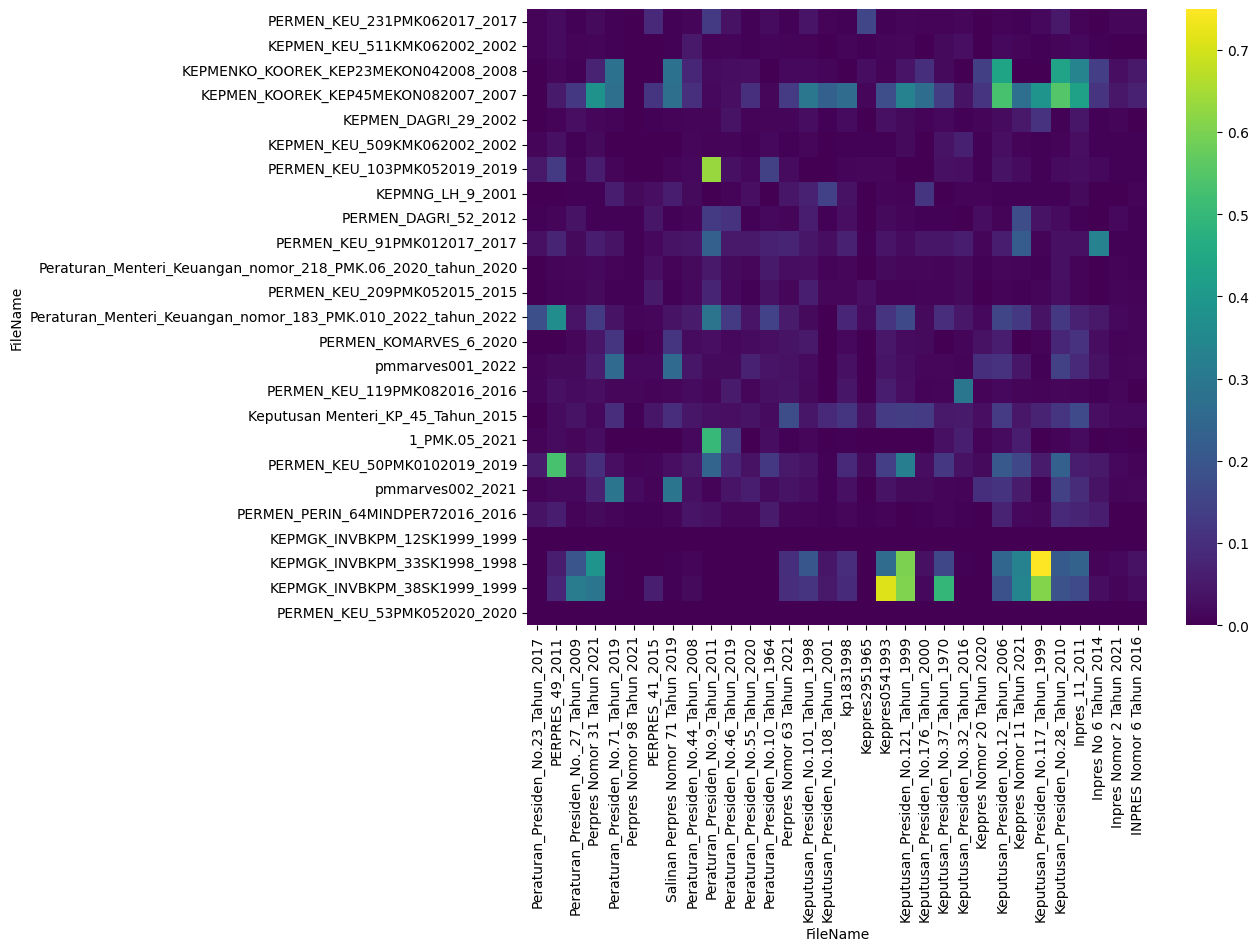

In [105]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [106]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                                           Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                                 
PERMEN_KEU_231PMK062017_2017                                             Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                                             Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                    Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                      Tidak Selaras   
KEPMEN_DAGRI_29_2002                                                     Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                             Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                             Tidak Selaras   
KEPMNG_LH_9_2001                                                         Tidak Selaras   
PERMEN_DAGRI_52_2012                                                     Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                              Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                       Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                             Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                              Netral   
PERMEN_KOMARVES_6_2020                                                   Tidak Selaras   
pmmarves001_2022                                                         Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                             Tidak Selaras   
Keputusan Menteri_KP_45_Tahun_2015                                       Tidak Selaras   
1_PMK.05_2021                                                            Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                             Tidak Selaras   
pmmarves002_2021                                                         Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2016                                         Tidak Selaras   
KEPMGK_INVBKPM_12SK1999_1999                                             Tidak Selaras   
KEPMGK_INVBKPM_33SK1998_1998                                             Tidak Selaras   
KEPMGK_INVBKPM_38SK1999_1999                                             Tidak Selaras   
PERMEN_KEU_53PMK052020_2020                                              Tidak Selaras   

FileName                                           PERPRES_49_2011  \
FileName                                                             
PERMEN_KEU_231PMK062017_2017                         Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                         Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                  Tidak Selaras   
KEPMEN_DAGRI_29_2002                                 Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                         Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                Netral   
KEPMNG_LH_9_2001                                     Tidak Selaras   
PERMEN_DAGRI_52_2012                                 Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                          Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...   Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                         Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...          Netral   
PERMEN_KOMARVES_6_2020                               Tidak Selaras   
pmmarves001_2022                                     Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                         Tidak Selaras   
Keputusan Menteri_KP_45_Tahun_2015                   Tidak Selaras   
1_PMK.05_2021                                        Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                               Selaras   
pmmarves002_2021                                     Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2

### Total

In [107]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          93.0
Selaras         14.0
Tidak Selaras  693.0

### Peraturan Peraturan Presiden dan Peraturan Pemerintah yang Selaras

In [108]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1  \
0   KEPMENKO_KOOREK_KEP23MEKON042008_2008   
1   KEPMENKO_KOOREK_KEP23MEKON042008_2008   
2     KEPMEN_KOOREK_KEP45MEKON082007_2007   
3     KEPMEN_KOOREK_KEP45MEKON082007_2007   
4     KEPMEN_KOOREK_KEP45MEKON082007_2007   
5            PERMEN_KEU_103PMK052019_2019   
6                           1_PMK.05_2021   
7            PERMEN_KEU_50PMK0102019_2019   
8            KEPMGK_INVBKPM_33SK1998_1998   
9            KEPMGK_INVBKPM_33SK1998_1998   
10           KEPMGK_INVBKPM_38SK1999_1999   
11           KEPMGK_INVBKPM_38SK1999_1999   
12           KEPMGK_INVBKPM_38SK1999_1999   
13           KEPMGK_INVBKPM_38SK1999_1999   

                            Perundangan2  
0    Keputusan_Presiden_No.12_Tahun_2006  
1    Keputusan_Presiden_No.28_Tahun_2010  
2    Keputusan_Presiden_No.12_Tahun_2006  
3    Keputusan_Presiden_No.28_Tahun_2010  
4                         Inpres_11_2011  
5     Peraturan_Presiden_No.9_Tahun_2011  
6     Peraturan_Presiden_No.9_Tahun_2011  
7                        PERPRES_49_2011  
8   Keputusan_Presiden_No.121_Tahun_1999  
9   Keputusan_Presiden_No.117_Tahun_1999  
10                        Keppres0541993  
11  Keputusan_Presiden_No.121_Tahun_1999  
12   Keputusan_Presiden_No.37_Tahun_1970  
13  Keputusan_Presiden_No.117_Tahun_1999

In [109]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [110]:
df_selaras

Perundangan1  \
0   KEPMENKO_KOOREK_KEP23MEKON042008_2008   
1   KEPMENKO_KOOREK_KEP23MEKON042008_2008   
2     KEPMEN_KOOREK_KEP45MEKON082007_2007   
3     KEPMEN_KOOREK_KEP45MEKON082007_2007   
4     KEPMEN_KOOREK_KEP45MEKON082007_2007   
5            PERMEN_KEU_103PMK052019_2019   
6                           1_PMK.05_2021   
7            PERMEN_KEU_50PMK0102019_2019   
8            KEPMGK_INVBKPM_33SK1998_1998   
9            KEPMGK_INVBKPM_33SK1998_1998   
10           KEPMGK_INVBKPM_38SK1999_1999   
11           KEPMGK_INVBKPM_38SK1999_1999   
12           KEPMGK_INVBKPM_38SK1999_1999   
13           KEPMGK_INVBKPM_38SK1999_1999   

                            Perundangan2  \
0    Keputusan_Presiden_No.12_Tahun_2006   
1    Keputusan_Presiden_No.28_Tahun_2010   
2    Keputusan_Presiden_No.12_Tahun_2006   
3    Keputusan_Presiden_No.28_Tahun_2010   
4                         Inpres_11_2011   
5     Peraturan_Presiden_No.9_Tahun_2011   
6     Peraturan_Presiden_No.9_Tahun_2011   
7                        PERPRES_49_2011   
8   Keputusan_Presiden_No.121_Tahun_1999   
9   Keputusan_Presiden_No.117_Tahun_1999   
10                        Keppres0541993   
11  Keputusan_Presiden_No.121_Tahun_1999   
12   Keputusan_Presiden_No.37_Tahun_1970   
13  Keputusan_Presiden_No.117_Tahun_1999   

                                               Topic1  \
0   putus menteri koordinator bidang ekonomi ketua...   
1   putus menteri koordinator bidang ekonomi ketua...   
2   putus presiden tim kembang sistem layan inform...   
3   putus presiden tim kembang sistem layan inform...   
4   putus presiden tim kembang sistem layan inform...   
5   tetap atur menteri uang standar layan minimum ...   
6   atur menteri uang tarif layan badan layan pusa...   
7                                   atur menteri uang   
8   tetap putus menteri negara investasi kepala ba...   
9   tetap putus menteri negara investasi kepala ba...   
10  tetap putus menteri negara investasi kepala ba...   
11  tetap putus menteri negara investasi kepala ba...   
12  tetap putus menteri negara investasi kepala ba...   
13  tetap putus menteri negara investasi kepala ba...   

                                               Topic2  
0   putus presiden komite arah kembang kawasan eko...  
1   putus presiden ubah putus presiden nomor 3 200...  
2   putus presiden komite arah kembang kawasan eko...  
3   putus presiden ubah putus presiden nomor 3 200...  
4           presiden republik indonesia nomor 11 2011  
5   atur presiden tugas pusat investasi perintah p...  
6   atur presiden tugas pusat investasi perintah p...  
7                         presiden republik indonesia  
8   tetap putus presiden ubah putus presiden nomor...  
9   tetap putus presiden ubah putus presiden nomor...  
10   cabut putus presiden nomor 32 1992 daftar bidang  
11  tetap putus presiden ubah putus presiden nomor...  
12  putus presiden republik indonesia bentuk team ...  
13  tetap putus presiden ubah putus presiden nomor...

In [111]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0               Peraturan_Pemerintah_No.99_Tahun_2013   
1              Peraturan_Pemerintah_No._45_Tahun_1995   
2               Peraturan_Pemerintah_No.25_Tahun_2020   
3                                          PP_55_2015   
4               Peraturan_Pemerintah_No.73_Tahun_1992   
5               Peraturan_Pemerintah_No.73_Tahun_2016   
6                 Peraturan_Presiden_No.44_Tahun_2008   
7                           Inpres Nomor 2 Tahun 2021   
8                           Inpres Nomor 2 Tahun 2021   
9                 Peraturan_Presiden_No.44_Tahun_2008   
10                          Inpres Nomor 2 Tahun 2021   
11                       PERMEN_KEU_119PMK082016_2016   
12                       KEPMEN_KEU_511KMK062002_2002   
13                               KEPMEN_DAGRI_29_2002   
14                       KEPMEN_KEU_509KMK062002_2002   
15                               PERMEN_DAGRI_52_2012   
16                               PERMEN_DAGRI_52_2012   
17                               PERMEN_DAGRI_52_2012   
18  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
19  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
20  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
21                       PERMEN_KEU_50PMK0102019_2019   
22              KEPMENKO_KOOREK_KEP23MEKON042008_2008   
23              KEPMENKO_KOOREK_KEP23MEKON042008_2008   
24                KEPMEN_KOOREK_KEP45MEKON082007_2007   
25                KEPMEN_KOOREK_KEP45MEKON082007_2007   
26                KEPMEN_KOOREK_KEP45MEKON082007_2007   
27                       PERMEN_KEU_103PMK052019_2019   
28                                      1_PMK.05_2021   
29                       PERMEN_KEU_50PMK0102019_2019   
30                       KEPMGK_INVBKPM_33SK1998_1998   
31                       KEPMGK_INVBKPM_33SK1998_1998   
32                       KEPMGK_INVBKPM_38SK1999_1999   
33                       KEPMGK_INVBKPM_38SK1999_1999   
34                       KEPMGK_INVBKPM_38SK1999_1999   
35                       KEPMGK_INVBKPM_38SK1999_1999   

                              Perundangan2  \
0          Undang-Undang_No._24_Tahun_2011   
1            Undang-Undang_No.8_Tahun_1995   
2            Undang-Undang_No.4_Tahun_2016   
3          Undang-Undang_No._24_Tahun_2011   
4           Undang-Undang_No.40_Tahun_2014   
5          Undang-Undang_No._24_Tahun_2011   
6    Peraturan_Pemerintah_No.73_Tahun_2016   
7    Peraturan_Pemerintah_No.99_Tahun_2013   
8    Peraturan_Pemerintah_No.73_Tahun_2016   
9          Undang-Undang_No._24_Tahun_2011   
10         Undang-Undang_No._24_Tahun_2011   
11          Undang-Undang_No.11_Tahun_2016   
12   Peraturan_Pemerintah_No.77_Tahun_1992   
13  Peraturan_Pemerintah_No.105_Tahun_2000   
14   Peraturan_Pemerintah_No.77_Tahun_1992   
15   Peraturan_Pemerintah_No.63_Tahun_2019   
16    Peraturan_Pemerintah_No.1_Tahun_2008   
17    Peraturan_Pemerintah_No.8_Tahun_2007   
18   Peraturan_Pemerintah_No.63_Tahun_2019   
19    Peraturan_Pemerintah_No.1_Tahun_2008   
20    Peraturan_Pemerintah_No.8_Tahun_2007   
21   Peraturan_Pemerintah_No.63_Tahun_2019   
22     Keputusan_Presiden_No.12_Tahun_2006   
23     Keputusan_Presiden_No.28_Tahun_2010   
24     Keputusan_Presiden_No.12_Tahun_2006   
25     Keputusan_Presiden_No.28_Tahun_2010   
26                          Inpres_11_2011   
27      Peraturan_Presiden_No.9_Tahun_2011   
28      Peraturan_Presiden_No.9_Tahun_2011   
29                         PERPRES_49_2011   
30    Keputusan_Presiden_No.121_Tahun_1999   
31    Keputusan_Presiden_No.117_Tahun_1999   
32                          Keppres0541993   
33    Keputusan_Presiden_No.121_Tahun_1999   
34     Keputusan_Presiden_No.37_Tahun_1970   
35    Keputusan_Presiden_No.117_Tahun_1999   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   


# Antar 1 Tingkat

## UU_Perpu

In [112]:
selected_df = df.query('Tingkatan == "UU_Perpu"')
selected_df.tail()

Tingkatan                        FileName  \
103  UU_Perpu  Undang-Undang_No.33_Tahun_2004   
104  UU_Perpu   Undang-Undang_No.9_Tahun_2018   
105  UU_Perpu  Undang-Undang_No.40_Tahun_2014   
106  UU_Perpu        Perpu Nomor 1 Tahun 2020   
107  UU_Perpu  Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  \
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...   
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...   
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...   
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...   
107  :\n\nMenetapkan : Undang-undang tentang CKeten...   

                                          cleaned_text  \
103  [tetap undang undang imbang uang perintah pusa...   
104  [tetap undang undang terima negara pajak, teri...   
105  [tetap undang undang asuransi, presiden republ...   
106  [atur perintah ganti undang undang bijak uang ...   
107  [tetap undang undang cketentuan tentu pokok ba...   

                                            final_text  
103  tetap undang undang imbang uang perintah pusat...  
104  tetap undang undang terima negara pajak terima...  
105  tetap undang undang asuransi presiden republik...  
106  atur perintah ganti undang undang bijak uang n...  
107  tetap undang undang cketentuan tentu pokok ban...

In [113]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 200)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [114]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(18, 200)


In [115]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 puluh' '00 ratus' '00 triliun' '000 00' '000 00 puluh' '000 00 ratus'
 '000 00 triliun' '000 000' '000 000 00' '000 000 000' 'anggar 2015'
 'anggar 2021' 'anggar belanja' 'anggar dapat' 'anggota dewan'
 'anggota direksi' 'asuransi syariah' 'asuransi syariah usaha'
 'asuransi usaha' 'asuransi usaha asuransi' 'atur atur'
 'atur atur menteri' 'atur atur otoritas' 'atur atur perintah'
 'atur menteri' 'atur menteri uang' 'atur otoritas' 'atur otoritas jasa'
 'atur perintah' 'atur undang' 'atur undang undang' 'ayat atur'
 'ayat atur atur' 'ayat ayat' 'ayat ayat atur' 'ayat ayat ayat'
 'ayat huruf' 'ayat huruf rencana' 'ayat tetap' 'ayat wajib' 'badan hukum'
 'badan usaha' 'badan usaha milik' 'bank gagal' 'bank indonesia'
 'bank kustodian' 'bank syariah' 'bank syariah uus' 'barang milik'
 'barang milik negara' 'belanja negara' 'belanja perintah'
 'belanja perintah pusat' 'bendahara negara' 'bp tapera' 'bupati walikota'
 'bursa efek' 'dana jamin' 'dapat pajak' 'dasar akad' 

### Document-Term Matrix

In [116]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 puluh  00 ratus  00 triliun    000 00  \
FileName                                                                    
Undang-Undang_No.8_Tahun_1995    0.000000  0.000000    0.000000  0.013212   
Undang-Undang_No.11_Tahun_2016   0.015763  0.000000    0.000000  0.016550   
Undang-Undang_No.1_Tahun_2004    0.023764  0.023764    0.000000  0.049901   
Undang-Undang_No.4_Tahun_2016    0.000000  0.000000    0.000000  0.000000   
Undang-Undang_No.21_Tahun_2008   0.008789  0.017577    0.000000  0.041010   
Salinan UU Nomor 9 Tahun 2020    0.055981  0.074641    0.093452  0.219426   
Undang-Undang_No._24_Tahun_2011  0.000000  0.023048    0.000000  0.016132   
UU411999                         0.000000  0.000000    0.000000  0.004191   
UU Nomor 4 Tahun 2009            0.003435  0.003435    0.000000  0.004808   
Undang-Undang_No.27_Tahun_2014   0.054647  0.072863    0.091225  0.212498   
UU_34_1964                       0.000000  0.000000    0.000000  0.000000   
Undang-Undang_No.22_Tahun_2006   0.000000  0.000000    0.000000  0.000000   
Undang-Undang_No.24_Tahun_2004   0.000000  0.007359    0.009214  0.025754   
Undang-Undang_No.33_Tahun_2004   0.000000  0.000000    0.000000  0.000000   
Undang-Undang_No.9_Tahun_2018    0.003367  0.000000    0.000000  0.004713   
Undang-Undang_No.40_Tahun_2014   0.000000  0.000000    0.000000  0.000830   
Perpu Nomor 1 Tahun 2020         0.000000  0.000000    0.020586  0.011509   
Undang-Undang_No.13_Tahun_1962   0.000000  0.000000    0.000000  0.000000   

                                 000 00 puluh  000 00 ratus  000 00 triliun  \
FileName                                                                      
Undang-Undang_No.8_Tahun_1995        0.000000      0.000000        0.000000   
Undang-Undang_No.11_Tahun_2016       0.015763      0.000000        0.000000   
Undang-Undang_No.1_Tahun_2004        0.023764      0.023764        0.000000   
Undang-Undang_No.4_Tahun_2016        0.000000      0.000000        0.000000   
Undang-Undang_No.21_Tahun_2008       0.008789      0.017577        0.000000   
Salinan UU Nomor 9 Tahun 2020        0.055981      0.074641        0.093452   
Undang-Undang_No._24_Tahun_2011      0.000000      0.023048        0.000000   
UU411999                             0.000000      0.000000        0.000000   
UU Nomor 4 Tahun 2009                0.003435      0.003435        0.000000   
Undang-Undang_No.27_Tahun_2014       0.054647      0.072863        0.091225   
UU_34_1964                           0.000000      0.000000        0.000000   
Undang-Undang_No.22_Tahun_2006       0.000000      0.000000        0.000000   
Undang-Undang_No.24_Tahun_2004       0.000000      0.007359        0.009214   
Undang-Undang_No.33_Tahun_2004       0.000000      0.000000        0.000000   
Undang-Undang_No.9_Tahun_2018        0.003367      0.000000        0.000000   
Undang-Undang_No.40_Tahun_2014       0.000000      0.000000        0.000000   
Perpu Nomor 1 Tahun 2020             0.000000      0.000000        0.020586   
Undang-Undang_No.13_Tahun_1962       0.000000      0.000000        0.000000   

                                  000 000  000 000 00  000 000 000  ...  \
FileName                                                            ...   
Undang-Undang_No.8_Tahun_1995    0.025027    0.013212     0.013962  ...   
Undang-Undang_No.11_Tahun_2016   0.026125    0.016550     0.011660  ...   
Undang-Undang_No.1_Tahun_2004    0.094527    0.049901     0.052734  ...   
Undang-Undang_No.4_Tahun_2016    0.000000    0.000000     0.000000  ...   
Undang-Undang_No.21_Tahun_2008   0.077685    0.041010     0.043338  ...   
Salinan UU Nomor 9 Tahun 2020    0.165768    0.104489     0.074534  ...   
Undang-Undang_No._24_Tahun_2011  0.030560    0.016132     0.017048  ...   
UU411999                         0.007939    0.004191     0.004429  ...   
UU Nomor 4 Tahun 2009            0.006831    0.004808     0.002541  ...   
Undang-Undang_No.27_Tahun_2014   0.169064    0.123249     0.058386  ...   
UU_34_1964 

### Calculate the similarity

In [117]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

In [118]:
cosine_similarity_df

FileName                         Undang-Undang_No.8_Tahun_1995  \
FileName                                                         
Undang-Undang_No.8_Tahun_1995                         1.000000   
Undang-Undang_No.11_Tahun_2016                        0.136777   
Undang-Undang_No.1_Tahun_2004                         0.030545   
Undang-Undang_No.4_Tahun_2016                         0.220239   
Undang-Undang_No.21_Tahun_2008                        0.038269   
Salinan UU Nomor 9 Tahun 2020                         0.128304   
Undang-Undang_No._24_Tahun_2011                       0.196057   
UU411999                                              0.090196   
UU Nomor 4 Tahun 2009                                 0.065827   
Undang-Undang_No.27_Tahun_2014                        0.119979   
UU_34_1964                                            0.435756   
Undang-Undang_No.22_Tahun_2006                        0.008061   
Undang-Undang_No.24_Tahun_2004                        0.065785   
Undang-Undang_No.33_Tahun_2004                        0.063147   
Undang-Undang_No.9_Tahun_2018                         0.090301   
Undang-Undang_No.40_Tahun_2014                        0.049733   
Perpu Nomor 1 Tahun 2020                              0.251598   
Undang-Undang_No.13_Tahun_1962                        0.298357   

FileName                         Undang-Undang_No.11_Tahun_2016  \
FileName                                                          
Undang-Undang_No.8_Tahun_1995                          0.136777   
Undang-Undang_No.11_Tahun_2016                         1.000000   
Undang-Undang_No.1_Tahun_2004                          0.027492   
Undang-Undang_No.4_Tahun_2016                          0.095187   
Undang-Undang_No.21_Tahun_2008                         0.023064   
Salinan UU Nomor 9 Tahun 2020                          0.100255   
Undang-Undang_No._24_Tahun_2011                        0.121679   
UU411999                                               0.053030   
UU Nomor 4 Tahun 2009                                  0.052201   
Undang-Undang_No.27_Tahun_2014                         0.089631   
UU_34_1964                                             0.248391   
Undang-Undang_No.22_Tahun_2006                         0.010254   
Undang-Undang_No.24_Tahun_2004                         0.038538   
Undang-Undang_No.33_Tahun_2004                         0.052683   
Undang-Undang_No.9_Tahun_2018                          0.072899   
Undang-Undang_No.40_Tahun_2014                         0.028537   
Perpu Nomor 1 Tahun 2020                               0.236336   
Undang-Undang_No.13_Tahun_1962                         0.167973   

FileName                         Undang-Undang_No.1_Tahun_2004  \
FileName                                                         
Undang-Undang_No.8_Tahun_1995                         0.030545   
Undang-Undang_No.11_Tahun_2016                        0.027492   
Undang-Undang_No.1_Tahun_2004                         1.000000   
Undang-Undang_No.4_Tahun_2016                         0.032504   
Undang-Undang_No.21_Tahun_2008                        0.107186   
Salinan UU Nomor 9 Tahun 2020                         0.155057   
Undang-Undang_No._24_Tahun_2011                       0.034520   
UU411999                                              0.030395   
UU Nomor 4 Tahun 2009                                 0.093068   
Undang-Undang_No.27_Tahun_2014                        0.161570   
UU_34_1964                                            0.060787   
Undang-Undang_No.22_Tahun_2006                        0.016904   
Undang-Undang_No.24_Tahun_2004                        0.037802   
Undang-Undang_No.33_Tahun_2004                        0.718516   
Undang-Undang_No.9_Tahun_2018                         0.033596   
Undang-Undang_No.40_Tahun_2014                        0.006289   
Perpu Nomor 1 Tahun 2020                              0.081864   
Undang-Undang_No.13_Tahun_1962                        0.057530   

FileName         

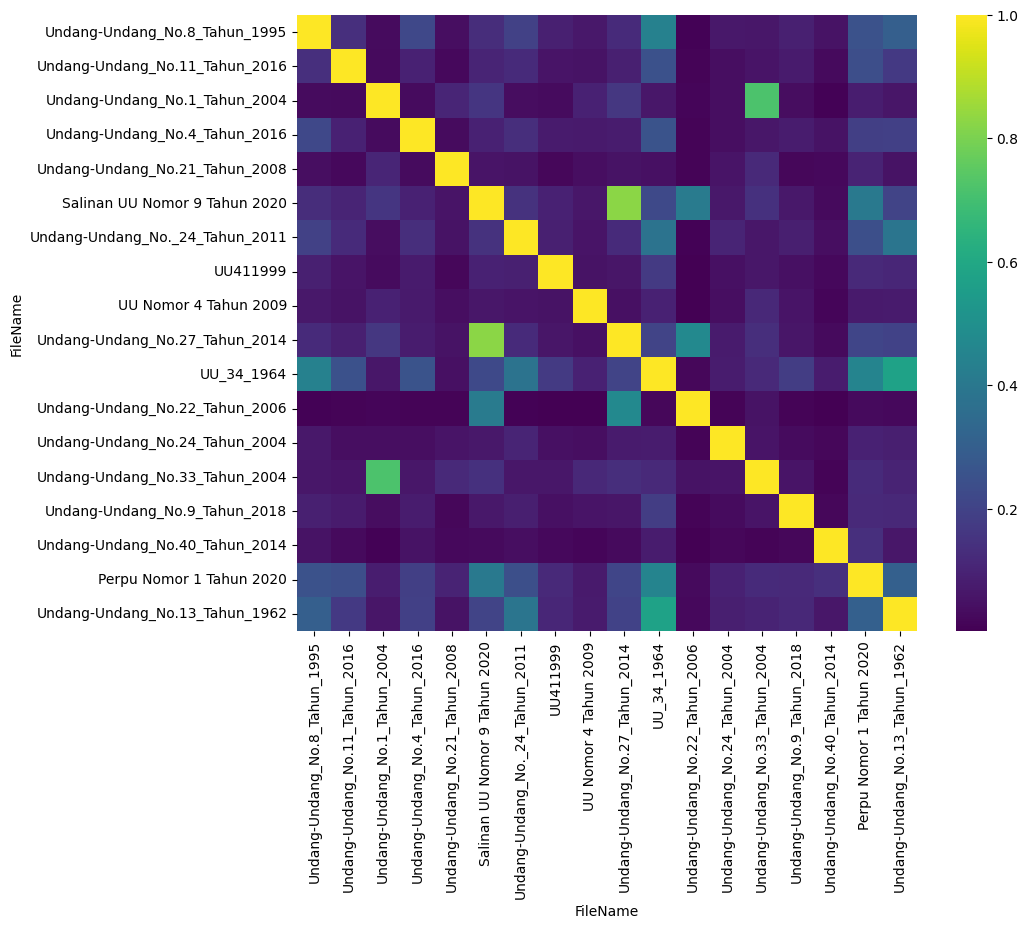

In [119]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [120]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = cosine_similarity_df.applymap(convert_to_label)
label_df

FileName                        Undang-Undang_No.8_Tahun_1995  \
FileName                                                        
Undang-Undang_No.8_Tahun_1995                         Selaras   
Undang-Undang_No.11_Tahun_2016                         Netral   
Undang-Undang_No.1_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.4_Tahun_2016                          Netral   
Undang-Undang_No.21_Tahun_2008                  Tidak Selaras   
Salinan UU Nomor 9 Tahun 2020                          Netral   
Undang-Undang_No._24_Tahun_2011                        Netral   
UU411999                                        Tidak Selaras   
UU Nomor 4 Tahun 2009                           Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                         Netral   
UU_34_1964                                            Selaras   
Undang-Undang_No.22_Tahun_2006                  Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.9_Tahun_2018                   Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                  Tidak Selaras   
Perpu Nomor 1 Tahun 2020                               Netral   
Undang-Undang_No.13_Tahun_1962                         Netral   

FileName                        Undang-Undang_No.11_Tahun_2016  \
FileName                                                         
Undang-Undang_No.8_Tahun_1995                           Netral   
Undang-Undang_No.11_Tahun_2016                         Selaras   
Undang-Undang_No.1_Tahun_2004                    Tidak Selaras   
Undang-Undang_No.4_Tahun_2016                    Tidak Selaras   
Undang-Undang_No.21_Tahun_2008                   Tidak Selaras   
Salinan UU Nomor 9 Tahun 2020                           Netral   
Undang-Undang_No._24_Tahun_2011                         Netral   
UU411999                                         Tidak Selaras   
UU Nomor 4 Tahun 2009                            Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                   Tidak Selaras   
UU_34_1964                                              Netral   
Undang-Undang_No.22_Tahun_2006                   Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.9_Tahun_2018                    Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                   Tidak Selaras   
Perpu Nomor 1 Tahun 2020                                Netral   
Undang-Undang_No.13_Tahun_1962                          Netral   

FileName                        Undang-Undang_No.1_Tahun_2004  \
FileName                                                        
Undang-Undang_No.8_Tahun_1995                   Tidak Selaras   
Undang-Undang_No.11_Tahun_2016                  Tidak Selaras   
Undang-Undang_No.1_Tahun_2004                         Selaras   
Undang-Undang_No.4_Tahun_2016                   Tidak Selaras   
Undang-Undang_No.21_Tahun_2008                         Netral   
Salinan UU Nomor 9 Tahun 2020                          Netral   
Undang-Undang_No._24_Tahun_2011                 Tidak Selaras   
UU411999                                        Tidak Selaras   
UU Nomor 4 Tahun 2009                           Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                         Netral   
UU_34_1964                                      Tidak Selaras   
Undang-Undang_No.22_Tahun_2006                  Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                        Selaras   
Undang-Undang_No.9_Tahun_2018                   Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                  Tidak Selaras   
Perpu Nomor 1 Tahun 2020                        Tidak Selaras   
Undang-Undang_No.13_Tahun_1962                  Tidak Selaras   

FileName                        Undang-Undang_No.4_Tahun_2016  \
FileName    

In [121]:
# Ubah menjadi bentuk menyerupai matriks segitiga sehingga tidak terjadi duplikat
mask = np.triu(np.ones(label_df.shape, dtype=bool), k=0)

# Set the upper triangle values to NaN
label_df.mask(mask, inplace=True)

In [122]:
label_df

FileName                        Undang-Undang_No.8_Tahun_1995  \
FileName                                                        
Undang-Undang_No.8_Tahun_1995                             NaN   
Undang-Undang_No.11_Tahun_2016                         Netral   
Undang-Undang_No.1_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.4_Tahun_2016                          Netral   
Undang-Undang_No.21_Tahun_2008                  Tidak Selaras   
Salinan UU Nomor 9 Tahun 2020                          Netral   
Undang-Undang_No._24_Tahun_2011                        Netral   
UU411999                                        Tidak Selaras   
UU Nomor 4 Tahun 2009                           Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                         Netral   
UU_34_1964                                            Selaras   
Undang-Undang_No.22_Tahun_2006                  Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.9_Tahun_2018                   Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                  Tidak Selaras   
Perpu Nomor 1 Tahun 2020                               Netral   
Undang-Undang_No.13_Tahun_1962                         Netral   

FileName                        Undang-Undang_No.11_Tahun_2016  \
FileName                                                         
Undang-Undang_No.8_Tahun_1995                              NaN   
Undang-Undang_No.11_Tahun_2016                             NaN   
Undang-Undang_No.1_Tahun_2004                    Tidak Selaras   
Undang-Undang_No.4_Tahun_2016                    Tidak Selaras   
Undang-Undang_No.21_Tahun_2008                   Tidak Selaras   
Salinan UU Nomor 9 Tahun 2020                           Netral   
Undang-Undang_No._24_Tahun_2011                         Netral   
UU411999                                         Tidak Selaras   
UU Nomor 4 Tahun 2009                            Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                   Tidak Selaras   
UU_34_1964                                              Netral   
Undang-Undang_No.22_Tahun_2006                   Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.9_Tahun_2018                    Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                   Tidak Selaras   
Perpu Nomor 1 Tahun 2020                                Netral   
Undang-Undang_No.13_Tahun_1962                          Netral   

FileName                        Undang-Undang_No.1_Tahun_2004  \
FileName                                                        
Undang-Undang_No.8_Tahun_1995                             NaN   
Undang-Undang_No.11_Tahun_2016                            NaN   
Undang-Undang_No.1_Tahun_2004                             NaN   
Undang-Undang_No.4_Tahun_2016                   Tidak Selaras   
Undang-Undang_No.21_Tahun_2008                         Netral   
Salinan UU Nomor 9 Tahun 2020                          Netral   
Undang-Undang_No._24_Tahun_2011                 Tidak Selaras   
UU411999                                        Tidak Selaras   
UU Nomor 4 Tahun 2009                           Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                         Netral   
UU_34_1964                                      Tidak Selaras   
Undang-Undang_No.22_Tahun_2006                  Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                        Selaras   
Undang-Undang_No.9_Tahun_2018                   Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                  Tidak Selaras   
Perpu Nomor 1 Tahun 2020                        Tidak Selaras   
Undang-Undang_No.13_Tahun_1962                  Tidak Selaras   

FileName                        Undang-Undang_No.4_Tahun_2016  \
FileName    

### Total

In [123]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          44.0
Selaras          8.0
Tidak Selaras  101.0

### UU_Perpu yang Selaras

In [124]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                    Perundangan2
0  Undang-Undang_No.27_Tahun_2014   Salinan UU Nomor 9 Tahun 2020
1                      UU_34_1964   Undang-Undang_No.8_Tahun_1995
2  Undang-Undang_No.22_Tahun_2006   Salinan UU Nomor 9 Tahun 2020
3  Undang-Undang_No.22_Tahun_2006  Undang-Undang_No.27_Tahun_2014
4  Undang-Undang_No.33_Tahun_2004   Undang-Undang_No.1_Tahun_2004
5        Perpu Nomor 1 Tahun 2020   Salinan UU Nomor 9 Tahun 2020
6        Perpu Nomor 1 Tahun 2020                      UU_34_1964
7  Undang-Undang_No.13_Tahun_1962                      UU_34_1964

In [125]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [126]:
df_selaras

Perundangan1                    Perundangan2  \
0  Undang-Undang_No.27_Tahun_2014   Salinan UU Nomor 9 Tahun 2020   
1                      UU_34_1964   Undang-Undang_No.8_Tahun_1995   
2  Undang-Undang_No.22_Tahun_2006   Salinan UU Nomor 9 Tahun 2020   
3  Undang-Undang_No.22_Tahun_2006  Undang-Undang_No.27_Tahun_2014   
4  Undang-Undang_No.33_Tahun_2004   Undang-Undang_No.1_Tahun_2004   
5        Perpu Nomor 1 Tahun 2020   Salinan UU Nomor 9 Tahun 2020   
6        Perpu Nomor 1 Tahun 2020                      UU_34_1964   
7  Undang-Undang_No.13_Tahun_1962                      UU_34_1964   

                                              Topic1  \
0  tetap undang undang anggar dapat belanja negar...   
1       tetap undang undang dana celaka lintas jalan   
2  undang undang tanggung jaw aban laksana anggar...   
3  undang undang tanggung jaw aban laksana anggar...   
4  tetap undang undang imbang uang perintah pusat...   
5  atur perintah ganti undang undang bijak uang n...   
6  atur perintah ganti undang undang bijak uang n...   
7    tetap undang undang cketentuan tentu pokok bank   

                                              Topic2  
0  undang undang anggar dapat belanja negara angg...  
1                    tetap undang undang pasar modal  
2  undang undang anggar dapat belanja negara angg...  
3  tetap undang undang anggar dapat belanja negar...  
4               tetap undang undang bendahara negara  
5  undang undang anggar dapat belanja negara angg...  
6       tetap undang undang dana celaka lintas jalan  
7       tetap undang undang dana celaka lintas jalan

In [127]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0               Peraturan_Pemerintah_No.99_Tahun_2013   
1              Peraturan_Pemerintah_No._45_Tahun_1995   
2               Peraturan_Pemerintah_No.25_Tahun_2020   
3                                          PP_55_2015   
4               Peraturan_Pemerintah_No.73_Tahun_1992   
5               Peraturan_Pemerintah_No.73_Tahun_2016   
6                 Peraturan_Presiden_No.44_Tahun_2008   
7                           Inpres Nomor 2 Tahun 2021   
8                           Inpres Nomor 2 Tahun 2021   
9                 Peraturan_Presiden_No.44_Tahun_2008   
10                          Inpres Nomor 2 Tahun 2021   
11                       PERMEN_KEU_119PMK082016_2016   
12                       KEPMEN_KEU_511KMK062002_2002   
13                               KEPMEN_DAGRI_29_2002   
14                       KEPMEN_KEU_509KMK062002_2002   
15                               PERMEN_DAGRI_52_2012   
16                               PERMEN_DAGRI_52_2012   
17                               PERMEN_DAGRI_52_2012   
18  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
19  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
20  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
21                       PERMEN_KEU_50PMK0102019_2019   
22              KEPMENKO_KOOREK_KEP23MEKON042008_2008   
23              KEPMENKO_KOOREK_KEP23MEKON042008_2008   
24                KEPMEN_KOOREK_KEP45MEKON082007_2007   
25                KEPMEN_KOOREK_KEP45MEKON082007_2007   
26                KEPMEN_KOOREK_KEP45MEKON082007_2007   
27                       PERMEN_KEU_103PMK052019_2019   
28                                      1_PMK.05_2021   
29                       PERMEN_KEU_50PMK0102019_2019   
30                       KEPMGK_INVBKPM_33SK1998_1998   
31                       KEPMGK_INVBKPM_33SK1998_1998   
32                       KEPMGK_INVBKPM_38SK1999_1999   
33                       KEPMGK_INVBKPM_38SK1999_1999   
34                       KEPMGK_INVBKPM_38SK1999_1999   
35                       KEPMGK_INVBKPM_38SK1999_1999   
36                     Undang-Undang_No.27_Tahun_2014   
37                                         UU_34_1964   
38                     Undang-Undang_No.22_Tahun_2006   
39                     Undang-Undang_No.22_Tahun_2006   
40                     Undang-Undang_No.33_Tahun_2004   
41                           Perpu Nomor 1 Tahun 2020   
42                           Perpu Nomor 1 Tahun 2020   
43                     Undang-Undang_No.13_Tahun_1962   

                              Perundangan2  \
0          Undang-Undang_No._24_Tahun_2011   
1            Undang-Undang_No.8_Tahun_1995   
2            Undang-Undang_No.4_Tahun_2016   
3          Undang-Undang_No._24_Tahun_2011   
4           Undang-Undang_No.40_Tahun_2014   
5          Undang-Undang_No._24_Tahun_2011   
6    Peraturan_Pemerintah_No.73_Tahun_2016   
7    Peraturan_Pemerintah_No.99_Tahun_2013   
8    Peraturan_Pemerintah_No.73_Tahun_2016   
9          Undang-Undang_No._24_Tahun_2011   
10         Undang-Undang_No._24_Tahun_2011   
11          Undang-Undang_No.11_Tahun_2016   
12   Peraturan_Pemerintah_No.77_Tahun_1992   
13  Peraturan_Pemerintah_No.105_Tahun_2000   
14   Peraturan_Pemerintah_No.77_Tahun_1992   
15   Peraturan_Pemerintah_No.63_Tahun_2019   
16    Peraturan_Pemerintah_No.1_Tahun_2008   
17    Peraturan_Pemerintah_No.8_Tahun_2007   
18   Peraturan_Pemerintah_No.63_Tahun_2019   
19    Peraturan_Pemerintah_No.1_Tahun_2008   
20    Peraturan_Pemerintah_No.8_Tahun_2007   
21   Peraturan_Pemerintah_No.63_Tahun_2019   
22     Keputusan_Presiden_No.12_Tahun_2006   
23     Keputusan_Presiden_No.28_Tahun_2010   
24     Keputusan_Presiden_No.12_Tahun_2006   
25     Keputusan_Presiden_No.28_Tahun_2010   
26                          Inpres_11_2011   
27      Peraturan_Presiden_No.9_Tahun_2011   
28      Peraturan_Presiden_No.9_Tahun_2011   
29                         PERPRES_49_2011   
30    Keputusan_Presiden_No.121_Tahun_1999   
31 

## Peraturan Pemerintah

In [128]:
selected_df = df.query('Tingkatan == "Peraturan Pemerintah"')
selected_df.tail()

Tingkatan                                FileName  \
28  Peraturan Pemerintah                              PP_27_1985   
29  Peraturan Pemerintah   Peraturan_Pemerintah_No.54_Tahun_1993   
30  Peraturan Pemerintah   Peraturan_Pemerintah_No.33_Tahun_1993   
31  Peraturan Pemerintah  Peraturan_Pemerintah_No.105_Tahun_2000   
32  Peraturan Pemerintah   Peraturan_Pemerintah_No.40_Tahun_2000   

                                        ExtractedText  \
28  Menetapkan\nPERATURAN PEMERINTAH REPUBLIK INDO...   
29  «...\n
Menetapkan :\n\n \n\nPRESIDEN\nREPUBLIK...   
30  :\n\nMenetapkan : PERATURAN PEMERINTAH REPUBLI...   
31  Menetapkan :\nPERATURAN PEMERINTAH TENTANG PEN...   
32  :\n\nMenetapkan:\n\nPERATURAN PEMERINTAH TENTA...   

                                         cleaned_text  \
28  [perintah perintah republik indonesia, preside...   
29  [presiden republik indonesia, atur perintah re...   
30  [tetap atur perintah republik indonesia tambah...   
31  [tetap atur perintah kelola pertanggungjawaban...   
32  [atur perintah tambah serta modal negara repub...   

                                           final_text  
28  perintah perintah republik indonesia presiden ...  
29  presiden republik indonesia atur perintah repu...  
30  tetap atur perintah republik indonesia tambah ...  
31  tetap atur perintah kelola pertanggungjawaban ...  
32  atur perintah tambah serta modal negara republ...

In [129]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 400)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [130]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(33, 400)


In [131]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 ratus' '000 00' '000 00 ratus' '000 000' '000 000 00' '10 puluh'
 '10 puluh kerja' '10 puluh persen' '15 belas' '20 puluh' '50 puluh'
 '50 puluh persen' 'agun aset' 'ajar formal' 'ajar formal nonformal'
 'akuntansi uang' 'alokasi anggar' 'alokasi anggar perintah'
 'anggar dapat' 'anggar dapat belanja' 'anggar dasar' 'anggar perintah'
 'anggar tahun' 'anggota direksi' 'aset bpjs' 'aset bpjs ketenagakerjaan'
 'aset dana' 'aset dana jamin' 'asuransi jiwa' 'asuransi usaha'
 'atur atur' 'atur atur menteri' 'atur laksana' 'atur menteri'
 'atur perintah' 'atur perintah atur' 'atur perintah laku'
 'atur perintah nomor' 'atur perintah tempat' 'atur undang'
 'atur undang undang' 'ayat atur' 'ayat atur atur' 'ayat ayat'
 'ayat huruf' 'ayat laksana' 'ayat menteri' 'ayat pasal' 'ayat tetap'
 'ayat tetap menteri' 'badan hukum' 'badan investasi'
 'badan investasi perintah' 'badan kelola' 'badan periksa'
 'badan periksa uang' 'badan selenggara' 'badan usaha' 'badan usaha milik'
 'b

### Document-Term Matrix

In [132]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 ratus    000 00  \
FileName                                                                 
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019               0.000000  0.011876   
Peraturan_Pemerintah_No.1_Tahun_2008                0.000000  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                0.000000  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019               0.000000  0.000000   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000  0.000000   
2021pp049                                           0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1996               0.000000  0.000000   
Peraturan_Pemerintah_No._49_Tahun_2011              0.000000  0.000000   
Peraturan_Pemerintah_No.75_Tahun_1992               0.000000  0.000000   
Peraturan_Pemerintah_No.99_Tahun_2013               0.000000  0.000000   
Peraturan_Pemerintah_No.5_Tahun_2018                0.000000  0.000000   
Peraturan_Pemerintah_No.77_Tahun_1992               0.000000  0.000000   
Peraturan_Pemerintah_No._45_Tahun_1995              0.172937  0.317427   
Peraturan_Pemerintah_No.25_Tahun_2020               0.000000  0.000000   
Peraturan_Pemerintah_No.48_Tahun_2008               0.000000  0.000000   
Peraturan_Pemerintah_No.18_Tahun_1983               0.000000  0.000000   
Peraturan_Pemerintah_No.30_Tahun_1982               0.000000  0.000000   
Peraturan_Pemerintah_No.53_Tahun_2018               0.000000  0.000000   
PP_55_2015                                          0.000000  0.000000   
Peraturan_Pemerintah_No.49_Tahun_2017               0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1984               0.000000  0.000000   
Peraturan_Pemerintah_No.107_Tahun_2015              0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_2013               0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_1992               0.000000  0.000000   
2022pp031                                           0.000000  0.000000   
PP Nomor 93 Tahun 2021                              0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_2016               0.000000  0.000000   
PP_27_1985                                          0.000000  0.000000   
Peraturan_Pemerintah_No.54_Tahun_1993               0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_1993               0.000000  0.000000   
Peraturan_Pemerintah_No.105_Tahun_2000              0.000000  0.000000   
Peraturan_Pemerintah_No.40_Tahun_2000               0.000000  0.000000   

                                                    000 00 ratus   000 000  \
FileName                                                                     
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...      0.000000  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019                   0.000000  0.030319   
Peraturan_Pemerintah_No.1_Tahun_2008                    0.000000  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                    0.000000  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019                   0.000000  0.000000   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...      0.000000  0.000000   
2021pp049                                               0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1996                   0.000000  0.000000   
Peraturan_Pemerintah_No._49_Tahun_2011                  0.000000  0.000000   
Peraturan_Pemerintah_No.75_Tahun_1992                   0.000000  0.000000   
Peraturan_Pemerintah_No.99_Tahun_2013                   0.000000  0.000000   
Peraturan_Pemerintah_No.5_Tahun_2018                    0.000000  0.000000   
Peraturan_Pemerintah_No.77_Tahun_1992                   0.000000  0.000000   
Peraturan_Pemerintah_No._45_Tahun_1995                  0.172937  0.263196   
Peraturan_Pemerintah_No.25_Tahun_2020                   0.000000  0.000000   
Peraturan_Pemerintah_No.48_Tahun_2008                   0.000000  0.000000   
Peraturan_Pemerintah_No.18_Tahun_1983                   0

### Calculate the similarity

In [133]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

In [134]:
cosine_similarity_df

FileName                                            PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                              
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                           1.000000                 
Peraturan_Pemerintah_No.63_Tahun_2019                                                        0.065842                 
Peraturan_Pemerintah_No.1_Tahun_2008                                                         0.071589                 
Peraturan_Pemerintah_No.8_Tahun_2007                                                         0.101719                 
Peraturan_Pemerintah_No.24_Tahun_2019                                                        0.031689                 
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                           0.177192                 
2021pp049                                                                                    0.098117                 
Peraturan_Pemerintah_No.28_Tahun_1996                                                        0.053624                 
Peraturan_Pemerintah_No._49_Tahun_2011                                                       0.129717                 
Peraturan_Pemerintah_No.75_Tahun_1992                                                        0.126346                 
Peraturan_Pemerintah_No.99_Tahun_2013                                                        0.026977                 
Peraturan_Pemerintah_No.5_Tahun_2018                                                         0.014802                 
Peraturan_Pemerintah_No.77_Tahun_1992                                                        0.038244                 
Peraturan_Pemerintah_No._45_Tahun_1995                                                       0.022594                 
Peraturan_Pemerintah_No.25_Tahun_2020                                                        0.032684                 
Peraturan_Pemerintah_No.48_Tahun_2008                                                        0.020563                 
Peraturan_Pemerintah_No.18_Tahun_1983                                                        0.182476                 
Peraturan_Pemerintah_No.30_Tahun_1982                                                        0.196846                 
Peraturan_Pemerintah_No.53_Tahun_2018                                                        0.031566                 
PP_55_2015                                                                                   0.036000                 
Peraturan_Pemerintah_No.49_Tahun_2017                                                        0.010768                 
Peraturan_Pemerintah_No.28_Tahun_1984                                                        0.290072                 
Peraturan_Pemerintah_No.107_Tahun_2015                                                       0.049111                 
Peraturan_Pemerintah_No.33_Tahun_2013                                                        0.017721                 
Peraturan_Pemerintah_No.73_Tahun_1992                                                        0.070215                 
2022pp031                                                                                    0.070530                 
PP Nomor 93 Tahun 2021                                                                       0.054113                 
Peraturan_Pemerintah_No.73_Tahun_2016                                                        0.020189                 
PP_27_1985                                                                                   0.198308                 
Peraturan_Pemerintah_No.54_Tahun_1993                                                        0.112828                 
Peraturan_Pemerintah_No.33_Tahun_1993                                                        0.140547                 
Peraturan_Pemerintah_No.105_Tahun_2000                                   

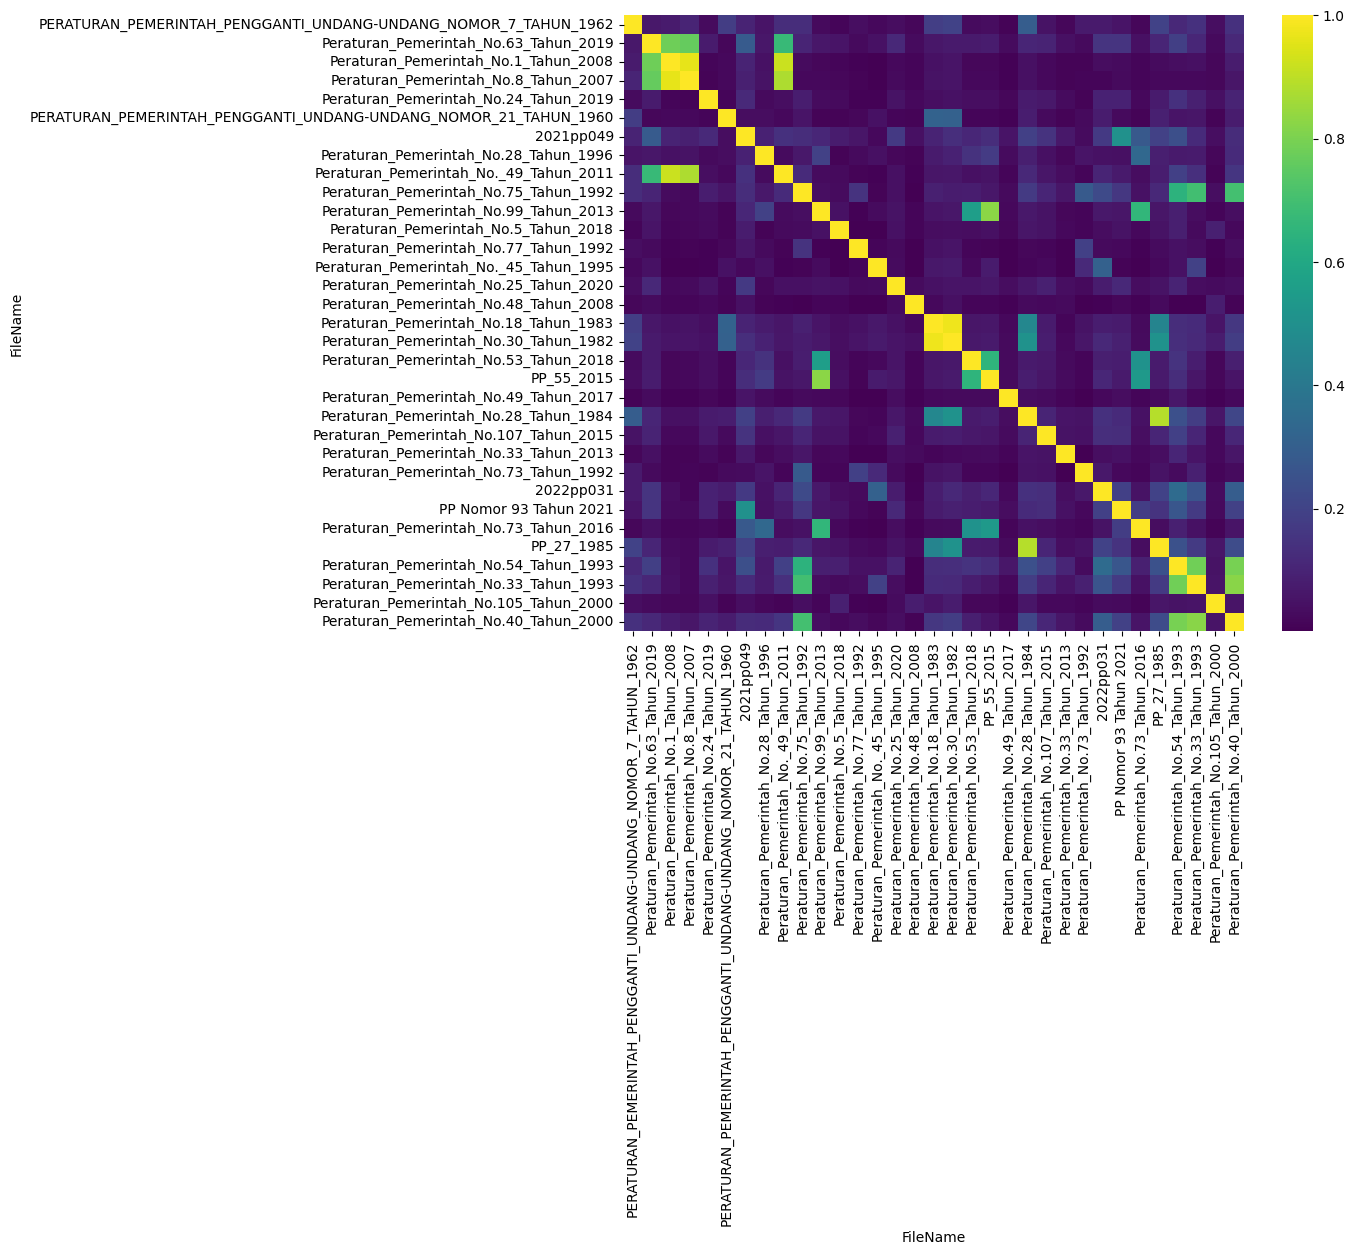

In [135]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [136]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function
label_df = cosine_similarity_df.applymap(convert_to_label)
label_df

FileName                                           PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                             
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                            Selaras                
Peraturan_Pemerintah_No.63_Tahun_2019                                                   Tidak Selaras                
Peraturan_Pemerintah_No.1_Tahun_2008                                                    Tidak Selaras                
Peraturan_Pemerintah_No.8_Tahun_2007                                                           Netral                
Peraturan_Pemerintah_No.24_Tahun_2019                                                   Tidak Selaras                
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                             Netral                
2021pp049                                                                               Tidak Selaras                
Peraturan_Pemerintah_No.28_Tahun_1996                                                   Tidak Selaras                
Peraturan_Pemerintah_No._49_Tahun_2011                                                         Netral                
Peraturan_Pemerintah_No.75_Tahun_1992                                                          Netral                
Peraturan_Pemerintah_No.99_Tahun_2013                                                   Tidak Selaras                
Peraturan_Pemerintah_No.5_Tahun_2018                                                    Tidak Selaras                
Peraturan_Pemerintah_No.77_Tahun_1992                                                   Tidak Selaras                
Peraturan_Pemerintah_No._45_Tahun_1995                                                  Tidak Selaras                
Peraturan_Pemerintah_No.25_Tahun_2020                                                   Tidak Selaras                
Peraturan_Pemerintah_No.48_Tahun_2008                                                   Tidak Selaras                
Peraturan_Pemerintah_No.18_Tahun_1983                                                          Netral                
Peraturan_Pemerintah_No.30_Tahun_1982                                                          Netral                
Peraturan_Pemerintah_No.53_Tahun_2018                                                   Tidak Selaras                
PP_55_2015                                                                              Tidak Selaras                
Peraturan_Pemerintah_No.49_Tahun_2017                                                   Tidak Selaras                
Peraturan_Pemerintah_No.28_Tahun_1984                                                          Netral                
Peraturan_Pemerintah_No.107_Tahun_2015                                                  Tidak Selaras                
Peraturan_Pemerintah_No.33_Tahun_2013                                                   Tidak Selaras                
Peraturan_Pemerintah_No.73_Tahun_1992                                                   Tidak Selaras                
2022pp031                                                                               Tidak Selaras                
PP Nomor 93 Tahun 2021                                                                  Tidak Selaras                
Peraturan_Pemerintah_No.73_Tahun_2016                                                   Tidak Selaras                
PP_27_1985                                                                                     Netral                
Peraturan_Pemerintah_No.54_Tahun_1993                                                          Netral                
Peraturan_Pemerintah_No.33_Tahun_1993                                                          Netral                
Peraturan_Pemerintah_No.105_Tahun_2000                                                  Tidak Selaras     

In [137]:
# Ubah menjadi bentuk menyerupai matriks segitiga sehingga tidak terjadi duplikat
mask = np.triu(np.ones(label_df.shape, dtype=bool), k=0)

# Set the upper triangle values to NaN
label_df.mask(mask, inplace=True)

In [138]:
label_df

FileName                                           PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                             
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                                NaN                
Peraturan_Pemerintah_No.63_Tahun_2019                                                   Tidak Selaras                
Peraturan_Pemerintah_No.1_Tahun_2008                                                    Tidak Selaras                
Peraturan_Pemerintah_No.8_Tahun_2007                                                           Netral                
Peraturan_Pemerintah_No.24_Tahun_2019                                                   Tidak Selaras                
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                             Netral                
2021pp049                                                                               Tidak Selaras                
Peraturan_Pemerintah_No.28_Tahun_1996                                                   Tidak Selaras                
Peraturan_Pemerintah_No._49_Tahun_2011                                                         Netral                
Peraturan_Pemerintah_No.75_Tahun_1992                                                          Netral                
Peraturan_Pemerintah_No.99_Tahun_2013                                                   Tidak Selaras                
Peraturan_Pemerintah_No.5_Tahun_2018                                                    Tidak Selaras                
Peraturan_Pemerintah_No.77_Tahun_1992                                                   Tidak Selaras                
Peraturan_Pemerintah_No._45_Tahun_1995                                                  Tidak Selaras                
Peraturan_Pemerintah_No.25_Tahun_2020                                                   Tidak Selaras                
Peraturan_Pemerintah_No.48_Tahun_2008                                                   Tidak Selaras                
Peraturan_Pemerintah_No.18_Tahun_1983                                                          Netral                
Peraturan_Pemerintah_No.30_Tahun_1982                                                          Netral                
Peraturan_Pemerintah_No.53_Tahun_2018                                                   Tidak Selaras                
PP_55_2015                                                                              Tidak Selaras                
Peraturan_Pemerintah_No.49_Tahun_2017                                                   Tidak Selaras                
Peraturan_Pemerintah_No.28_Tahun_1984                                                          Netral                
Peraturan_Pemerintah_No.107_Tahun_2015                                                  Tidak Selaras                
Peraturan_Pemerintah_No.33_Tahun_2013                                                   Tidak Selaras                
Peraturan_Pemerintah_No.73_Tahun_1992                                                   Tidak Selaras                
2022pp031                                                                               Tidak Selaras                
PP Nomor 93 Tahun 2021                                                                  Tidak Selaras                
Peraturan_Pemerintah_No.73_Tahun_2016                                                   Tidak Selaras                
PP_27_1985                                                                                     Netral                
Peraturan_Pemerintah_No.54_Tahun_1993                                                          Netral                
Peraturan_Pemerintah_No.33_Tahun_1993                                                          Netral                
Peraturan_Pemerintah_No.105_Tahun_2000                                                  Tidak Selaras     

### Total

In [139]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          99.0
Selaras         25.0
Tidak Selaras  404.0

### Peraturan Pemerintah yang Selaras

In [140]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1  \
0     Peraturan_Pemerintah_No.1_Tahun_2008   
1     Peraturan_Pemerintah_No.8_Tahun_2007   
2     Peraturan_Pemerintah_No.8_Tahun_2007   
3   Peraturan_Pemerintah_No._49_Tahun_2011   
4   Peraturan_Pemerintah_No._49_Tahun_2011   
5   Peraturan_Pemerintah_No._49_Tahun_2011   
6    Peraturan_Pemerintah_No.30_Tahun_1982   
7    Peraturan_Pemerintah_No.53_Tahun_2018   
8                               PP_55_2015   
9                               PP_55_2015   
10   Peraturan_Pemerintah_No.28_Tahun_1984   
11   Peraturan_Pemerintah_No.28_Tahun_1984   
12                  PP Nomor 93 Tahun 2021   
13   Peraturan_Pemerintah_No.73_Tahun_2016   
14   Peraturan_Pemerintah_No.73_Tahun_2016   
15   Peraturan_Pemerintah_No.73_Tahun_2016   
16                              PP_27_1985   
17                              PP_27_1985   
18                              PP_27_1985   
19   Peraturan_Pemerintah_No.54_Tahun_1993   
20   Peraturan_Pemerintah_No.33_Tahun_1993   
21   Peraturan_Pemerintah_No.33_Tahun_1993   
22   Peraturan_Pemerintah_No.40_Tahun_2000   
23   Peraturan_Pemerintah_No.40_Tahun_2000   
24   Peraturan_Pemerintah_No.40_Tahun_2000   

                             Perundangan2  
0   Peraturan_Pemerintah_No.63_Tahun_2019  
1   Peraturan_Pemerintah_No.63_Tahun_2019  
2    Peraturan_Pemerintah_No.1_Tahun_2008  
3   Peraturan_Pemerintah_No.63_Tahun_2019  
4    Peraturan_Pemerintah_No.1_Tahun_2008  
5    Peraturan_Pemerintah_No.8_Tahun_2007  
6   Peraturan_Pemerintah_No.18_Tahun_1983  
7   Peraturan_Pemerintah_No.99_Tahun_2013  
8   Peraturan_Pemerintah_No.99_Tahun_2013  
9   Peraturan_Pemerintah_No.53_Tahun_2018  
10  Peraturan_Pemerintah_No.18_Tahun_1983  
11  Peraturan_Pemerintah_No.30_Tahun_1982  
12                              2021pp049  
13  Peraturan_Pemerintah_No.99_Tahun_2013  
14  Peraturan_Pemerintah_No.53_Tahun_2018  
15                             PP_55_2015  
16  Peraturan_Pemerintah_No.18_Tahun_1983  
17  Peraturan_Pemerintah_No.30_Tahun_1982  
18  Peraturan_Pemerintah_No.28_Tahun_1984  
19  Peraturan_Pemerintah_No.75_Tahun_1992  
20  Peraturan_Pemerintah_No.75_Tahun_1992  
21  Peraturan_Pemerintah_No.54_Tahun_1993  
22  Peraturan_Pemerintah_No.75_Tahun_1992  
23  Peraturan_Pemerintah_No.54_Tahun_1993  
24  Peraturan_Pemerintah_No.33_Tahun_1993

In [141]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [142]:
df_selaras

Perundangan1  \
0     Peraturan_Pemerintah_No.1_Tahun_2008   
1     Peraturan_Pemerintah_No.8_Tahun_2007   
2     Peraturan_Pemerintah_No.8_Tahun_2007   
3   Peraturan_Pemerintah_No._49_Tahun_2011   
4   Peraturan_Pemerintah_No._49_Tahun_2011   
5   Peraturan_Pemerintah_No._49_Tahun_2011   
6    Peraturan_Pemerintah_No.30_Tahun_1982   
7    Peraturan_Pemerintah_No.53_Tahun_2018   
8                               PP_55_2015   
9                               PP_55_2015   
10   Peraturan_Pemerintah_No.28_Tahun_1984   
11   Peraturan_Pemerintah_No.28_Tahun_1984   
12                  PP Nomor 93 Tahun 2021   
13   Peraturan_Pemerintah_No.73_Tahun_2016   
14   Peraturan_Pemerintah_No.73_Tahun_2016   
15   Peraturan_Pemerintah_No.73_Tahun_2016   
16                              PP_27_1985   
17                              PP_27_1985   
18                              PP_27_1985   
19   Peraturan_Pemerintah_No.54_Tahun_1993   
20   Peraturan_Pemerintah_No.33_Tahun_1993   
21   Peraturan_Pemerintah_No.33_Tahun_1993   
22   Peraturan_Pemerintah_No.40_Tahun_2000   
23   Peraturan_Pemerintah_No.40_Tahun_2000   
24   Peraturan_Pemerintah_No.40_Tahun_2000   

                             Perundangan2  \
0   Peraturan_Pemerintah_No.63_Tahun_2019   
1   Peraturan_Pemerintah_No.63_Tahun_2019   
2    Peraturan_Pemerintah_No.1_Tahun_2008   
3   Peraturan_Pemerintah_No.63_Tahun_2019   
4    Peraturan_Pemerintah_No.1_Tahun_2008   
5    Peraturan_Pemerintah_No.8_Tahun_2007   
6   Peraturan_Pemerintah_No.18_Tahun_1983   
7   Peraturan_Pemerintah_No.99_Tahun_2013   
8   Peraturan_Pemerintah_No.99_Tahun_2013   
9   Peraturan_Pemerintah_No.53_Tahun_2018   
10  Peraturan_Pemerintah_No.18_Tahun_1983   
11  Peraturan_Pemerintah_No.30_Tahun_1982   
12                              2021pp049   
13  Peraturan_Pemerintah_No.99_Tahun_2013   
14  Peraturan_Pemerintah_No.53_Tahun_2018   
15                             PP_55_2015   
16  Peraturan_Pemerintah_No.18_Tahun_1983   
17  Peraturan_Pemerintah_No.30_Tahun_1982   
18  Peraturan_Pemerintah_No.28_Tahun_1984   
19  Peraturan_Pemerintah_No.75_Tahun_1992   
20  Peraturan_Pemerintah_No.75_Tahun_1992   
21  Peraturan_Pemerintah_No.54_Tahun_1993   
22  Peraturan_Pemerintah_No.75_Tahun_1992   
23  Peraturan_Pemerintah_No.54_Tahun_1993   
24  Peraturan_Pemerintah_No.33_Tahun_1993   

                                               Topic1  \
0                    atur perintah investasi perintah   
1              tetap atur perintah investasi perintah   
2              tetap atur perintah investasi perintah   
3                         presiden republik indonesia   
4                         presiden republik indonesia   
5                         presiden republik indonesia   
6        apkan uran perintah alih bentuk usaha negara   
7   atur perintah ubah atur perintah nomor 87 2013...   
8                         presiden republik indonesia   
9                         presiden republik indonesia   
10  tetap atur perintah republik indonesia alih be...   
11  tetap atur perintah republik indonesia alih be...   
12  atur perintah laku pajak hasil alih partisipas...   
13  atur perintah pajak hasil program jamin sosial...   
14  atur perintah pajak hasil program jamin sosial...   
15  atur perintah pajak hasil program jamin sosial...   
16               perintah perintah republik indonesia   
17               perintah perintah republik indonesia   
18               perintah perintah republik indonesia   
19                        presiden republik indonesia   
20  tetap atur perintah republik indonesia tambah ...   
21  tetap atur perintah republik indonesia tambah ...   
22  atur perintah tambah serta modal negara republ...   
23  atur perintah tambah serta modal negara republ...   
24  atur perintah tambah serta modal negara republ...   

                                               Topic2  
0                    atur perintah investasi perintah  
1                    atur perintah investasi perintah  
2          

In [143]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3                               PP_55_2015   
4    Peraturan_Pemerintah_No.73_Tahun_1992   
..                                     ...   
64   Peraturan_Pemerintah_No.33_Tahun_1993   
65   Peraturan_Pemerintah_No.33_Tahun_1993   
66   Peraturan_Pemerintah_No.40_Tahun_2000   
67   Peraturan_Pemerintah_No.40_Tahun_2000   
68   Peraturan_Pemerintah_No.40_Tahun_2000   

                             Perundangan2  \
0         Undang-Undang_No._24_Tahun_2011   
1           Undang-Undang_No.8_Tahun_1995   
2           Undang-Undang_No.4_Tahun_2016   
3         Undang-Undang_No._24_Tahun_2011   
4          Undang-Undang_No.40_Tahun_2014   
..                                    ...   
64  Peraturan_Pemerintah_No.75_Tahun_1992   
65  Peraturan_Pemerintah_No.54_Tahun_1993   
66  Peraturan_Pemerintah_No.75_Tahun_1992   
67  Peraturan_Pemerintah_No.54_Tahun_1993   
68  Peraturan_Pemerintah_No.33_Tahun_1993   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3                         presiden republik indonesia   
4         atur perintah republik indonesia selenggara   
..                                                ...   
64  tetap atur perintah republik indonesia tambah ...   
65  tetap atur perintah republik indonesia tambah ...   
66  atur perintah tambah serta modal negara republ...   
67  atur perintah tambah serta modal negara republ...   
68  atur perintah tambah serta modal negara republ...   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4                        tetap undang undang asuransi  
..                                                ...  
64  tetap atur perintah republik indonesia serta m...  
65                        presiden republik indonesia  
66  tetap atur perintah republik indonesia serta m...  
67                        presiden republik indonesia  
68  tetap atur perintah republik indonesia tambah ...  

[69 rows x 4 columns]

## Peraturan Presiden

In [144]:
selected_df = df.query('Tingkatan == "Peraturan Presiden"')
selected_df.tail()

Tingkatan                             FileName  \
60  Peraturan Presiden  Keputusan_Presiden_No.28_Tahun_2010   
61  Peraturan Presiden                       Inpres_11_2011   
62  Peraturan Presiden               Inpres No 6 Tahun 2014   
63  Peraturan Presiden            Inpres Nomor 2 Tahun 2021   
64  Peraturan Presiden            INPRES Nomor 6 Tahun 2016   

                                        ExtractedText  \
60  :\n\nMenetapkan:\n\nKEPUTUSAN PRESIDEN TENTANG...   
61  PRESIDEN REPUBLIK INDONESIA\nNOMOR 11 TAHUN 20...   
62  PRESIDEN REPUBLIK INDONESIA\n\nNOMOR 6 TAHUN 2...   
63  PRESIDEN REPUBLIK INDONESIA\n\nNOMOR 2 TAHUN 2...   
64  PRESIDEN REPUBLIK INDONESIA\nNOMOR 6 TAHUN 201...   

                                         cleaned_text  \
60  [putus presiden ubah putus presiden nomor 3 20...   
61  [presiden republik indonesia nomor 11 2011, la...   
62  [presiden republik indonesia, nomor 6 2014, ti...   
63  [presiden republik indonesia, nomor 2 2021, op...   
64  [presiden republik indonesia nomor 6 2016, cep...   

                                           final_text  
60  putus presiden ubah putus presiden nomor 3 200...  
61  presiden republik indonesia nomor 11 2011 laks...  
62  presiden republik indonesia nomor 6 2014 tingk...  
63  presiden republik indonesia nomor 2 2021 optim...  
64  presiden republik indonesia nomor 6 2016 cepat...

In [145]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 400)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [146]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(32, 400)


In [147]:
print("Feature Names:")
print(feature_names)

Feature Names:
['ahli bidang' 'ahli bidang ekonomi' 'ahli bidang hubung' 'aksi mitigasi'
 'aktif program' 'aktif program jamin' 'alam jasa' 'alat sehat'
 'ampun pajak' 'analisis evaluasi' 'analisis evaluasi lapor'
 'anggar dapat' 'anggar dapat belanja' 'anggota djsn' 'aparatur negara'
 'atur atur' 'atur menteri' 'atur presiden' 'atur presiden laku'
 'atur presiden nomor' 'atur undang' 'atur undang undang' 'awas laksana'
 'ayat atur' 'ayat huruf' 'badan koordinasi' 'badan koordinasi tanam'
 'badan usaha' 'badan usaha milik' 'bangun manusia'
 'bangun manusia budaya' 'bangun nasional' 'bangun sejahtera'
 'bangun sejahtera provinsi' 'bantu presiden' 'baseline emisi'
 'baseline emisi grk' 'beban anggar' 'belanja negara' 'beri dukung'
 'beri dukung administrasi' 'bidang bangun' 'bidang bangun manusia'
 'bidang ekonomi' 'bidang hubung' 'bidang hubung lembaga' 'bidang hukum'
 'bidang investasi' 'bidang kembang' 'bidang koordinasi'
 'bidang koordinasi sumber' 'bidang maritim' 'bidang maritim in

### Document-Term Matrix

In [148]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

ahli bidang  ahli bidang ekonomi  \
FileName                                                                 
Peraturan_Presiden_No.23_Tahun_2017      0.000000             0.000000   
PERPRES_49_2011                          0.000000             0.000000   
Peraturan_Presiden_No._27_Tahun_2009     0.000000             0.000000   
Perpres Nomor 31 Tahun 2021              0.000000             0.000000   
Peraturan_Presiden_No.71_Tahun_2019      0.046658             0.013053   
Perpres Nomor 98 Tahun 2021              0.000000             0.000000   
PERPRES_41_2015                          0.015400             0.000000   
Salinan Perpres Nomor 71 Tahun 2019      0.046624             0.013043   
Peraturan_Presiden_No.44_Tahun_2008      0.042906             0.000000   
Peraturan_Presiden_No.9_Tahun_2011       0.000000             0.000000   
Peraturan_Presiden_No.46_Tahun_2019      0.000000             0.000000   
Peraturan_Presiden_No.55_Tahun_2020      0.000000             0.000000   
Peraturan_Presiden_No.10_Tahun_1964      0.000000             0.000000   
Perpres Nomor 63 Tahun 2021              0.219009             0.049015   
Keputusan_Presiden_No.101_Tahun_1998     0.000000             0.000000   
Keputusan_Presiden_No.108_Tahun_2001     0.329421             0.034291   
kp1831998                                0.000000             0.000000   
Keppres2951965                           0.000000             0.000000   
Keppres0541993                           0.000000             0.000000   
Keputusan_Presiden_No.121_Tahun_1999     0.000000             0.000000   
Keputusan_Presiden_No.176_Tahun_2000     0.316901             0.059103   
Keputusan_Presiden_No.37_Tahun_1970      0.000000             0.000000   
Keputusan_Presiden_No.32_Tahun_2016      0.000000             0.000000   
Keppres Nomor 20 Tahun 2020              0.000000             0.000000   
Keputusan_Presiden_No.12_Tahun_2006      0.000000             0.000000   
Keppres Nomor 11 Tahun 2021              0.000000             0.000000   
Keputusan_Presiden_No.117_Tahun_1999     0.000000             0.000000   
Keputusan_Presiden_No.28_Tahun_2010      0.000000             0.000000   
Inpres_11_2011                           0.000000             0.000000   
Inpres No 6 Tahun 2014                   0.000000             0.000000   
Inpres Nomor 2 Tahun 2021                0.000000             0.000000   
INPRES Nomor 6 Tahun 2016                0.000000             0.000000   

                                      ahli bidang hubung  aksi mitigasi  \
FileName                                                                  
Peraturan_Presiden_No.23_Tahun_2017             0.000000       0.000000   
PERPRES_49_2011                                 0.000000       0.000000   
Peraturan_Presiden_No._27_Tahun_2009            0.000000       0.000000   
Perpres Nomor 31 Tahun 2021                     0.000000       0.000000   
Peraturan_Presiden_No.71_Tahun_2019             0.000000       0.000000   
Perpres Nomor 98 Tahun 2021                     0.000000       0.076942   
PERPRES_41_2015                                 0.000000       0.000000   
Salinan Perpres Nomor 71 Tahun 2019             0.000000       0.000000   
Peraturan_Presiden_No.44_Tahun_2008             0.000000       0.000000   
Peraturan_Presiden_No.9_Tahun_2011              0.000000       0.000000   
Peraturan_Presiden_No.46_Tahun_2019             0.000000       0.000000   
Peraturan_Presiden_No.55_Tahun_2020             0.000000       0.000000   
Peraturan_Presiden_No.10_Tahun_1964             0.000000       0.000000   
Perpres Nomor 63 Tahun 2021                     0.061576       0.000000   
Keputusan_Presiden_No.101_Tahun_1998            0.000000       0.000000   
Keputusan_Presiden_No.108_Tahun_2001            0.075388       0.000000   
kp1831998                                       0.000000       0.000000   
Keppres2951965                                  0.000000       0.000000   
Keppres0541993       

### Calculate the similarity

In [149]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

In [150]:
cosine_similarity_df

FileName                              Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                    
Peraturan_Presiden_No.23_Tahun_2017                              1.000000   
PERPRES_49_2011                                                  0.318039   
Peraturan_Presiden_No._27_Tahun_2009                             0.038916   
Perpres Nomor 31 Tahun 2021                                      0.227575   
Peraturan_Presiden_No.71_Tahun_2019                              0.041221   
Perpres Nomor 98 Tahun 2021                                      0.008491   
PERPRES_41_2015                                                  0.019771   
Salinan Perpres Nomor 71 Tahun 2019                              0.041191   
Peraturan_Presiden_No.44_Tahun_2008                              0.032677   
Peraturan_Presiden_No.9_Tahun_2011                               0.478584   
Peraturan_Presiden_No.46_Tahun_2019                              0.364805   
Peraturan_Presiden_No.55_Tahun_2020                              0.036398   
Peraturan_Presiden_No.10_Tahun_1964                              0.320007   
Perpres Nomor 63 Tahun 2021                                      0.063609   
Keputusan_Presiden_No.101_Tahun_1998                             0.000000   
Keputusan_Presiden_No.108_Tahun_2001                             0.000000   
kp1831998                                                        0.020621   
Keppres2951965                                                   0.035711   
Keppres0541993                                                   0.025280   
Keputusan_Presiden_No.121_Tahun_1999                             0.000000   
Keputusan_Presiden_No.176_Tahun_2000                             0.000000   
Keputusan_Presiden_No.37_Tahun_1970                              0.028870   
Keputusan_Presiden_No.32_Tahun_2016                              0.008458   
Keppres Nomor 20 Tahun 2020                                      0.001988   
Keputusan_Presiden_No.12_Tahun_2006                              0.062212   
Keppres Nomor 11 Tahun 2021                                      0.050610   
Keputusan_Presiden_No.117_Tahun_1999                             0.004995   
Keputusan_Presiden_No.28_Tahun_2010                              0.040531   
Inpres_11_2011                                                   0.025972   
Inpres No 6 Tahun 2014                                           0.031772   
Inpres Nomor 2 Tahun 2021                                        0.003964   
INPRES Nomor 6 Tahun 2016                                        0.004544   

FileName                              PERPRES_49_2011  \
FileName                                                
Peraturan_Presiden_No.23_Tahun_2017          0.318039   
PERPRES_49_2011                              1.000000   
Peraturan_Presiden_No._27_Tahun_2009         0.149261   
Perpres Nomor 31 Tahun 2021                  0.276608   
Peraturan_Presiden_No.71_Tahun_2019          0.071905   
Perpres Nomor 98 Tahun 2021                  0.027274   
PERPRES_41_2015                              0.016246   
Salinan Perpres Nomor 71 Tahun 2019          0.071853   
Peraturan_Presiden_No.44_Tahun_2008          0.102071   
Peraturan_Presiden_No.9_Tahun_2011           0.436654   
Peraturan_Presiden_No.46_Tahun_2019          0.146667   
Peraturan_Presiden_No.55_Tahun_2020          0.084093   
Peraturan_Presiden_No.10_Tahun_1964          0.299822   
Perpres Nomor 63 Tahun 2021                  0.118270   
Keputusan_Presiden_No.101_Tahun_1998         0.026568   
Keputusan_Presiden_No.108_Tahun_2001         0.004277   
kp1831998                                    0.171726   
Keppres2951965                               0.253727   
Keppres0541993                               0.276539   
Keputusan_Presiden_No.121_Tahun_1999         0.394460   
Keputusan_Presiden_No.176_Tahun_2000         0.021261   
Keputusan_Presiden_No.37_Tahun_1970          0.341176   
Keputusan_Pre

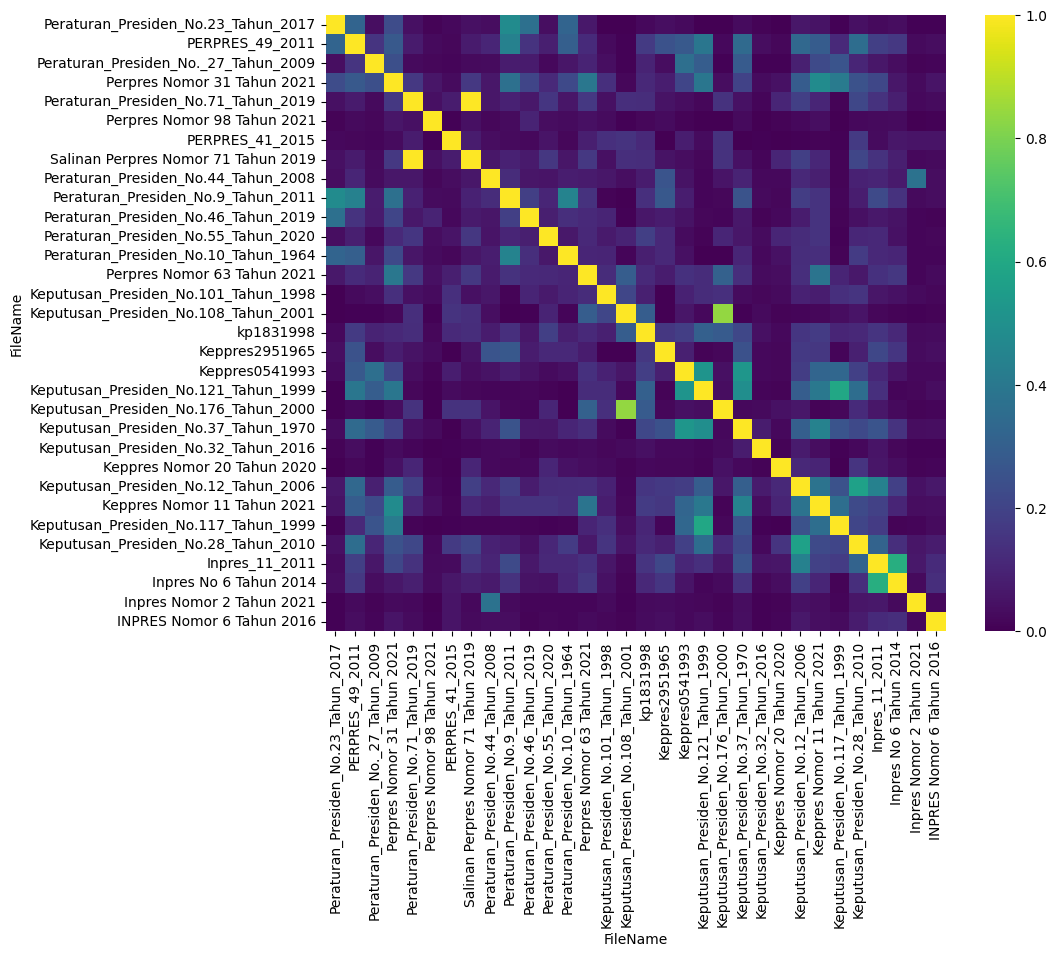

In [151]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [152]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = cosine_similarity_df.applymap(convert_to_label)
label_df

FileName                             Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                   
Peraturan_Presiden_No.23_Tahun_2017                              Selaras   
PERPRES_49_2011                                                   Netral   
Peraturan_Presiden_No._27_Tahun_2009                       Tidak Selaras   
Perpres Nomor 31 Tahun 2021                                       Netral   
Peraturan_Presiden_No.71_Tahun_2019                        Tidak Selaras   
Perpres Nomor 98 Tahun 2021                                Tidak Selaras   
PERPRES_41_2015                                            Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019                        Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008                        Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011                               Selaras   
Peraturan_Presiden_No.46_Tahun_2019                               Netral   
Peraturan_Presiden_No.55_Tahun_2020                        Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964                               Netral   
Perpres Nomor 63 Tahun 2021                                Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998                       Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001                       Tidak Selaras   
kp1831998                                                  Tidak Selaras   
Keppres2951965                                             Tidak Selaras   
Keppres0541993                                             Tidak Selaras   
Keputusan_Presiden_No.121_Tahun_1999                       Tidak Selaras   
Keputusan_Presiden_No.176_Tahun_2000                       Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970                        Tidak Selaras   
Keputusan_Presiden_No.32_Tahun_2016                        Tidak Selaras   
Keppres Nomor 20 Tahun 2020                                Tidak Selaras   
Keputusan_Presiden_No.12_Tahun_2006                        Tidak Selaras   
Keppres Nomor 11 Tahun 2021                                Tidak Selaras   
Keputusan_Presiden_No.117_Tahun_1999                       Tidak Selaras   
Keputusan_Presiden_No.28_Tahun_2010                        Tidak Selaras   
Inpres_11_2011                                             Tidak Selaras   
Inpres No 6 Tahun 2014                                     Tidak Selaras   
Inpres Nomor 2 Tahun 2021                                  Tidak Selaras   
INPRES Nomor 6 Tahun 2016                                  Tidak Selaras   

FileName                             PERPRES_49_2011  \
FileName                                               
Peraturan_Presiden_No.23_Tahun_2017           Netral   
PERPRES_49_2011                              Selaras   
Peraturan_Presiden_No._27_Tahun_2009          Netral   
Perpres Nomor 31 Tahun 2021                   Netral   
Peraturan_Presiden_No.71_Tahun_2019    Tidak Selaras   
Perpres Nomor 98 Tahun 2021            Tidak Selaras   
PERPRES_41_2015                        Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019    Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008           Netral   
Peraturan_Presiden_No.9_Tahun_2011           Selaras   
Peraturan_Presiden_No.46_Tahun_2019           Netral   
Peraturan_Presiden_No.55_Tahun_2020    Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964           Netral   
Perpres Nomor 63 Tahun 2021                   Netral   
Keputusan_Presiden_No.101_Tahun_1998   Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001   Tidak Selaras   
kp1831998                                     Netral   
Keppres2951965                                Netral   
Keppres0541993                                Netral   
Keputusan_Presiden_No.121_Tahun_1999          Netral   
Keputusan_Presiden_No.176_Tahun_2000   Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970           Netral   
Keputusan_Presiden_No.32_Tahun_2016    Tidak Selaras   
Keppres Nomor 2

In [153]:
# Ubah menjadi bentuk menyerupai matriks segitiga sehingga tidak terjadi duplikat
mask = np.triu(np.ones(label_df.shape, dtype=bool), k=0)

# Set the upper triangle values to NaN
label_df.mask(mask, inplace=True)

In [154]:
label_df

FileName                             Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                   
Peraturan_Presiden_No.23_Tahun_2017                                  NaN   
PERPRES_49_2011                                                   Netral   
Peraturan_Presiden_No._27_Tahun_2009                       Tidak Selaras   
Perpres Nomor 31 Tahun 2021                                       Netral   
Peraturan_Presiden_No.71_Tahun_2019                        Tidak Selaras   
Perpres Nomor 98 Tahun 2021                                Tidak Selaras   
PERPRES_41_2015                                            Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019                        Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008                        Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011                               Selaras   
Peraturan_Presiden_No.46_Tahun_2019                               Netral   
Peraturan_Presiden_No.55_Tahun_2020                        Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964                               Netral   
Perpres Nomor 63 Tahun 2021                                Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998                       Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001                       Tidak Selaras   
kp1831998                                                  Tidak Selaras   
Keppres2951965                                             Tidak Selaras   
Keppres0541993                                             Tidak Selaras   
Keputusan_Presiden_No.121_Tahun_1999                       Tidak Selaras   
Keputusan_Presiden_No.176_Tahun_2000                       Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970                        Tidak Selaras   
Keputusan_Presiden_No.32_Tahun_2016                        Tidak Selaras   
Keppres Nomor 20 Tahun 2020                                Tidak Selaras   
Keputusan_Presiden_No.12_Tahun_2006                        Tidak Selaras   
Keppres Nomor 11 Tahun 2021                                Tidak Selaras   
Keputusan_Presiden_No.117_Tahun_1999                       Tidak Selaras   
Keputusan_Presiden_No.28_Tahun_2010                        Tidak Selaras   
Inpres_11_2011                                             Tidak Selaras   
Inpres No 6 Tahun 2014                                     Tidak Selaras   
Inpres Nomor 2 Tahun 2021                                  Tidak Selaras   
INPRES Nomor 6 Tahun 2016                                  Tidak Selaras   

FileName                             PERPRES_49_2011  \
FileName                                               
Peraturan_Presiden_No.23_Tahun_2017              NaN   
PERPRES_49_2011                                  NaN   
Peraturan_Presiden_No._27_Tahun_2009          Netral   
Perpres Nomor 31 Tahun 2021                   Netral   
Peraturan_Presiden_No.71_Tahun_2019    Tidak Selaras   
Perpres Nomor 98 Tahun 2021            Tidak Selaras   
PERPRES_41_2015                        Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019    Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008           Netral   
Peraturan_Presiden_No.9_Tahun_2011           Selaras   
Peraturan_Presiden_No.46_Tahun_2019           Netral   
Peraturan_Presiden_No.55_Tahun_2020    Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964           Netral   
Perpres Nomor 63 Tahun 2021                   Netral   
Keputusan_Presiden_No.101_Tahun_1998   Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001   Tidak Selaras   
kp1831998                                     Netral   
Keppres2951965                                Netral   
Keppres0541993                                Netral   
Keputusan_Presiden_No.121_Tahun_1999          Netral   
Keputusan_Presiden_No.176_Tahun_2000   Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970           Netral   
Keputusan_Presiden_No.32_Tahun_2016    Tidak Selaras   
Keppres Nomor 2

### Total

In [155]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral         167.0
Selaras         16.0
Tidak Selaras  313.0

### Peraturan Presiden yang Selaras

In [156]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                          Perundangan2
0    Salinan Perpres Nomor 71 Tahun 2019   Peraturan_Presiden_No.71_Tahun_2019
1     Peraturan_Presiden_No.9_Tahun_2011   Peraturan_Presiden_No.23_Tahun_2017
2     Peraturan_Presiden_No.9_Tahun_2011                       PERPRES_49_2011
3    Peraturan_Presiden_No.10_Tahun_1964    Peraturan_Presiden_No.9_Tahun_2011
4   Keputusan_Presiden_No.121_Tahun_1999                        Keppres0541993
5   Keputusan_Presiden_No.176_Tahun_2000  Keputusan_Presiden_No.108_Tahun_2001
6    Keputusan_Presiden_No.37_Tahun_1970                        Keppres0541993
7    Keputusan_Presiden_No.37_Tahun_1970  Keputusan_Presiden_No.121_Tahun_1999
8            Keppres Nomor 11 Tahun 2021           Perpres Nomor 31 Tahun 2021
9            Keppres Nomor 11 Tahun 2021  Keputusan_Presiden_No.121_Tahun_1999
10           Keppres Nomor 11 Tahun 2021   Keputusan_Presiden_No.37_Tahun_1970
11  Keputusan_Presiden_No.117_Tahun_1999           Perpres Nomor 31 Tahun 2021
12  Keputusan_Presiden_No.117_Tahun_1999  Keputusan_Presiden_No.121_Tahun_1999
13   Keputusan_Presiden_No.28_Tahun_2010   Keputusan_Presiden_No.12_Tahun_2006
14                        Inpres_11_2011   Keputusan_Presiden_No.12_Tahun_2006
15                Inpres No 6 Tahun 2014                        Inpres_11_2011

In [157]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [158]:
df_selaras

Perundangan1  \
0    Salinan Perpres Nomor 71 Tahun 2019   
1     Peraturan_Presiden_No.9_Tahun_2011   
2     Peraturan_Presiden_No.9_Tahun_2011   
3    Peraturan_Presiden_No.10_Tahun_1964   
4   Keputusan_Presiden_No.121_Tahun_1999   
5   Keputusan_Presiden_No.176_Tahun_2000   
6    Keputusan_Presiden_No.37_Tahun_1970   
7    Keputusan_Presiden_No.37_Tahun_1970   
8            Keppres Nomor 11 Tahun 2021   
9            Keppres Nomor 11 Tahun 2021   
10           Keppres Nomor 11 Tahun 2021   
11  Keputusan_Presiden_No.117_Tahun_1999   
12  Keputusan_Presiden_No.117_Tahun_1999   
13   Keputusan_Presiden_No.28_Tahun_2010   
14                        Inpres_11_2011   
15                Inpres No 6 Tahun 2014   

                            Perundangan2  \
0    Peraturan_Presiden_No.71_Tahun_2019   
1    Peraturan_Presiden_No.23_Tahun_2017   
2                        PERPRES_49_2011   
3     Peraturan_Presiden_No.9_Tahun_2011   
4                         Keppres0541993   
5   Keputusan_Presiden_No.108_Tahun_2001   
6                         Keppres0541993   
7   Keputusan_Presiden_No.121_Tahun_1999   
8            Perpres Nomor 31 Tahun 2021   
9   Keputusan_Presiden_No.121_Tahun_1999   
10   Keputusan_Presiden_No.37_Tahun_1970   
11           Perpres Nomor 31 Tahun 2021   
12  Keputusan_Presiden_No.121_Tahun_1999   
13   Keputusan_Presiden_No.12_Tahun_2006   
14   Keputusan_Presiden_No.12_Tahun_2006   
15                        Inpres_11_2011   

                                               Topic1  \
0   atur presiden menteri koordinator bidang marit...   
1   atur presiden tugas pusat investasi perintah p...   
2   atur presiden tugas pusat investasi perintah p...   
3   atur presiden republik indonesia panitia negar...   
4   tetap putus presiden ubah putus presiden nomor...   
5   putus presiden susun organisasi tugas menteri ...   
6   putus presiden republik indonesia bentuk team ...   
7   putus presiden republik indonesia bentuk team ...   
8     tetap putus presiden satu tugas cepat investasi   
9     tetap putus presiden satu tugas cepat investasi   
10    tetap putus presiden satu tugas cepat investasi   
11  tetap putus presiden ubah putus presiden nomor...   
12  tetap putus presiden ubah putus presiden nomor...   
13  putus presiden ubah putus presiden nomor 3 200...   
14          presiden republik indonesia nomor 11 2011   
15                        presiden republik indonesia   

                                               Topic2  
0   atur presiden menteri koordinator bidang marit...  
1   atur presiden kesah credit guarantee and inves...  
2                         presiden republik indonesia  
3   atur presiden tugas pusat investasi perintah p...  
4    cabut putus presiden nomor 32 1992 daftar bidang  
5   putus presiden unit organisasi tugas eselon me...  
6    cabut putus presiden nomor 32 1992 daftar bidang  
7   tetap putus presiden ubah putus presiden nomor...  
8   atur presiden tata tugas fungsi menteri didik ...  
9   tetap putus presiden ubah putus presiden nomor...  
10  putus presiden republik indonesia bentuk team ...  
11  atur presiden tata tugas fungsi menteri didik ...  
12  tetap putus presiden ubah putus presiden nomor...  
13  putus presiden komite arah kembang kawasan eko...  
14  putus presiden komite arah kembang kawasan eko...  
15          presiden republik indonesia nomor 11 2011

In [159]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3                               PP_55_2015   
4    Peraturan_Pemerintah_No.73_Tahun_1992   
..                                     ...   
80    Keputusan_Presiden_No.117_Tahun_1999   
81    Keputusan_Presiden_No.117_Tahun_1999   
82     Keputusan_Presiden_No.28_Tahun_2010   
83                          Inpres_11_2011   
84                  Inpres No 6 Tahun 2014   

                            Perundangan2  \
0        Undang-Undang_No._24_Tahun_2011   
1          Undang-Undang_No.8_Tahun_1995   
2          Undang-Undang_No.4_Tahun_2016   
3        Undang-Undang_No._24_Tahun_2011   
4         Undang-Undang_No.40_Tahun_2014   
..                                   ...   
80           Perpres Nomor 31 Tahun 2021   
81  Keputusan_Presiden_No.121_Tahun_1999   
82   Keputusan_Presiden_No.12_Tahun_2006   
83   Keputusan_Presiden_No.12_Tahun_2006   
84                        Inpres_11_2011   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3                         presiden republik indonesia   
4         atur perintah republik indonesia selenggara   
..                                                ...   
80  tetap putus presiden ubah putus presiden nomor...   
81  tetap putus presiden ubah putus presiden nomor...   
82  putus presiden ubah putus presiden nomor 3 200...   
83          presiden republik indonesia nomor 11 2011   
84                        presiden republik indonesia   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4                        tetap undang undang asuransi  
..                                                ...  
80  atur presiden tata tugas fungsi menteri didik ...  
81  tetap putus presiden ubah putus presiden nomor...  
82  putus presiden komite arah kembang kawasan eko...  
83  putus presiden komite arah kembang kawasan eko...  
84          presiden republik indonesia nomor 11 2011  

[85 rows x 4 columns]

## Peraturan Menteri

In [160]:
selected_df = df.query('Tingkatan == "Peraturan Menteri"')
selected_df.tail()

Tingkatan                          FileName  \
85  Peraturan Menteri  PERMEN_PERIN_64MINDPER72016_2016   
86  Peraturan Menteri      KEPMGK_INVBKPM_12SK1999_1999   
87  Peraturan Menteri      KEPMGK_INVBKPM_33SK1998_1998   
88  Peraturan Menteri      KEPMGK_INVBKPM_38SK1999_1999   
89  Peraturan Menteri       PERMEN_KEU_53PMK052020_2020   

                                        ExtractedText  \
85  :\n\nPERATURAN MENTERI PERINDUSTRIAN TENTANG B...   
86  :\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INVES...   
87  :\n\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INV...   
88  MENETAPKAN:\nKEPUTUSAN MENTERI NEGARA INVESTAS...   
89  :\n\nMenetapkan       :        PERATURAN MENTE...   

                                         cleaned_text  \
85  [atur menteri industri besar tenaga kerja nila...   
86                                                 []   
87  [tetap putus menteri negara investasi kepala b...   
88  [tetap putus menteri negara investasi kepala b...   
89                                                 []   

                                           final_text  
85  atur menteri industri besar tenaga kerja nilai...  
86                                                     
87  tetap putus menteri negara investasi kepala ba...  
88  tetap putus menteri negara investasi kepala ba...  
89

In [161]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 200)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [162]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(25, 200)


In [163]:
print("Feature Names:")
print(feature_names)

Feature Names:
['2015 no' '2015 no 1785' '34 aval' '34 aval lalitt' 'akuntan publik'
 'akuntansi lapor' 'akuntansi lapor uang' 'anggar dapat' 'anggar satu'
 'anggar satu kerja' 'arsip dinamis' 'aset daerah' 'asisten deputi'
 'atur atur' 'atur daerah' 'atur menteri' 'atur menteri uang'
 'atur undang' 'atur undang undang' 'aval lalitt' 'aval lalitt maelii'
 'ayat cantum' 'ayat cantum lampir' 'ayat huruf' 'ba bun' 'badan layan'
 'badan usaha' 'badan usaha milik' 'bahan koordinasi'
 'bahan koordinasi telaah' 'bahan rancang' 'bahan rancang rumus'
 'belanja daerah' 'bendahara negara' 'berita negara'
 'berita negara republik' 'biaya usaha' 'biaya usaha mikro'
 'bidang ekonomi' 'bidang kelola' 'bidang kelola lingkung'
 'bidang lingkung' 'bidang maritim' 'bidang maritim investasi'
 'bijak kelola' 'budaya lingkung' 'buku jurnal' 'bun ayat' 'bun investasi'
 'bun investasi perintah' 'cantum lampir' 'daerah apbd' 'daerah ayat'
 'dana cadang' 'dana lingkung' 'dana pensiun' 'dapat belanja'
 'direktor

### Document-Term Matrix

In [164]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

2015 no  2015 no 1785  \
FileName                                                                    
PERMEN_KEU_231PMK062017_2017                        0.00000       0.00000   
KEPMEN_KEU_511KMK062002_2002                        0.00000       0.00000   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.00000       0.00000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.00000       0.00000   
KEPMEN_DAGRI_29_2002                                0.00000       0.00000   
KEPMEN_KEU_509KMK062002_2002                        0.00000       0.00000   
PERMEN_KEU_103PMK052019_2019                        0.00000       0.00000   
KEPMNG_LH_9_2001                                    0.00000       0.00000   
PERMEN_DAGRI_52_2012                                0.00000       0.00000   
PERMEN_KEU_91PMK012017_2017                         0.00000       0.00000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.00000       0.00000   
PERMEN_KEU_209PMK052015_2015                        0.36139       0.36139   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.00000       0.00000   
PERMEN_KOMARVES_6_2020                              0.00000       0.00000   
pmmarves001_2022                                    0.00000       0.00000   
PERMEN_KEU_119PMK082016_2016                        0.00000       0.00000   
Keputusan Menteri_KP_45_Tahun_2015                  0.00000       0.00000   
1_PMK.05_2021                                       0.00000       0.00000   
PERMEN_KEU_50PMK0102019_2019                        0.00000       0.00000   
pmmarves002_2021                                    0.00000       0.00000   
PERMEN_PERIN_64MINDPER72016_2016                    0.00000       0.00000   
KEPMGK_INVBKPM_12SK1999_1999                        0.00000       0.00000   
KEPMGK_INVBKPM_33SK1998_1998                        0.00000       0.00000   
KEPMGK_INVBKPM_38SK1999_1999                        0.00000       0.00000   
PERMEN_KEU_53PMK052020_2020                         0.00000       0.00000   

                                                     34 aval  34 aval lalitt  \
FileName                                                                       
PERMEN_KEU_231PMK062017_2017                        0.000000        0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.000000        0.000000   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000        0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000        0.000000   
KEPMEN_DAGRI_29_2002                                0.000000        0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000        0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000        0.000000   
KEPMNG_LH_9_2001                                    0.119772        0.119772   
PERMEN_DAGRI_52_2012                                0.000000        0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000        0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000        0.000000   
PERMEN_KEU_209PMK052015_2015                        0.000000        0.000000   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000        0.000000   
PERMEN_KOMARVES_6_2020                              0.000000        0.000000   
pmmarves001_2022                                    0.000000        0.000000   
PERMEN_KEU_119PMK082016_2016                        0.000000        0.000000   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000        0.000000   
1_PMK.05_2021                                       0.000000        0.000000   
PERMEN_KEU_50PMK0102019_2019                        0.000000        0.000000   
pmmarves002_2021                                    0.000000        0.000000   
PERMEN_PERIN_64MINDPER72016_2016                    0.000000        0.000000   
KEPMGK_INVBKPM_12SK1999_1999                        0.000000        0.000000   
KEPMGK_INVBKPM_33SK1998_1998                        

### Calculate the similarity

In [165]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

In [166]:
cosine_similarity_df

FileName                                            PERMEN_KEU_231PMK062017_2017  \
FileName                                                                           
PERMEN_KEU_231PMK062017_2017                                            1.000000   
KEPMEN_KEU_511KMK062002_2002                                            0.012860   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                   0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                     0.028513   
KEPMEN_DAGRI_29_2002                                                    0.023386   
KEPMEN_KEU_509KMK062002_2002                                            0.153053   
PERMEN_KEU_103PMK052019_2019                                            0.192807   
KEPMNG_LH_9_2001                                                        0.004525   
PERMEN_DAGRI_52_2012                                                    0.150648   
PERMEN_KEU_91PMK012017_2017                                             0.105883   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                      0.122645   
PERMEN_KEU_209PMK052015_2015                                            0.323468   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                      0.235917   
PERMEN_KOMARVES_6_2020                                                  0.030214   
pmmarves001_2022                                                        0.007112   
PERMEN_KEU_119PMK082016_2016                                            0.024030   
Keputusan Menteri_KP_45_Tahun_2015                                      0.004297   
1_PMK.05_2021                                                           0.154871   
PERMEN_KEU_50PMK0102019_2019                                            0.280016   
pmmarves002_2021                                                        0.004030   
PERMEN_PERIN_64MINDPER72016_2016                                        0.039393   
KEPMGK_INVBKPM_12SK1999_1999                                            0.000000   
KEPMGK_INVBKPM_33SK1998_1998                                            0.004144   
KEPMGK_INVBKPM_38SK1999_1999                                            0.001931   
PERMEN_KEU_53PMK052020_2020                                             0.000000   

FileName                                            KEPMEN_KEU_511KMK062002_2002  \
FileName                                                                           
PERMEN_KEU_231PMK062017_2017                                            0.012860   
KEPMEN_KEU_511KMK062002_2002                                            1.000000   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                   0.022641   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                     0.012289   
KEPMEN_DAGRI_29_2002                                                    0.007649   
KEPMEN_KEU_509KMK062002_2002                                            0.665993   
PERMEN_KEU_103PMK052019_2019                                            0.021141   
KEPMNG_LH_9_2001                                                        0.001392   
PERMEN_DAGRI_52_2012                                                    0.026105   
PERMEN_KEU_91PMK012017_2017                                             0.035141   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                      0.028983   
PERMEN_KEU_209PMK052015_2015                                            0.039895   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                      0.060727   
PERMEN_KOMARVES_6_2020                                                  0.015239   
pmmarves001_2022                                                        0.012141   
PERMEN_KEU_119PMK082016_2016                                            0.113905   
Keputusan Menteri_KP_45_Tahun_2015                                      0.027198   
1_PMK.05_2021                                                           0.037979   
PERMEN_KEU_50PMK0102019_2019                       

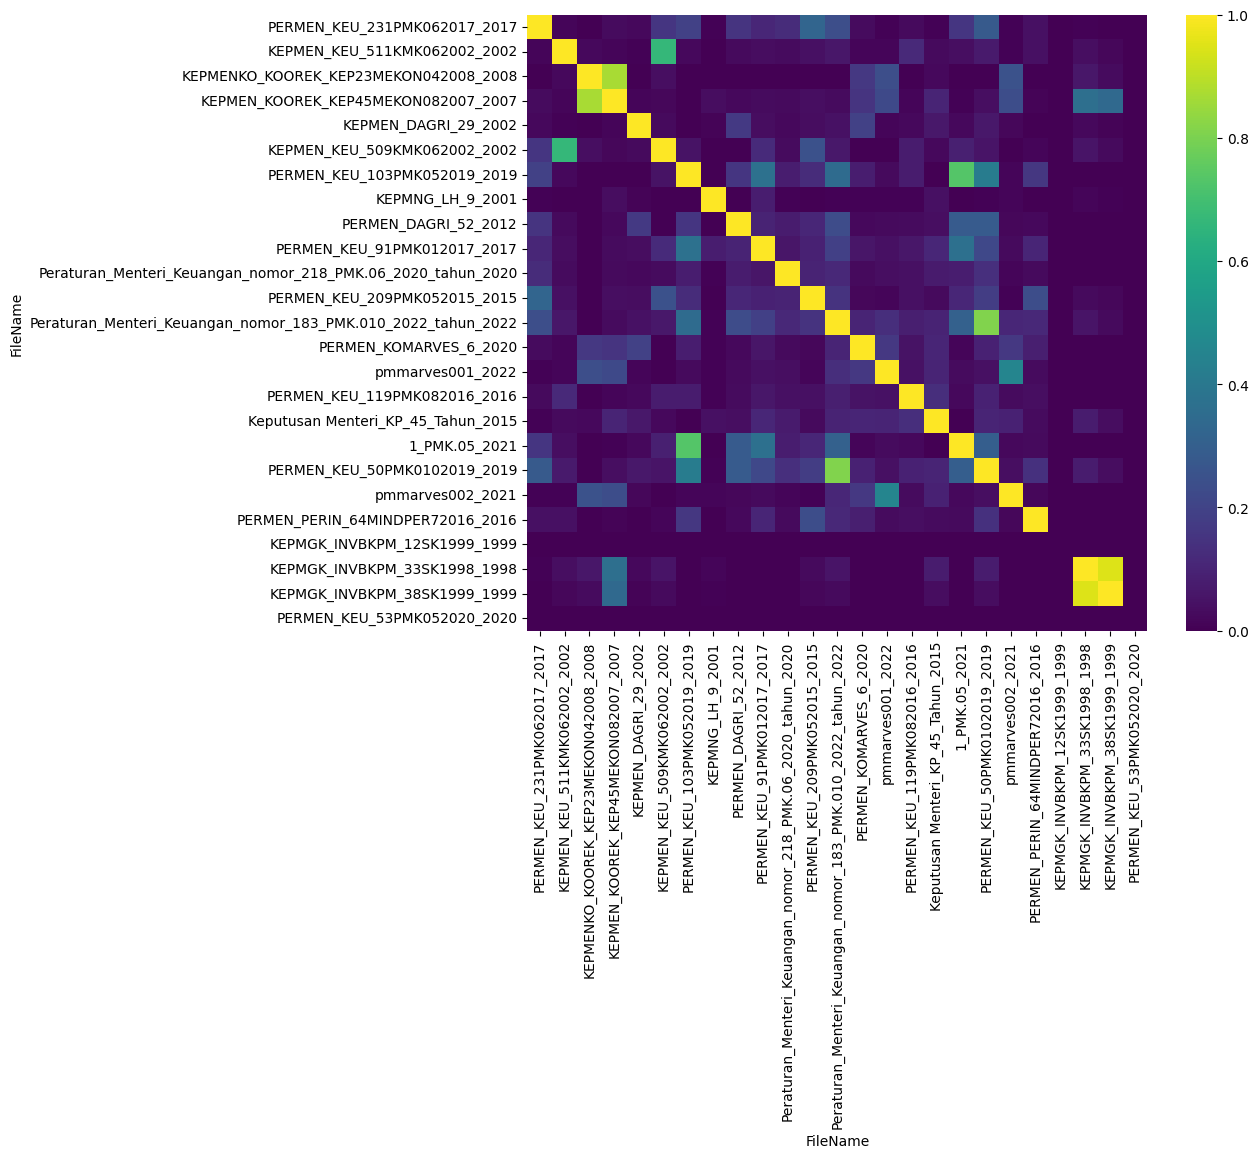

In [167]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [168]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = cosine_similarity_df.applymap(convert_to_label)
label_df

FileName                                           PERMEN_KEU_231PMK062017_2017  \
FileName                                                                          
PERMEN_KEU_231PMK062017_2017                                            Selaras   
KEPMEN_KEU_511KMK062002_2002                                      Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                             Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                               Tidak Selaras   
KEPMEN_DAGRI_29_2002                                              Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                             Netral   
PERMEN_KEU_103PMK052019_2019                                             Netral   
KEPMNG_LH_9_2001                                                  Tidak Selaras   
PERMEN_DAGRI_52_2012                                                     Netral   
PERMEN_KEU_91PMK012017_2017                                              Netral   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                       Netral   
PERMEN_KEU_209PMK052015_2015                                             Netral   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                       Netral   
PERMEN_KOMARVES_6_2020                                            Tidak Selaras   
pmmarves001_2022                                                  Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                      Tidak Selaras   
Keputusan Menteri_KP_45_Tahun_2015                                Tidak Selaras   
1_PMK.05_2021                                                            Netral   
PERMEN_KEU_50PMK0102019_2019                                             Netral   
pmmarves002_2021                                                  Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2016                                  Tidak Selaras   
KEPMGK_INVBKPM_12SK1999_1999                                      Tidak Selaras   
KEPMGK_INVBKPM_33SK1998_1998                                      Tidak Selaras   
KEPMGK_INVBKPM_38SK1999_1999                                      Tidak Selaras   
PERMEN_KEU_53PMK052020_2020                                       Tidak Selaras   

FileName                                           KEPMEN_KEU_511KMK062002_2002  \
FileName                                                                          
PERMEN_KEU_231PMK062017_2017                                      Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                                            Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                             Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                               Tidak Selaras   
KEPMEN_DAGRI_29_2002                                              Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                            Selaras   
PERMEN_KEU_103PMK052019_2019                                      Tidak Selaras   
KEPMNG_LH_9_2001                                                  Tidak Selaras   
PERMEN_DAGRI_52_2012                                              Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                       Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                      Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                Tidak Selaras   
PERMEN_KOMARVES_6_2020                                            Tidak Selaras   
pmmarves001_2022                                                  Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                             Netral   
Keputusan Menteri_KP_45_Tahun_2015                                Tidak Selaras   
1_PMK.05_2021                                                     Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                      Tidak Selaras   
pmmarves002_202

In [169]:
# Ubah menjadi bentuk menyerupai matriks segitiga sehingga tidak terjadi duplikat
mask = np.triu(np.ones(label_df.shape, dtype=bool), k=0)

# Set the upper triangle values to NaN
label_df.mask(mask, inplace=True)

In [170]:
label_df

FileName                                           PERMEN_KEU_231PMK062017_2017  \
FileName                                                                          
PERMEN_KEU_231PMK062017_2017                                                NaN   
KEPMEN_KEU_511KMK062002_2002                                      Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                             Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                               Tidak Selaras   
KEPMEN_DAGRI_29_2002                                              Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                             Netral   
PERMEN_KEU_103PMK052019_2019                                             Netral   
KEPMNG_LH_9_2001                                                  Tidak Selaras   
PERMEN_DAGRI_52_2012                                                     Netral   
PERMEN_KEU_91PMK012017_2017                                              Netral   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                       Netral   
PERMEN_KEU_209PMK052015_2015                                             Netral   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                       Netral   
PERMEN_KOMARVES_6_2020                                            Tidak Selaras   
pmmarves001_2022                                                  Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                      Tidak Selaras   
Keputusan Menteri_KP_45_Tahun_2015                                Tidak Selaras   
1_PMK.05_2021                                                            Netral   
PERMEN_KEU_50PMK0102019_2019                                             Netral   
pmmarves002_2021                                                  Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2016                                  Tidak Selaras   
KEPMGK_INVBKPM_12SK1999_1999                                      Tidak Selaras   
KEPMGK_INVBKPM_33SK1998_1998                                      Tidak Selaras   
KEPMGK_INVBKPM_38SK1999_1999                                      Tidak Selaras   
PERMEN_KEU_53PMK052020_2020                                       Tidak Selaras   

FileName                                           KEPMEN_KEU_511KMK062002_2002  \
FileName                                                                          
PERMEN_KEU_231PMK062017_2017                                                NaN   
KEPMEN_KEU_511KMK062002_2002                                                NaN   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                             Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                               Tidak Selaras   
KEPMEN_DAGRI_29_2002                                              Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                            Selaras   
PERMEN_KEU_103PMK052019_2019                                      Tidak Selaras   
KEPMNG_LH_9_2001                                                  Tidak Selaras   
PERMEN_DAGRI_52_2012                                              Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                       Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                      Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                Tidak Selaras   
PERMEN_KOMARVES_6_2020                                            Tidak Selaras   
pmmarves001_2022                                                  Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                             Netral   
Keputusan Menteri_KP_45_Tahun_2015                                Tidak Selaras   
1_PMK.05_2021                                                     Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                      Tidak Selaras   
pmmarves002_202

### Total

In [171]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Sum result
pd.DataFrame(counts['Total'])

Total
Netral          52.0
Selaras          7.0
Tidak Selaras  241.0

### Peraturan Menteri yang Selaras

In [172]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1  \
0  KEPMEN_KOOREK_KEP45MEKON082007_2007   
1         KEPMEN_KEU_509KMK062002_2002   
2                        1_PMK.05_2021   
3         PERMEN_KEU_50PMK0102019_2019   
4         PERMEN_KEU_50PMK0102019_2019   
5                     pmmarves002_2021   
6         KEPMGK_INVBKPM_38SK1999_1999   

                                        Perundangan2  
0              KEPMENKO_KOOREK_KEP23MEKON042008_2008  
1                       KEPMEN_KEU_511KMK062002_2002  
2                       PERMEN_KEU_103PMK052019_2019  
3                       PERMEN_KEU_103PMK052019_2019  
4  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...  
5                                   pmmarves001_2022  
6                       KEPMGK_INVBKPM_33SK1998_1998

In [173]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [174]:
df_selaras

Perundangan1  \
0  KEPMEN_KOOREK_KEP45MEKON082007_2007   
1         KEPMEN_KEU_509KMK062002_2002   
2                        1_PMK.05_2021   
3         PERMEN_KEU_50PMK0102019_2019   
4         PERMEN_KEU_50PMK0102019_2019   
5                     pmmarves002_2021   
6         KEPMGK_INVBKPM_38SK1999_1999   

                                        Perundangan2  \
0              KEPMENKO_KOOREK_KEP23MEKON042008_2008   
1                       KEPMEN_KEU_511KMK062002_2002   
2                       PERMEN_KEU_103PMK052019_2019   
3                       PERMEN_KEU_103PMK052019_2019   
4  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
5                                   pmmarves001_2022   
6                       KEPMGK_INVBKPM_33SK1998_1998   

                                              Topic1  \
0  putus presiden tim kembang sistem layan inform...   
1  putus menteri uang lapor uang dana pensiun men...   
2  atur menteri uang tarif layan badan layan pusa...   
3                                  atur menteri uang   
4                                  atur menteri uang   
5  tetap atur menteri koordinator bidang maritim ...   
6  tetap putus menteri negara investasi kepala ba...   

                                              Topic2  
0  putus menteri koordinator bidang ekonomi ketua...  
1  putus menteri uang investasi dana pensiun ment...  
2  tetap atur menteri uang standar layan minimum ...  
3  tetap atur menteri uang standar layan minimum ...  
4  tetap atur menteri uang tambah investasi perin...  
5  tetap atur menteri koordinator bidang maritim ...  
6  tetap putus menteri negara investasi kepala ba...

In [175]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3                               PP_55_2015   
4    Peraturan_Pemerintah_No.73_Tahun_1992   
..                                     ...   
87                           1_PMK.05_2021   
88            PERMEN_KEU_50PMK0102019_2019   
89            PERMEN_KEU_50PMK0102019_2019   
90                        pmmarves002_2021   
91            KEPMGK_INVBKPM_38SK1999_1999   

                                         Perundangan2  \
0                     Undang-Undang_No._24_Tahun_2011   
1                       Undang-Undang_No.8_Tahun_1995   
2                       Undang-Undang_No.4_Tahun_2016   
3                     Undang-Undang_No._24_Tahun_2011   
4                      Undang-Undang_No.40_Tahun_2014   
..                                                ...   
87                       PERMEN_KEU_103PMK052019_2019   
88                       PERMEN_KEU_103PMK052019_2019   
89  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
90                                   pmmarves001_2022   
91                       KEPMGK_INVBKPM_33SK1998_1998   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3                         presiden republik indonesia   
4         atur perintah republik indonesia selenggara   
..                                                ...   
87  atur menteri uang tarif layan badan layan pusa...   
88                                  atur menteri uang   
89                                  atur menteri uang   
90  tetap atur menteri koordinator bidang maritim ...   
91  tetap putus menteri negara investasi kepala ba...   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4                        tetap undang undang asuransi  
..                                                ...  
87  tetap atur menteri uang standar layan minimum ...  
88  tetap atur menteri uang standar layan minimum ...  
89  tetap atur menteri uang tambah investasi perin...  
90  tetap atur menteri koordinator bidang maritim ...  
91  tetap putus menteri negara investasi kepala ba...  

[92 rows x 4 columns]

# Graph

In [176]:
# Create a graph and add edges based on the similarities between 'Perundangan1' and 'Perundangan2'
G = nx.Graph()
for idx, row in all_selaras.iterrows():
  G.add_edge(row['Perundangan1'], row['Perundangan2'])

# Find connected components (topics) in the graph
topics = list(nx.connected_components(G))

# Convert the topics to a dictionary with keys as 'Topic1', 'Topic2', etc.
topics_dict = {f"Klaster{i+1}": list(topic) for i, topic in enumerate(topics)}

In [177]:
topics

[{'Inpres Nomor 2 Tahun 2021',
  'PP_55_2015',
  'Peraturan_Pemerintah_No.53_Tahun_2018',
  'Peraturan_Pemerintah_No.73_Tahun_2016',
  'Peraturan_Pemerintah_No.99_Tahun_2013',
  'Peraturan_Presiden_No.44_Tahun_2008',
  'Undang-Undang_No._24_Tahun_2011'},
 {'Peraturan_Pemerintah_No._45_Tahun_1995',
  'Perpu Nomor 1 Tahun 2020',
  'Salinan UU Nomor 9 Tahun 2020',
  'UU_34_1964',
  'Undang-Undang_No.13_Tahun_1962',
  'Undang-Undang_No.22_Tahun_2006',
  'Undang-Undang_No.27_Tahun_2014',
  'Undang-Undang_No.8_Tahun_1995'},
 {'Peraturan_Pemerintah_No.25_Tahun_2020', 'Undang-Undang_No.4_Tahun_2016'},
 {'Peraturan_Pemerintah_No.73_Tahun_1992', 'Undang-Undang_No.40_Tahun_2014'},
 {'PERMEN_KEU_119PMK082016_2016', 'Undang-Undang_No.11_Tahun_2016'},
 {'KEPMEN_KEU_509KMK062002_2002',
  'KEPMEN_KEU_511KMK062002_2002',
  'Peraturan_Pemerintah_No.77_Tahun_1992'},
 {'KEPMEN_DAGRI_29_2002', 'Peraturan_Pemerintah_No.105_Tahun_2000'},
 {'1_PMK.05_2021',
  'PERMEN_DAGRI_52_2012',
  'PERMEN_KEU_103PMK052019

<ipython-input-178-22881a41d777>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


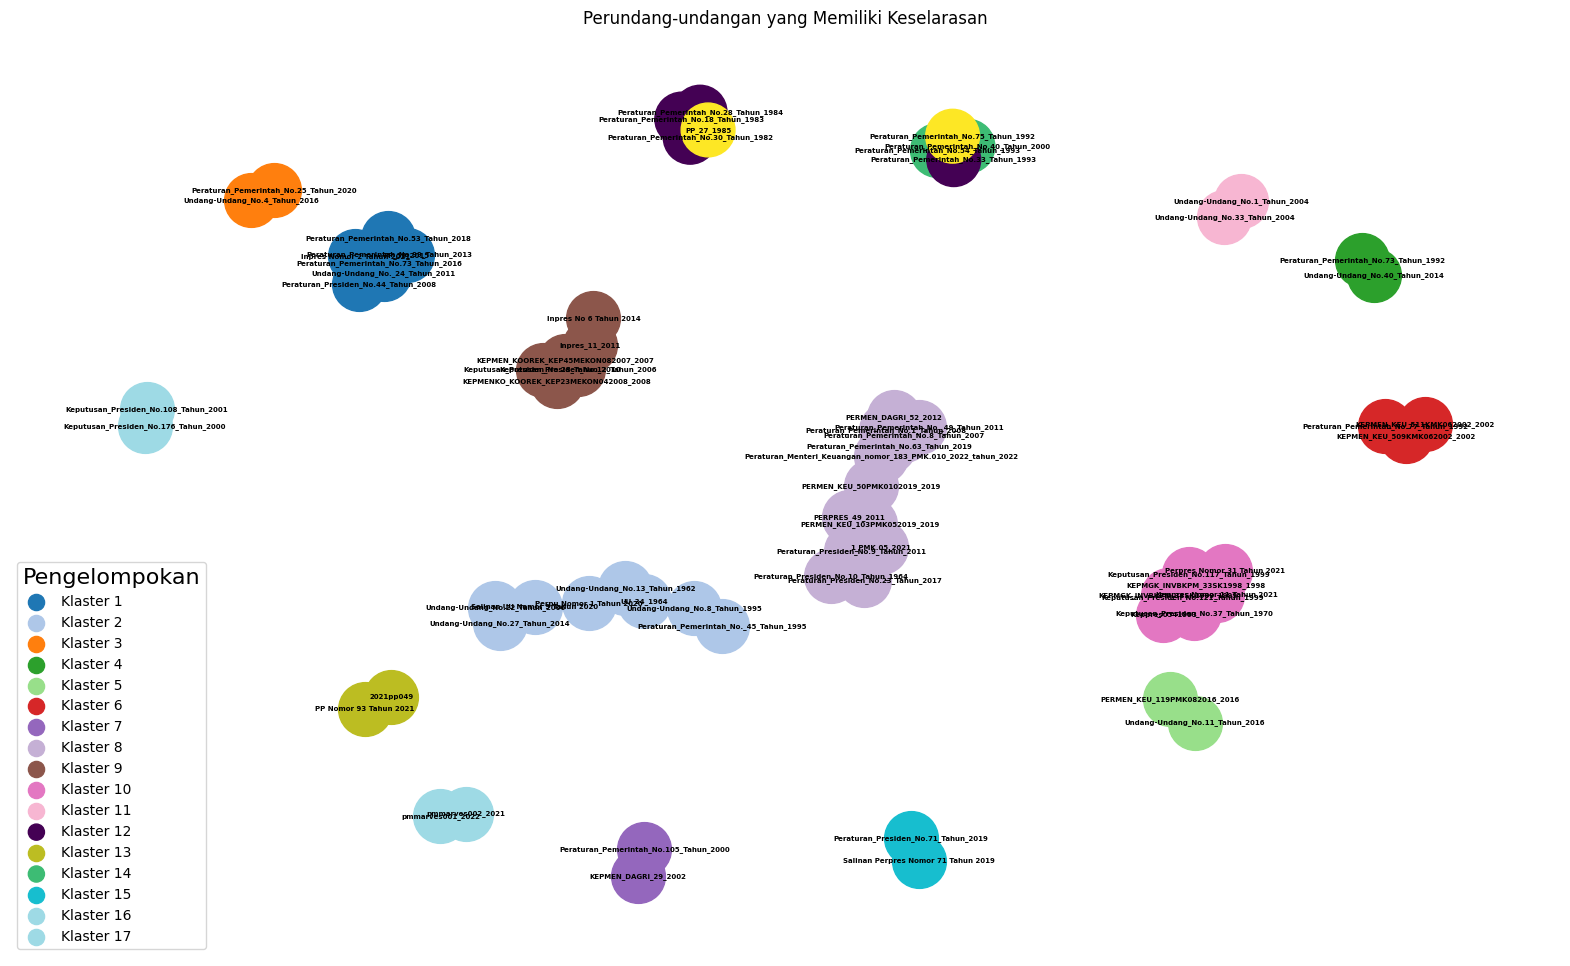

In [178]:
# Visualize the graph
pos = nx.spring_layout(G, seed = 55)
plt.figure(figsize=(20, 12))
num_colors = 16
colormap = plt.cm.get_cmap('tab20', num_colors)
for i, topic in enumerate(topics):
  color = colormap(i)
  nx.draw_networkx_nodes(G, pos, nodelist=topic, node_color=color, label=f"Klaster {i+1}", node_size=1500)
nx.draw_networkx_edges(G, pos, alpha=0.5)

label_pos = {node: (x, y) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=5, font_color='black', font_weight='bold')

legend = plt.legend(markerscale=0.3, fontsize=10)
legend.set_title("Pengelompokan", prop={"size": 16})
legend._legend_box.align = "left"
plt.axis('off')
plt.title("Perundang-undangan yang Memiliki Keselarasan")
plt.show()

In [179]:
topics_dict

{'Klaster1': ['Peraturan_Pemerintah_No.99_Tahun_2013',
  'PP_55_2015',
  'Peraturan_Pemerintah_No.73_Tahun_2016',
  'Inpres Nomor 2 Tahun 2021',
  'Undang-Undang_No._24_Tahun_2011',
  'Peraturan_Pemerintah_No.53_Tahun_2018',
  'Peraturan_Presiden_No.44_Tahun_2008'],
 'Klaster2': ['Undang-Undang_No.27_Tahun_2014',
  'UU_34_1964',
  'Undang-Undang_No.13_Tahun_1962',
  'Undang-Undang_No.22_Tahun_2006',
  'Perpu Nomor 1 Tahun 2020',
  'Peraturan_Pemerintah_No._45_Tahun_1995',
  'Salinan UU Nomor 9 Tahun 2020',
  'Undang-Undang_No.8_Tahun_1995'],
 'Klaster3': ['Undang-Undang_No.4_Tahun_2016',
  'Peraturan_Pemerintah_No.25_Tahun_2020'],
 'Klaster4': ['Peraturan_Pemerintah_No.73_Tahun_1992',
  'Undang-Undang_No.40_Tahun_2014'],
 'Klaster5': ['PERMEN_KEU_119PMK082016_2016',
  'Undang-Undang_No.11_Tahun_2016'],
 'Klaster6': ['KEPMEN_KEU_509KMK062002_2002',
  'Peraturan_Pemerintah_No.77_Tahun_1992',
  'KEPMEN_KEU_511KMK062002_2002'],
 'Klaster7': ['KEPMEN_DAGRI_29_2002',
  'Peraturan_Pemerintah_

**Note** : Peraturan pada topic 5 tidak semuanya memiliki keselarasan antar satu sama lain. Yang artinya antar perundangan-undangan memiliki keselarasan tidak secara langsung satu sama lain. Seperti

In [180]:
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3                               PP_55_2015   
4    Peraturan_Pemerintah_No.73_Tahun_1992   
..                                     ...   
87                           1_PMK.05_2021   
88            PERMEN_KEU_50PMK0102019_2019   
89            PERMEN_KEU_50PMK0102019_2019   
90                        pmmarves002_2021   
91            KEPMGK_INVBKPM_38SK1999_1999   

                                         Perundangan2  \
0                     Undang-Undang_No._24_Tahun_2011   
1                       Undang-Undang_No.8_Tahun_1995   
2                       Undang-Undang_No.4_Tahun_2016   
3                     Undang-Undang_No._24_Tahun_2011   
4                      Undang-Undang_No.40_Tahun_2014   
..                                                ...   
87                       PERMEN_KEU_103PMK052019_2019   
88                       PERMEN_KEU_103PMK052019_2019   
89  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
90                                   pmmarves001_2022   
91                       KEPMGK_INVBKPM_33SK1998_1998   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3                         presiden republik indonesia   
4         atur perintah republik indonesia selenggara   
..                                                ...   
87  atur menteri uang tarif layan badan layan pusa...   
88                                  atur menteri uang   
89                                  atur menteri uang   
90  tetap atur menteri koordinator bidang maritim ...   
91  tetap putus menteri negara investasi kepala ba...   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4                        tetap undang undang asuransi  
..                                                ...  
87  tetap atur menteri uang standar layan minimum ...  
88  tetap atur menteri uang standar layan minimum ...  
89  tetap atur menteri uang tambah investasi perin...  
90  tetap atur menteri koordinator bidang maritim ...  
91  tetap putus menteri negara investasi kepala ba...  

[92 rows x 4 columns]

<ipython-input-181-e938d53fed7a>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


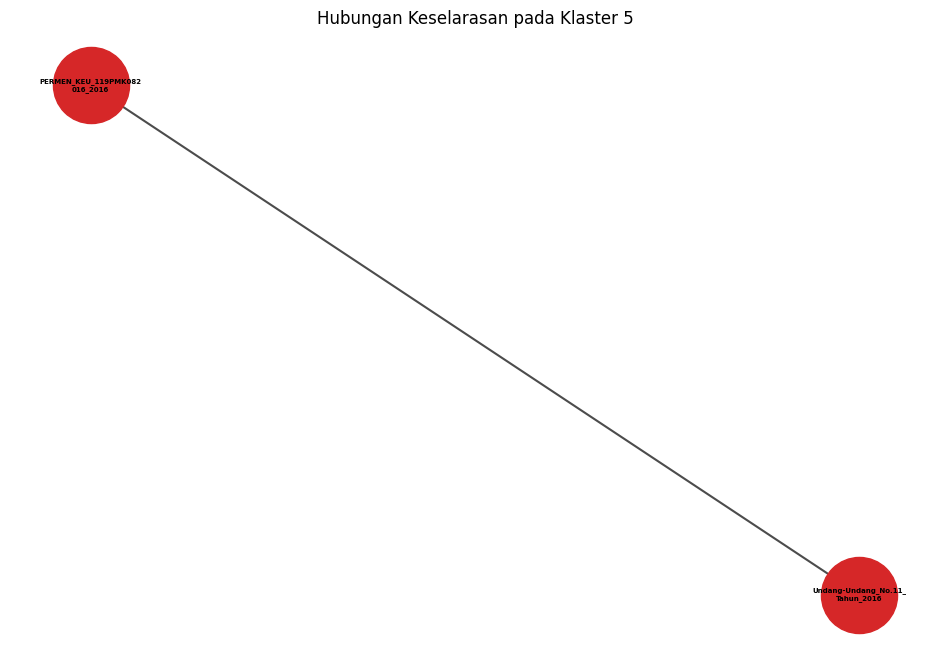

In [181]:
# Extract nodes for Topic 5
topic5 = list(topics[4])

# Create a subgraph containing only nodes from Topic 5
G_topic5 = G.subgraph(topic5)

# Visualize the subgraph for Topic 5 with larger size and 13 different colors
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_topic5, seed=42, k=1.5)

# Choose a colormap with 20 distinct colors and select the first 13 colors
num_colors = 13
colormap = plt.cm.get_cmap('tab20', num_colors)

color = colormap(4)  # Get the color for Topic 5
nx.draw_networkx_nodes(G_topic5, pos, node_color=color, node_size=3000, label=f"Topik 5")

nx.draw_networkx_edges(G_topic5, pos, width=1.5, alpha=0.7)
label_pos = {node: (x, y) for node, (x, y) in pos.items()}
wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic5.nodes()}
nx.draw_networkx_labels(G_topic5, label_pos, labels=wrapped_labels, font_size=5, font_color='black', font_weight='bold')

plt.axis('off')
plt.title("Hubungan Keselarasan pada Klaster 5")
plt.show()

<ipython-input-182-b8f227a2c24d>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)


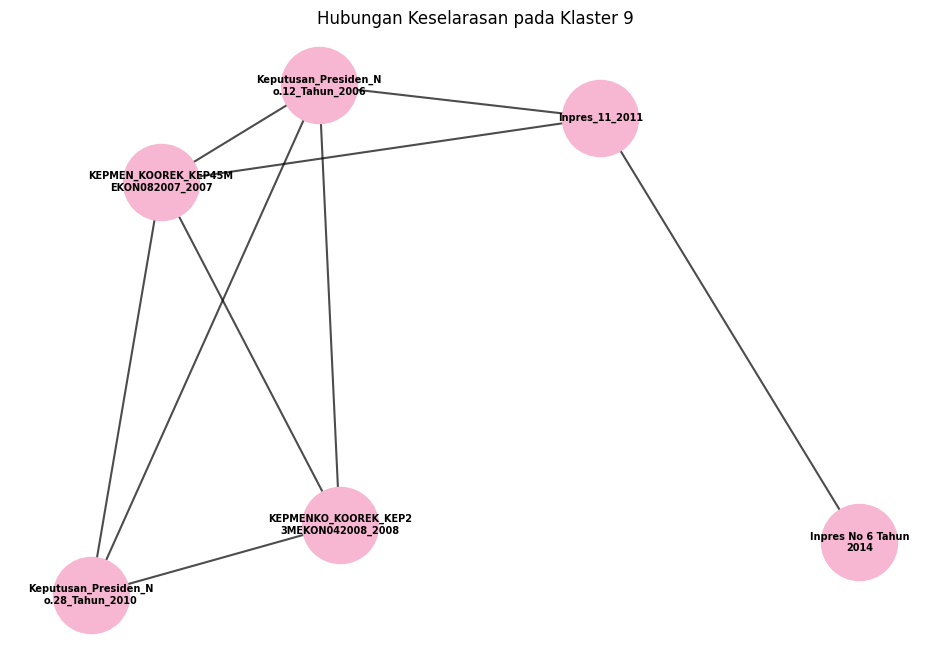

In [182]:
# Extract nodes for Topic 9
topic9 = list(topics[8])

# Create a subgraph containing only nodes from Topic 9
G_topic9 = G.subgraph(topic9)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_topic9, seed=42, k=1.5)

# Choose a colormap with 20 distinct colors and select the first 13 colors
num_colors = 13
colormap = plt.cm.get_cmap('tab20', num_colors)

color = colormap(8)  # Get the color for Topic 9
nx.draw_networkx_nodes(G_topic9, pos, node_color=color, node_size=3000, label=f"Topic 9")

nx.draw_networkx_edges(G_topic9, pos, width=1.5, alpha=0.7)
label_pos = {node: (x, y) for node, (x, y) in pos.items()}
wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic9.nodes()}
nx.draw_networkx_labels(G_topic9, label_pos, labels=wrapped_labels, font_size=7, font_color='black', font_weight='bold')

plt.axis('off')
plt.title("Hubungan Keselarasan pada Klaster 9")
plt.show()

<ipython-input-183-0fd8f084ace2>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)


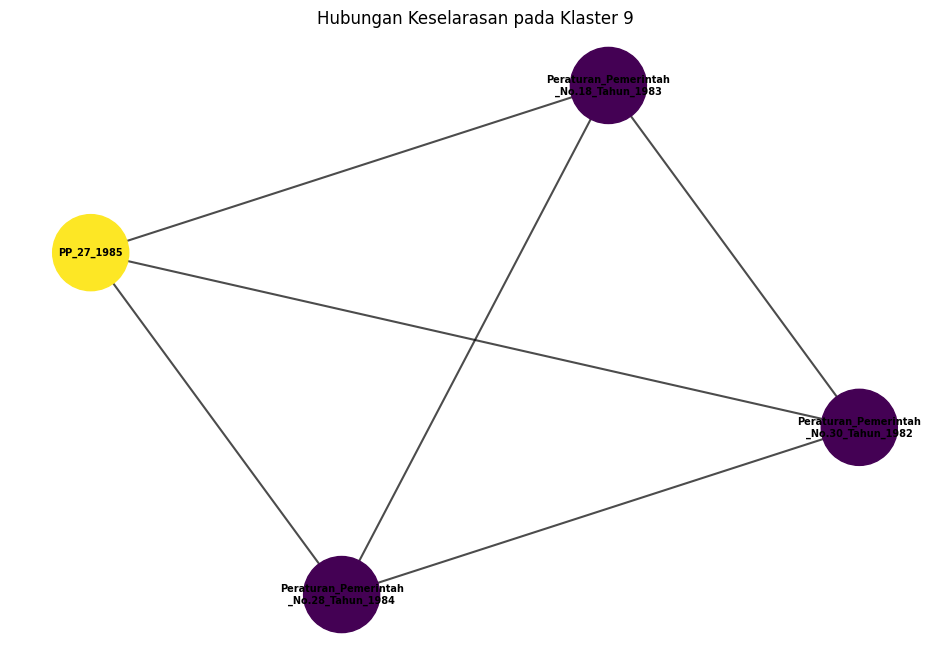

In [183]:
# Extract nodes for Topic 12
topic12 = list(topics[11])

# Create a subgraph containing only nodes from Topic 12
G_topic12 = G.subgraph(topic12)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_topic12, seed=42, k=1.5)

# Choose a colormap with 20 distinct colors and select the first 16 colors
num_colors = 16
colormap = plt.cm.get_cmap('tab20', num_colors)

color = colormap(11)  # Get the color for Topic 12
nx.draw_networkx_nodes(G_topic12, pos, node_color=color, node_size=3000, label=f"Topic 9")

nx.draw_networkx_edges(G_topic12, pos, width=1.5, alpha=0.7)
label_pos = {node: (x, y) for node, (x, y) in pos.items()}
wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic12.nodes()}
nx.draw_networkx_labels(G_topic12, label_pos, labels=wrapped_labels, font_size=7, font_color='black', font_weight='bold')

plt.axis('off')
plt.title("Hubungan Keselarasan pada Klaster 9")
plt.show()

In [184]:
filtered_nodes = [node for node, degree in topics_dict.items() if len(degree) <= 3]
filtered_nodes

['Klaster3',
 'Klaster4',
 'Klaster5',
 'Klaster6',
 'Klaster7',
 'Klaster11',
 'Klaster13',
 'Klaster15',
 'Klaster16',
 'Klaster17']

<ipython-input-187-d8eb56214d83>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('GnBu', num_colors)


ValueError: ignored

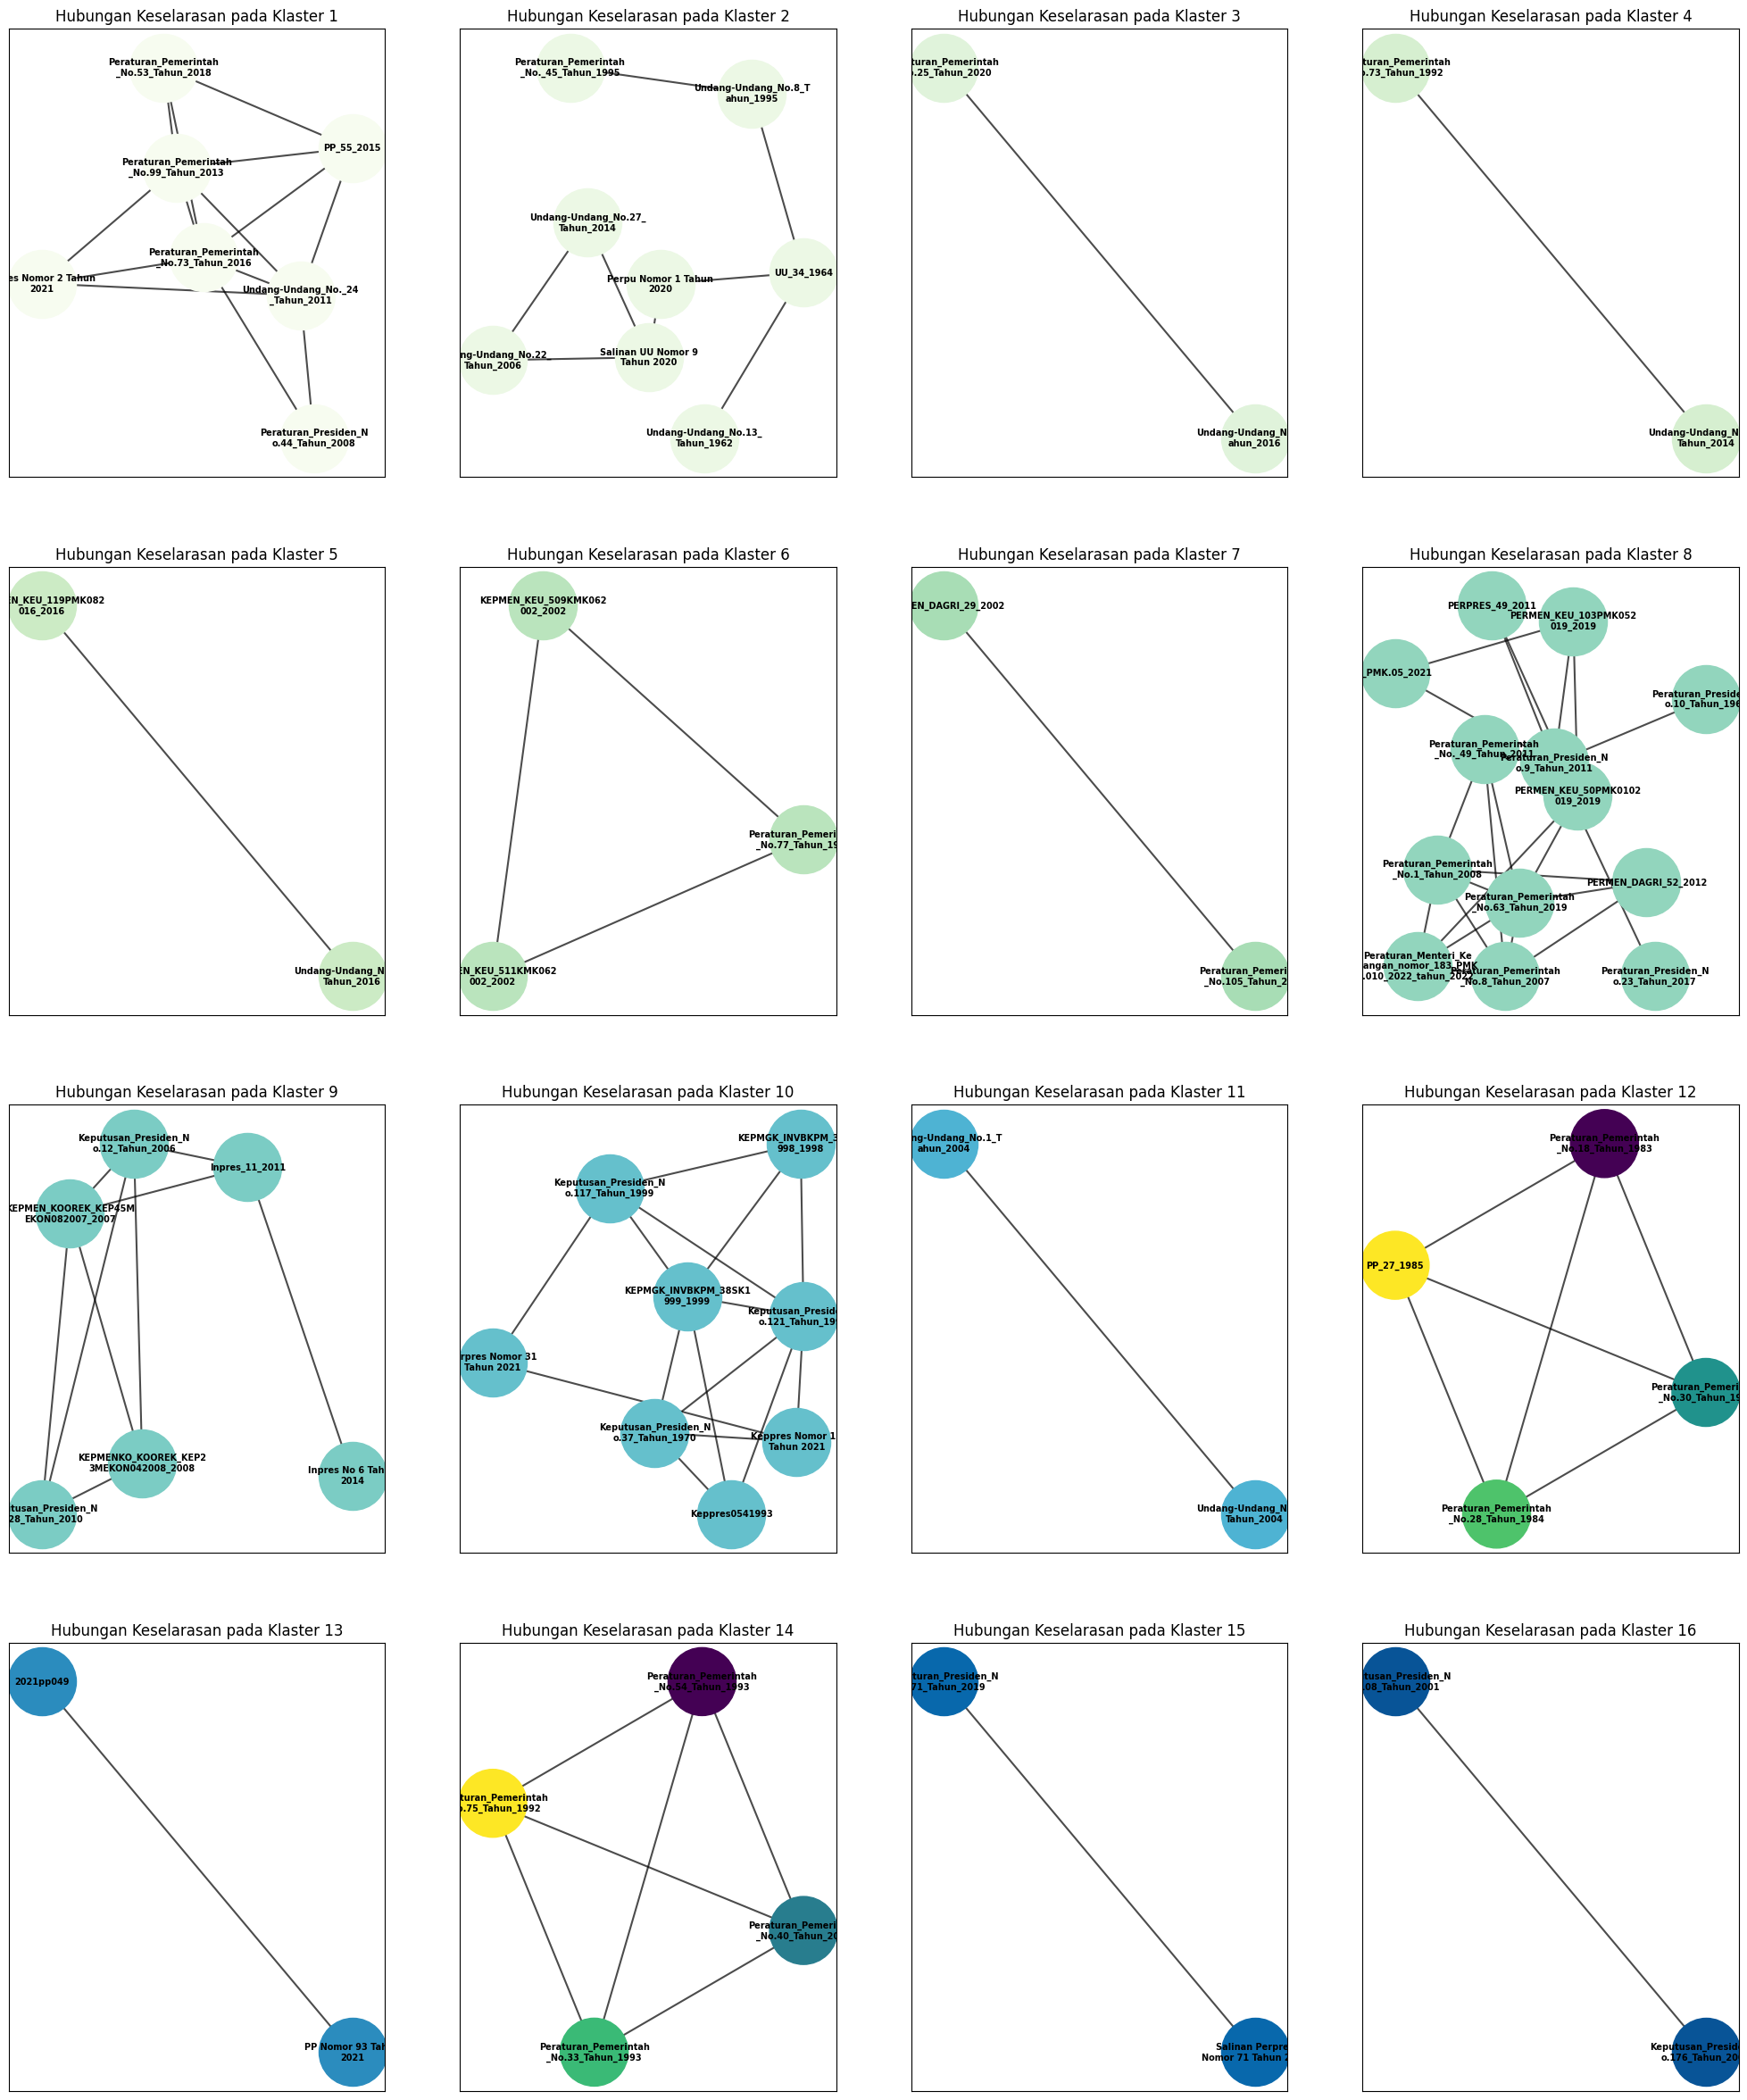

In [187]:
def plot_subgraph(G, topics, index, subplot_index, topics_dict):
    # Extract nodes for Topic
    topic = list(topics[index])

    # Create a subgraph containing only nodes from the topic
    G_topic = G.subgraph(topic)

    plt.subplot(4, 4, subplot_index)  # 3 rows and 4 columns, subplot_index specifies the position
    pos = nx.spring_layout(G_topic, seed=42, k=1.5)

    # Choose a colormap with x distinct colors and select the color for the topic
    num_colors = len(topics_dict)
    colormap = plt.cm.get_cmap('GnBu', num_colors)
    color = colormap(index)
    nx.draw_networkx_nodes(G_topic, pos, node_color=color, node_size=3000, label=f"Topic {index}")

    nx.draw_networkx_edges(G_topic, pos, width=1.5, alpha=0.7)
    label_pos = {node: (x, y) for node, (x, y) in pos.items()}
    wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic.nodes()}
    nx.draw_networkx_labels(G_topic, label_pos, labels=wrapped_labels, font_size=7, font_color='black', font_weight='bold')
    plt.title(f"Hubungan Keselarasan pada Klaster {index+1}")


# Topics list
index = range(len(topics_dict))

# Create subplots for each selected topic
plt.figure(figsize=(25, 30))
for k, i in enumerate(index):
    plot_subgraph(G, topics, k, k+1, topics_dict)

plt.tight_layout()
plt.show()

## Selective Document

In [188]:
df['FileName'].head()

0    PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...
1                Peraturan_Pemerintah_No.63_Tahun_2019
2                 Peraturan_Pemerintah_No.1_Tahun_2008
3                 Peraturan_Pemerintah_No.8_Tahun_2007
4                Peraturan_Pemerintah_No.24_Tahun_2019
Name: FileName, dtype: object

In [189]:
all_selaras = all_selaras.iloc[:,:2]
all_selaras.head()

Perundangan1                     Perundangan2
0   Peraturan_Pemerintah_No.99_Tahun_2013  Undang-Undang_No._24_Tahun_2011
1  Peraturan_Pemerintah_No._45_Tahun_1995    Undang-Undang_No.8_Tahun_1995
2   Peraturan_Pemerintah_No.25_Tahun_2020    Undang-Undang_No.4_Tahun_2016
3                              PP_55_2015  Undang-Undang_No._24_Tahun_2011
4   Peraturan_Pemerintah_No.73_Tahun_1992   Undang-Undang_No.40_Tahun_2014

In [190]:
all_selaras.to_csv('/content/drive/MyDrive/BDC SEMIFINAL/99 Archieves/all_selaras.csv')

In [191]:
!pip install fuzzywuzzy -q
!pip install python-Levenshtein -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.2 MB/s eta 0:00:00


In [196]:
from fuzzywuzzy import process

# Search for the document based on df['FileName']
def get_suggestions(query, threshold=75, df = df, col = 'FileName'):
  suggestions = set()
  for value in df[col]:
    similarity = process.extractOne(query, [value])
    if similarity[1] >= threshold:
      suggestions.add(similarity[0])
  return suggestions

# Save the selected document from searching
def select_suggestions(change):
  global selected_data
  selected_data = [suggestion for suggestion, selected in zip(suggestions, checkbox_widgets) if selected.value]
  print(f"Selected data: {selected_data}")

In [199]:
import ipywidgets as widgets

query = "PP"
suggestions = get_suggestions(query)

if suggestions:
  print(f"Suggestions for '{query}':")

  checkbox_widgets = [widgets.Checkbox(value=False, description=suggestion) for suggestion in suggestions]
  checkbox_container = widgets.VBox(checkbox_widgets)
  display(checkbox_container)

  select_button = widgets.Button(description="Select")
  select_button.on_click(select_suggestions)
  display(select_button)

else:
    print(f"No suggestions found for '{query}'.")

Suggestions for 'PP':


Button(description='Select', style=ButtonStyle())

Selected data: ['PP_27_1985', 'Keppres2951965']
Selected data: ['2021pp049', 'PP_27_1985', 'Keppres0541993', '2022pp031']


In [209]:
selected_data

['2021pp049', 'PP_27_1985', 'Keppres0541993', '2022pp031']

### Yang Selaras

In [210]:
# Filter the rows
filtered_rows = all_selaras[all_selaras['Perundangan1'].isin(selected_data) | all_selaras['Perundangan2'].isin(selected_data)]
filtered_rows

Perundangan1  \
32          KEPMGK_INVBKPM_38SK1999_1999   
56                PP Nomor 93 Tahun 2021   
60                            PP_27_1985   
61                            PP_27_1985   
62                            PP_27_1985   
73  Keputusan_Presiden_No.121_Tahun_1999   
75   Keputusan_Presiden_No.37_Tahun_1970   

                             Perundangan2  
32                         Keppres0541993  
56                              2021pp049  
60  Peraturan_Pemerintah_No.18_Tahun_1983  
61  Peraturan_Pemerintah_No.30_Tahun_1982  
62  Peraturan_Pemerintah_No.28_Tahun_1984  
73                         Keppres0541993  
75                         Keppres0541993

In [211]:
print("Hasil:")
for value in selected_data:
    if any(filtered_rows['Perundangan1'] == value) or any(filtered_rows['Perundangan2'] == value):
        print(f'{value} memiliki keselarasan')
    elif not any(filtered_rows['Perundangan1'] == value) and not any(filtered_rows['Perundangan2'] == value):
        print(f'{value} tidak memiliki keselarasan')

Hasil:
2021pp049 memiliki keselarasan
PP_27_1985 memiliki keselarasan
Keppres0541993 memiliki keselarasan
2022pp031 tidak memiliki keselarasan


In [212]:
def make_graph(dataframe):
  # Create a graph and add edges based on the similarities between 'Perundangan1' and 'Perundangan2'
  G = nx.Graph()
  for idx, row in dataframe.iterrows():
    G.add_edge(row['Perundangan1'], row['Perundangan2'])

  # Find connected components (topics) in the graph
  topics = list(nx.connected_components(G))

  # Convert the topics to a dictionary with keys as 'Topic1', 'Topic2', etc.
  topics_dict = {f"Klaster{i+1}": list(topic) for i, topic in enumerate(topics)}

  return G, topics, topics_dict

In [213]:
G, topics, topics_dict = make_graph(filtered_rows)
len(topics_dict)

3

<ipython-input-218-7c9351861c43>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Pastel1', num_colors)


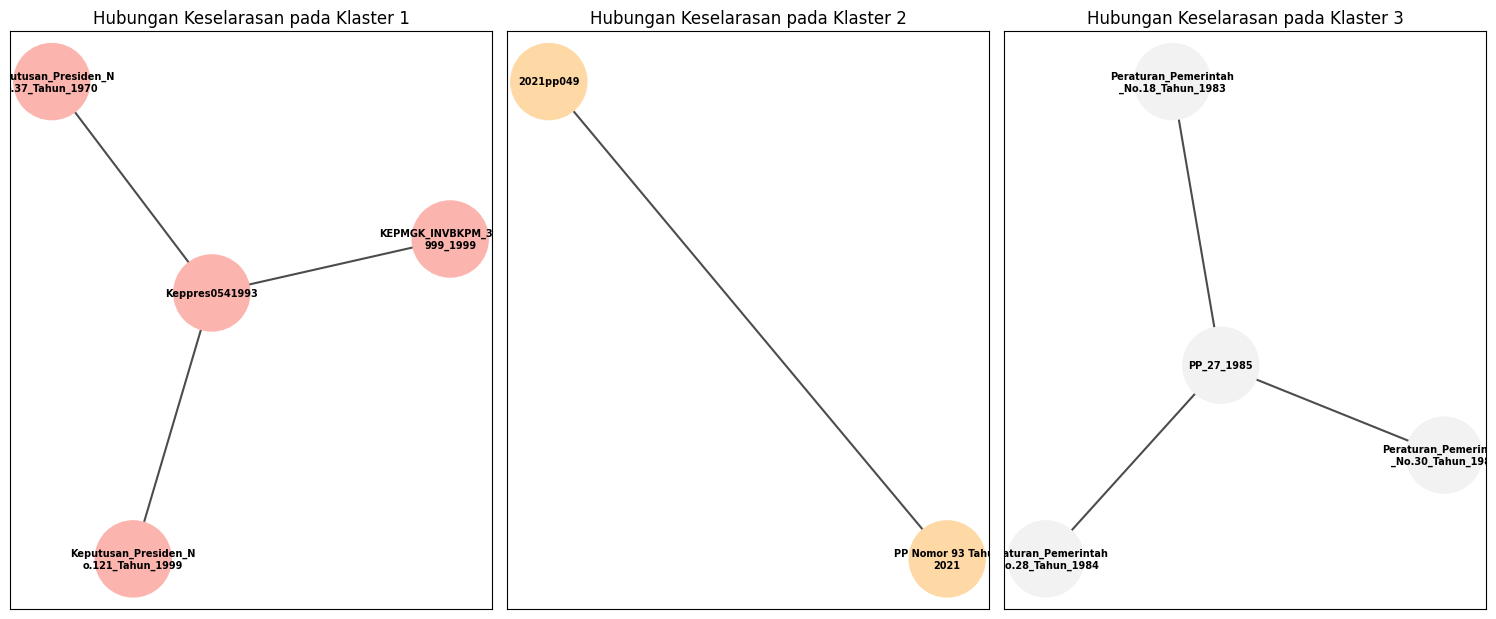

In [218]:
def plot_subgraph(G, topics, index, subplot_index, topics_dict):
    # Extract nodes for Topic
    topic = list(topics[index])

    # Create a subgraph containing only nodes from the topic
    G_topic = G.subgraph(topic)

    plt.subplot(5, 5, subplot_index)  # 3 rows and 4 columns, subplot_index specifies the position
    pos = nx.spring_layout(G_topic, seed=42, k=1.5)

    # Choose a colormap with x distinct colors and select the color for the topic
    num_colors = len(topics_dict)
    colormap = plt.cm.get_cmap('Pastel1', num_colors)
    color = colormap(index)
    node_colors = [color] * len(G_topic.nodes())
    nx.draw_networkx_nodes(G_topic, pos, node_color=node_colors, node_size=3000, label=f"Topic {index}")

    nx.draw_networkx_edges(G_topic, pos, width=1.5, alpha=0.7)
    label_pos = {node: (x, y) for node, (x, y) in pos.items()}
    wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic.nodes()}
    nx.draw_networkx_labels(G_topic, label_pos, labels=wrapped_labels, font_size=7, font_color='black', font_weight='bold')
    plt.title(f"Hubungan Keselarasan pada Klaster {index+1}")


# Topics list
index = range(len(topics_dict))

# Create subplots for each selected topic
plt.figure(figsize=(25, 30))
for k, i in enumerate(index):
    plot_subgraph(G, topics, k, k+1, topics_dict)

plt.tight_layout()
plt.show()